In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

import pmdarima as pm
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

### priprema podataka za vremensku seriju - dopunjavanje dana koji nedostaju 0

In [3]:
daily_data = pd.read_csv("../podaci/vremenske-serije/date_day_norm.csv")
daily_data = daily_data.astype({'date': 'datetime64[ns]'})

# 1. koji range imamo:
min_date = daily_data['date'].min()
max_date = daily_data['date'].max()
daily_data.set_index('date', inplace=True)

date_range = pd.date_range(min_date, max_date, freq='D')

# 2. left-join na date_range sa našim datumima
date_range_series = pd.Series(index=date_range, dtype='int64')
daily_data_filled = pd.concat([daily_data,
                               date_range_series[~date_range_series.index.isin(daily_data.index)]]).sort_index()

daily_data_filled = daily_data_filled.drop([0], axis=1).fillna(0).astype({'demand_value': 'float32'})
daily_data_filled['date'] = daily_data_filled.index
daily_data_filled.reset_index(drop=True, inplace=True)
daily_data_filled.head(5)

demand_value       date
0      0.098039 2019-12-18
1      0.245098 2019-12-19
2      0.401961 2019-12-20
3      0.000000 2019-12-21
4      0.000000 2019-12-22

In [4]:
min_date, max_date

(Timestamp('2019-12-18 00:00:00'), Timestamp('2021-05-29 00:00:00'))

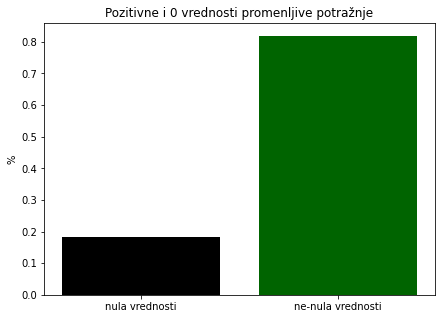

In [5]:
# šta su datumi koji nedostaju?

zero_demand = len(daily_data_filled[daily_data_filled['demand_value'] == 0])
non_zero_demand = len(daily_data_filled[daily_data_filled['demand_value'] != 0])
demand = len(daily_data_filled)

plt.figure(figsize=(7, 5))
plt.title("Pozitivne i 0 vrednosti promenljive potražnje")
plt.ylabel("%")
plt.bar(['nula vrednosti', 'ne-nula vrednosti'], 
        [zero_demand/demand, non_zero_demand/demand], 
        color=['black', 'darkgreen'])
plt.savefig("../../grafici/nula_vrednosti_dnevni_podaci.eps", dpi=300)
plt.show()

In [6]:
# koliko datuma sa 0 su nedelje? 
zero_days = daily_data_filled[daily_data_filled['demand_value'] == 0]['date'].apply(lambda x: pd.to_datetime(x).day_name())

week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
week_days_dict_zero = {}

for day in week_days:
    print(f"{day}: {len(zero_days[zero_days == day])}")
    week_days_dict_zero[day] = len(zero_days[zero_days == day])

Monday: 3
Tuesday: 2
Wednesday: 3
Thursday: 5
Friday: 5
Saturday: 10
Sunday: 68


In [7]:
daily_data_filled.shape, daily_data.shape

((529, 2), (433, 1))

In [8]:
529 - 433

96

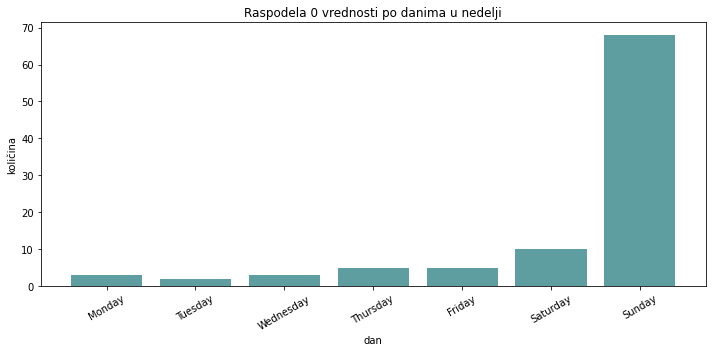

In [9]:
plt.figure(figsize=(10, 5))
plt.title("Raspodela 0 vrednosti po danima u nedelji")
plt.xlabel("dan")
plt.ylabel("količina")
plt.bar(list(week_days_dict_zero.keys()), list(week_days_dict_zero.values()), color='cadetblue')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("../../grafici/nule_po_danima_nedelje.eps", dpi=300)
plt.show()

In [10]:
# koliko datuma sa vrednostima != 0 su nedelje? 
non_zero_days = daily_data_filled[daily_data_filled['demand_value'] != 0]['date'].apply(lambda x: pd.to_datetime(x).day_name())
week_days_dict_non_zero = {}

week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for day in week_days:
    print(f"{day}: {len(non_zero_days[non_zero_days == day])}")
    week_days_dict_non_zero[day] = len(non_zero_days[non_zero_days == day])

Monday: 72
Tuesday: 73
Wednesday: 73
Thursday: 71
Friday: 71
Saturday: 66
Sunday: 7


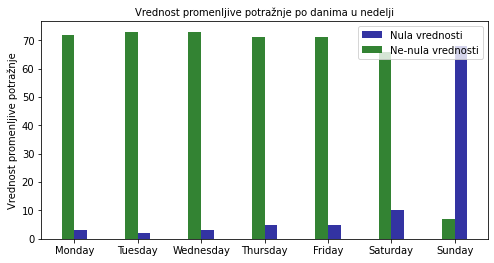

In [11]:
x = np.arange(len(week_days_dict_non_zero))

plt.figure(figsize=(8, 4))
plt.bar(x, week_days_dict_zero.values(), width=0.2, 
        color='darkblue', align='edge', label='Nula vrednosti', alpha=0.8)
plt.bar(x-0.2, week_days_dict_non_zero.values(), width=0.2, 
        color='darkgreen', align='edge', label='Ne-nula vrednosti', alpha=0.8)
plt.legend(loc='best')
plt.xticks(x, week_days_dict_non_zero.keys())
plt.ylabel("Vrednost promenljive potražnje")
plt.title("Vrednost promenljive potražnje po danima u nedelji", fontsize=10)
plt.show()

In [12]:
# preostali datumi su praznici?
# 10 subota i oko nove godine/božića/midsummer
# week_days_no_sunday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
# daily_data_filled[(daily_data_filled['demand_value'] == 0) & 
#                  (daily_data_filled['date'].apply(lambda x: pd.to_datetime(x).day_name() in week_days_no_sunday))]

In [13]:
# izbaci nedelje iz podataka i vidi kako izgledaju stvari bez njih -> -> ->
no_sundays_data = daily_data_filled[daily_data_filled['date'].apply(lambda x: pd.to_datetime(x).day_name()) != 'Sunday'].reset_index(drop=True)

In [14]:
no_sundays_data.tail(14)

demand_value       date
440      0.901961 2021-05-14
441      0.049020 2021-05-15
442      0.794118 2021-05-17
443      1.009804 2021-05-18
444      1.049020 2021-05-19
445      1.098039 2021-05-20
446      0.892157 2021-05-21
447      0.019608 2021-05-22
448      0.882353 2021-05-24
449      1.078431 2021-05-25
450      1.245098 2021-05-26
451      1.284314 2021-05-27
452      1.000000 2021-05-28
453      0.009804 2021-05-29

### ARIMA - podaci po danima

In [15]:
def plot_timeseries(data, column="demand_value", granularity="dani"):
    size_df = len(data[column])
    
    plt.rcParams.update({'figure.figsize':(11, 5), 'figure.dpi':300})
    plt.plot(data[column], 
             label="original")
    plt.plot(np.arange(0, size_df, 1), 
             np.repeat(np.mean(data[column]), size_df),
             label="srednja vrednost")
    
    plt.title("Vrednost promenljive potražnje tokom vremena")
    plt.xlabel(f"{granularity}")
    plt.ylabel("promenljiva potražnje")
    plt.legend()
    plt.savefig("../../vremenska_serija_primer.eps", dpi=300)

def auto_diffs(df, target="demand_value", test="adf"):
    print(f'Originalni podaci diff d: {pm.arima.utils.ndiffs(df[target], test=test, max_d=3)}')
    print(f'Originalni podaci diff D: {pm.arima.utils.nsdiffs(df[target], m=6, max_D=10)}')


def probplot(df, target="demand_value"):
    plt.rcParams.update({'figure.figsize':(8, 7), 'figure.dpi':90})
    fig = plt.figure()

    ax1 = fig.add_subplot(411)
    prob = stats.probplot(df[target], dist='norm', plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot u odnosu na normalnu distribuciju')

    ax2 = fig.add_subplot(412)
    prob = stats.probplot(df[target].diff().dropna(), dist='norm', plot=ax2)
    ax2.set_xlabel('')
    ax2.set_title('Probplot za jednom diferencirane (y(t) - y(t-1)) originalne podatke')

    ax3 = fig.add_subplot(413)
    prob = stats.probplot(df[target].diff().diff().dropna(), dist='norm', plot=ax3)
    ax3.set_xlabel('')
    ax3.set_title('Probplot za 2 puta diferencirane originalne podatke')

    ax4 = fig.add_subplot(414)
    prob = stats.probplot(df[target].diff().diff().diff().dropna(), dist='norm', plot=ax4)
    ax4.set_title('Probplot za 3 puta diferencirane originalne podatke')

    plt.tight_layout()
    plt.show()

def plot_acf_pacf(df, diff_period=6, target="demand_value", lags_acf=40, lags_pacf=20):
    plt.rcParams.update({'figure.figsize':(12, 10), 'figure.dpi':300})

    fig, axs = plt.subplots(3, 2)

    plot_acf(df[target], ax=axs[0, 0], lags=lags_acf, alpha=0.05)
    axs[0, 0].set_title("Originalni podaci ACF")
    plot_acf(df[target].diff().dropna(), ax=axs[1, 0], lags=lags_acf, alpha=0.05)
    axs[1, 0].set_title("1 diff() originalni podaci ACF")
#     plot_acf(df[target].diff().diff().dropna(), ax=axs[2, 0], lags=lags_acf, alpha=0.05)
#     axs[2, 0].set_title("2 diff().diff() originalni podaci ACF")
    plot_acf(df[target].diff(periods=diff_period).dropna(), ax=axs[2, 0], lags=lags_acf, alpha=0.05)
    axs[2, 0].set_title(f"diff(periods={diff_period}) originalni podaci ACF")
#     plot_acf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 0], lags=lags_acf, alpha=0.05)
#     axs[4, 0].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci ACF")

    plot_pacf(df[target], ax=axs[0, 1], lags=lags_pacf, alpha=0.05)
    axs[0, 1].set_title("Originalni podaci PACF")
    plot_pacf(df[target].diff().dropna(), ax=axs[1, 1], lags=lags_pacf, alpha=0.05)
    axs[1, 1].set_title("1 diff() originalni podaci PACF")
#     plot_pacf(df[target].diff().diff().dropna(), ax=axs[2, 1], lags=lags_pacf, alpha=0.05)
#     axs[2, 1].set_title("2 diff().diff() originalni podaci PACF")
    plot_pacf(df[target].diff(periods=diff_period).dropna(), ax=axs[2, 1], lags=lags_pacf, alpha=0.05)
    axs[2, 1].set_title(f"diff(periods={diff_period}) originalni podaci PACF")
#     plot_pacf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 1], lags=lags_pacf, alpha=0.05)
#     axs[4, 1].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci PACF")

    plt.tight_layout()
    plt.savefig("../../grafici/acf_pacf_dnevni.png", dpi=300)
    plt.show()

def test_stationarity(timeseries, rolling_param=14):
    rolmean = timeseries.rolling(rolling_param).mean()
    rolstd = timeseries.rolling(rolling_param).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Kotrljajuća srednja vrednost')
    plt.plot(rolstd, color='black', label = 'Kotrljajuća standardna devijacija')
    plt.legend(loc='best')
    plt.title('Kotrljajuća srednja vrednost i standardna devijacija')
    plt.show(block=False)

    print("Rezultati Dickey-Fuller Testa")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4],
                       index=['Test Statistics',
                              'p-value',
                              'No. of lags used',
                              'Number of observations used'])
    
    for key, values in adft[4].items():
        output['critical value (%s)' % key] =  values
    print(output)

def auto_arima(df, target="demand_value", m=6):
    auto_model = pm.auto_arima(df[target], 
                               start_p=0,
                               start_q=0, 
                               max_p=5,
                               max_q=5, 
                               d=0, 
                               D=0, 
                               start_P=0,
                               start_Q=0, 
                               max_P=5, 
                               max_Q=5, 
                               m=m, 
                               stepwise=True, 
                               approximation=False,
                               seasonal=True)
#     auto_model.summary() 
  
    return auto_model

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Originalni podaci diff d: 0
Originalni podaci diff D: 0


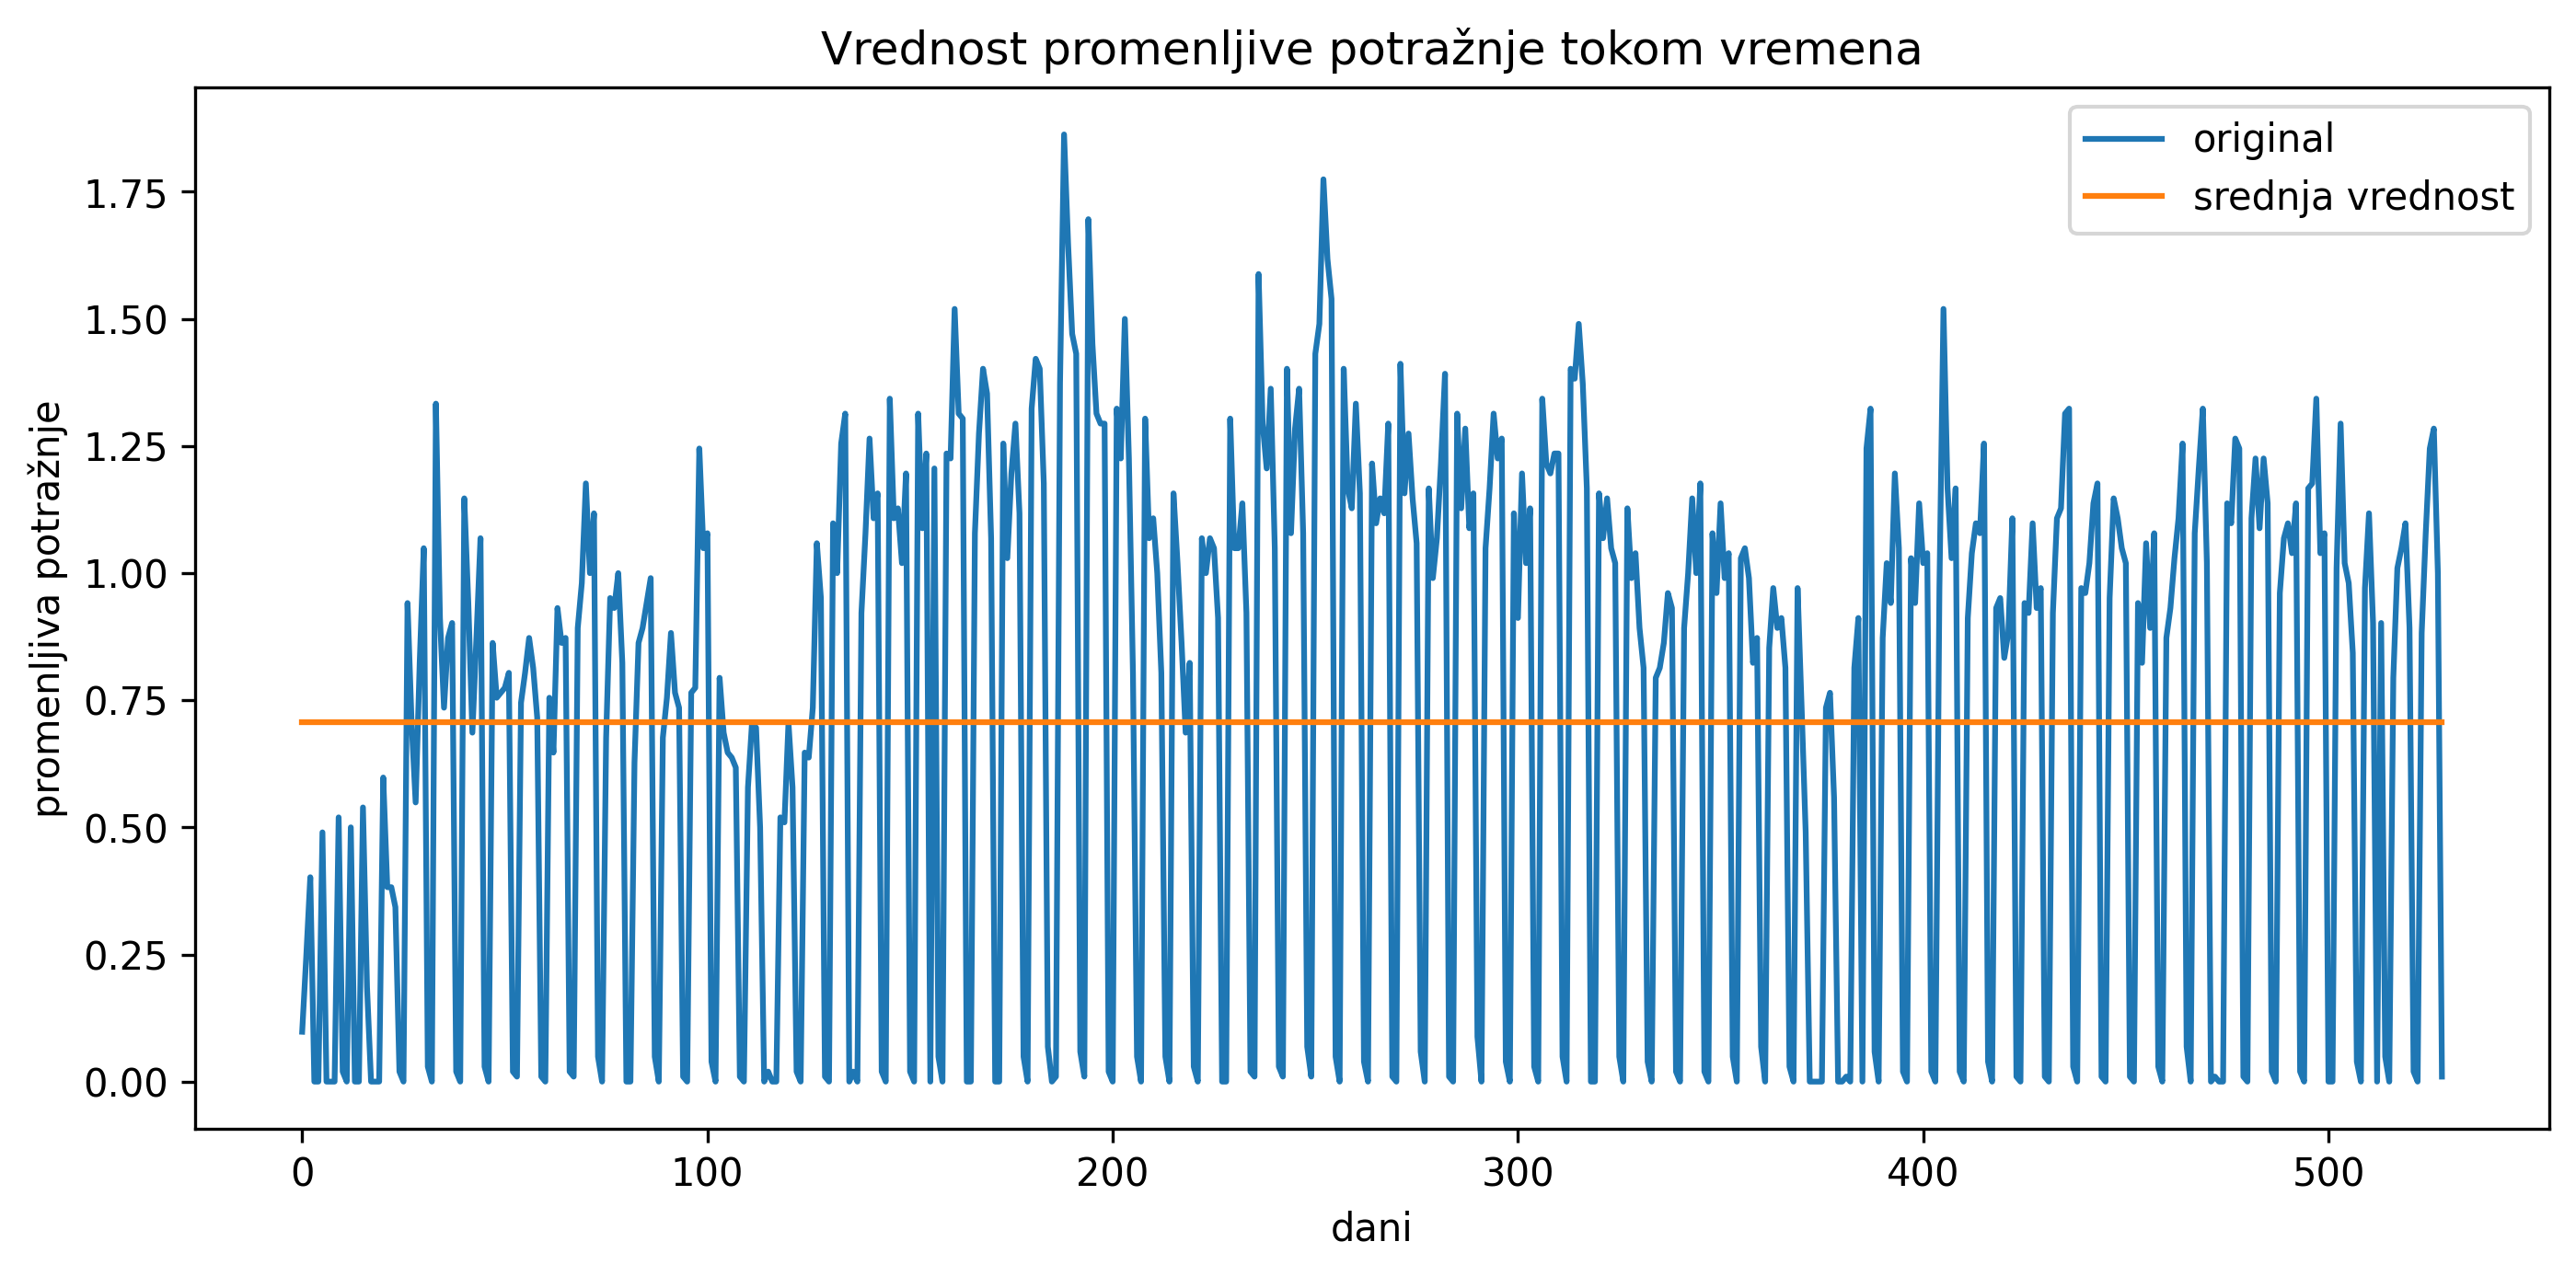

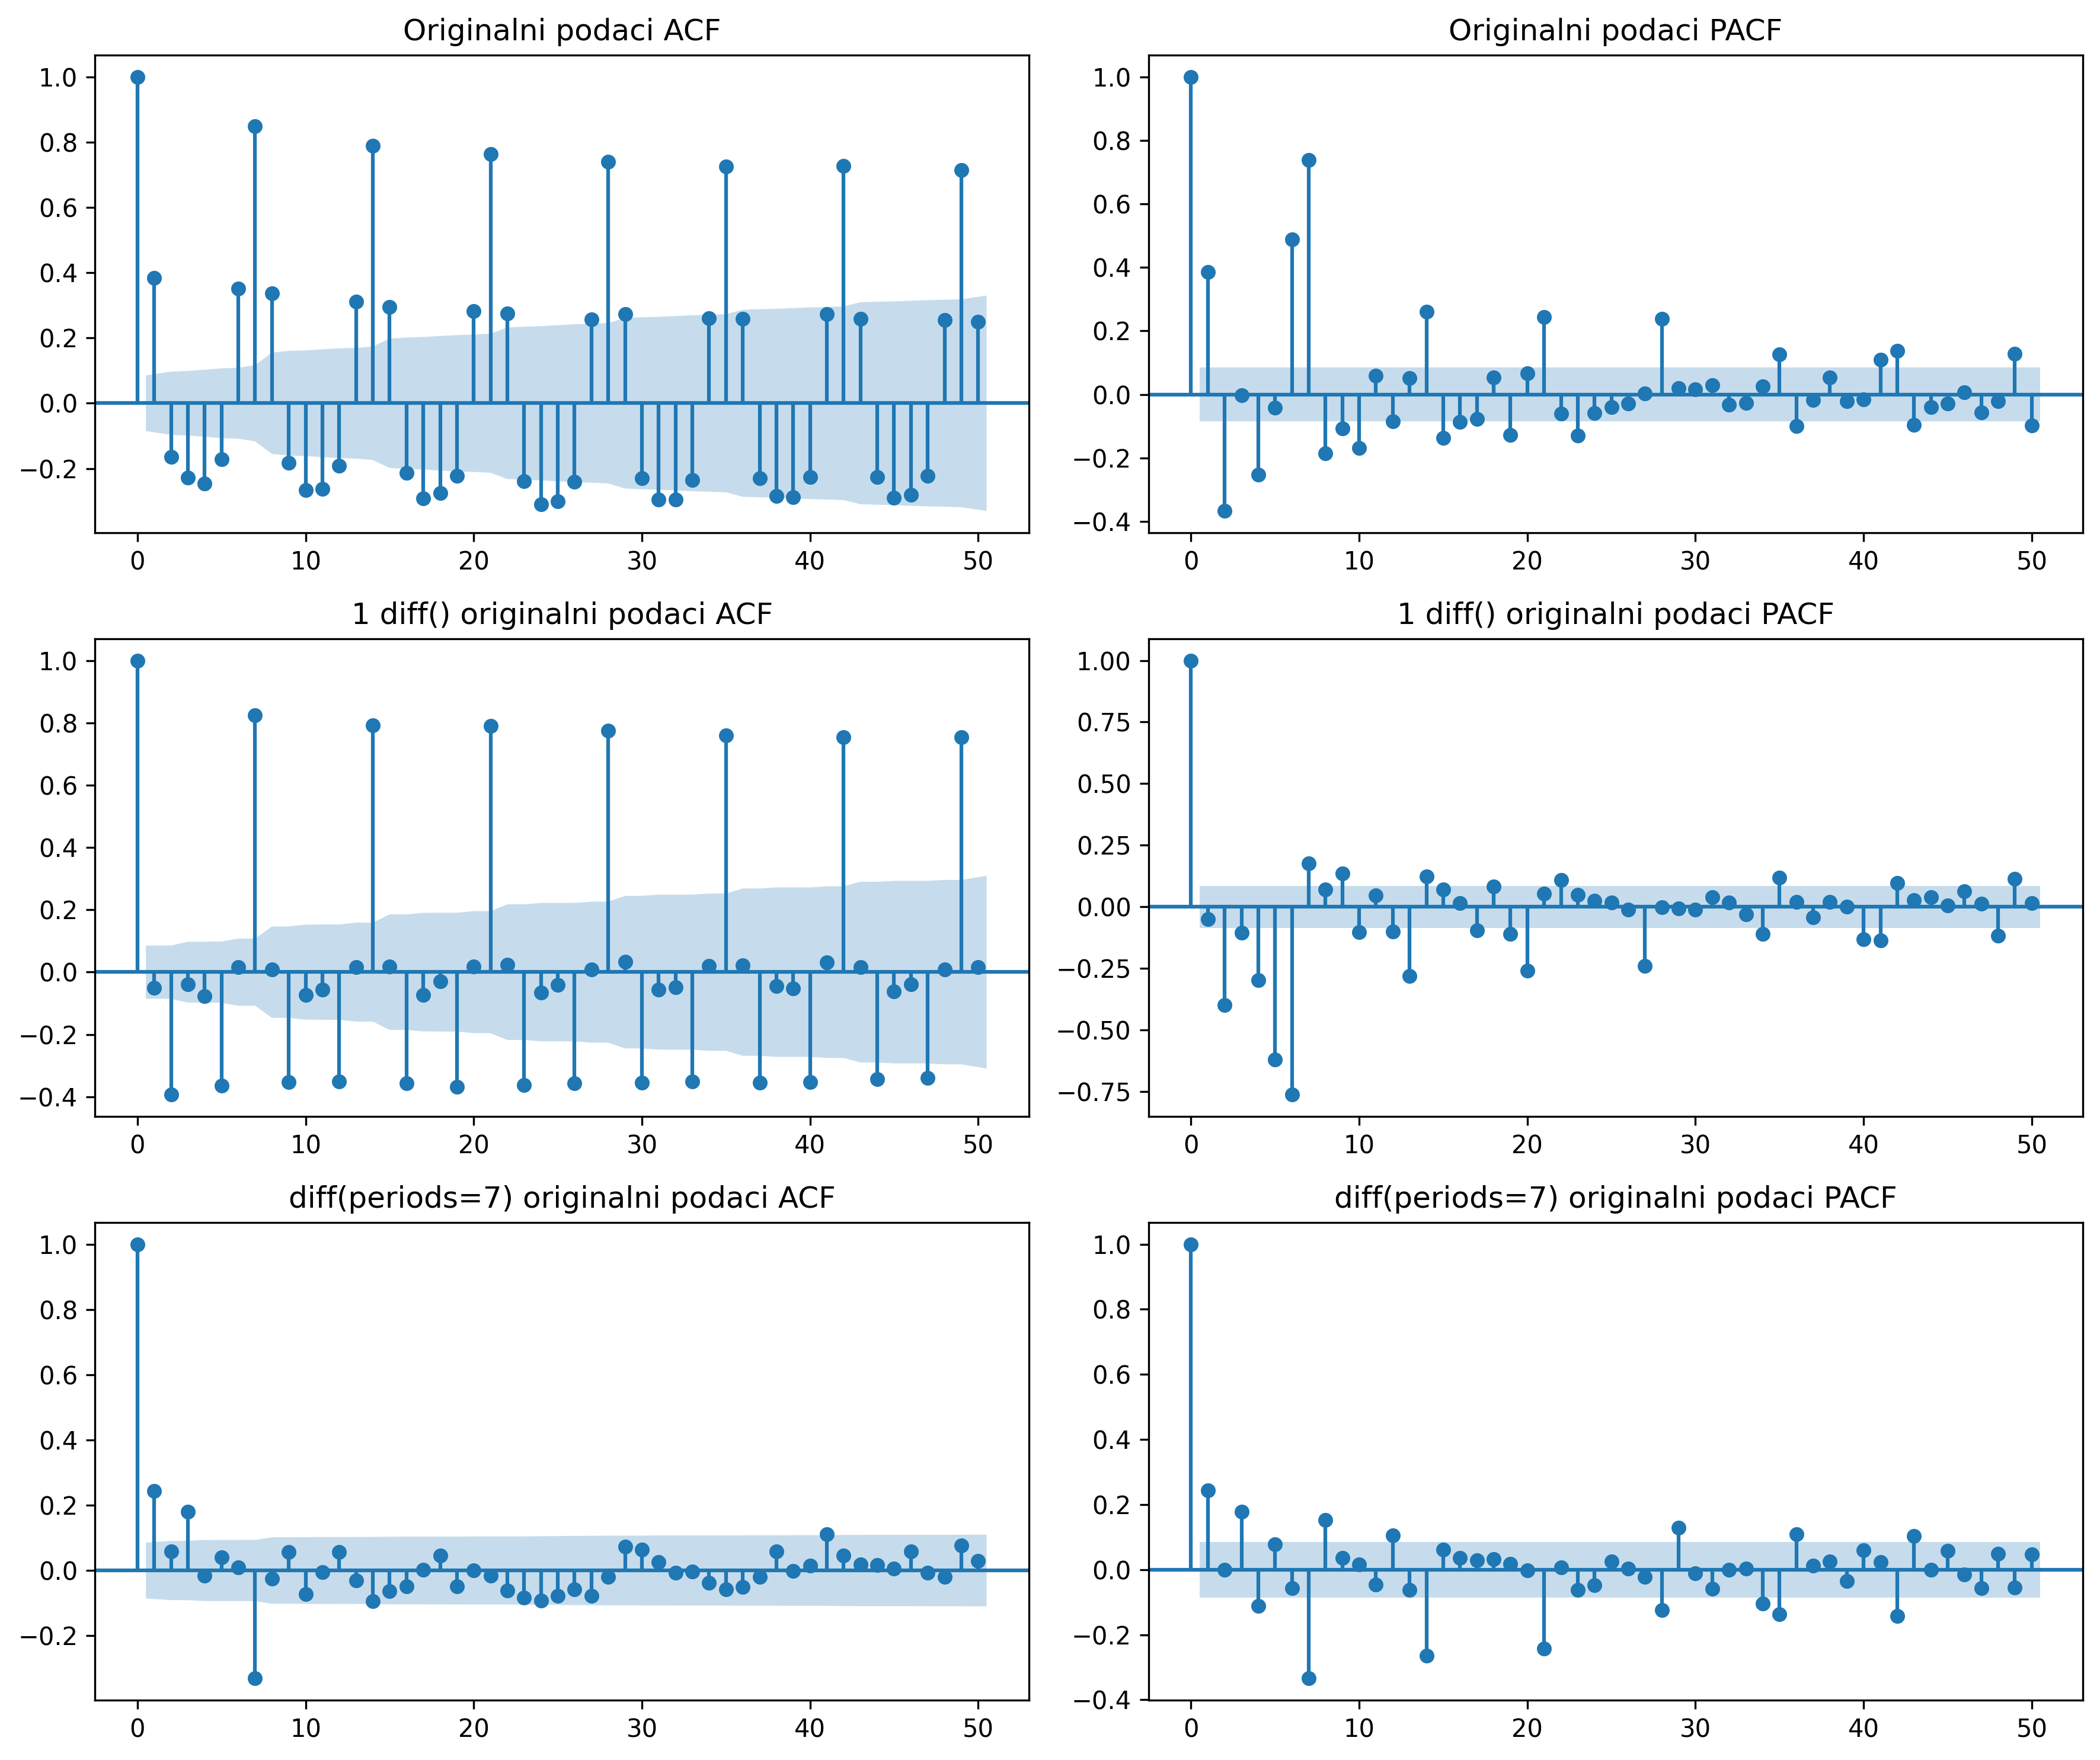

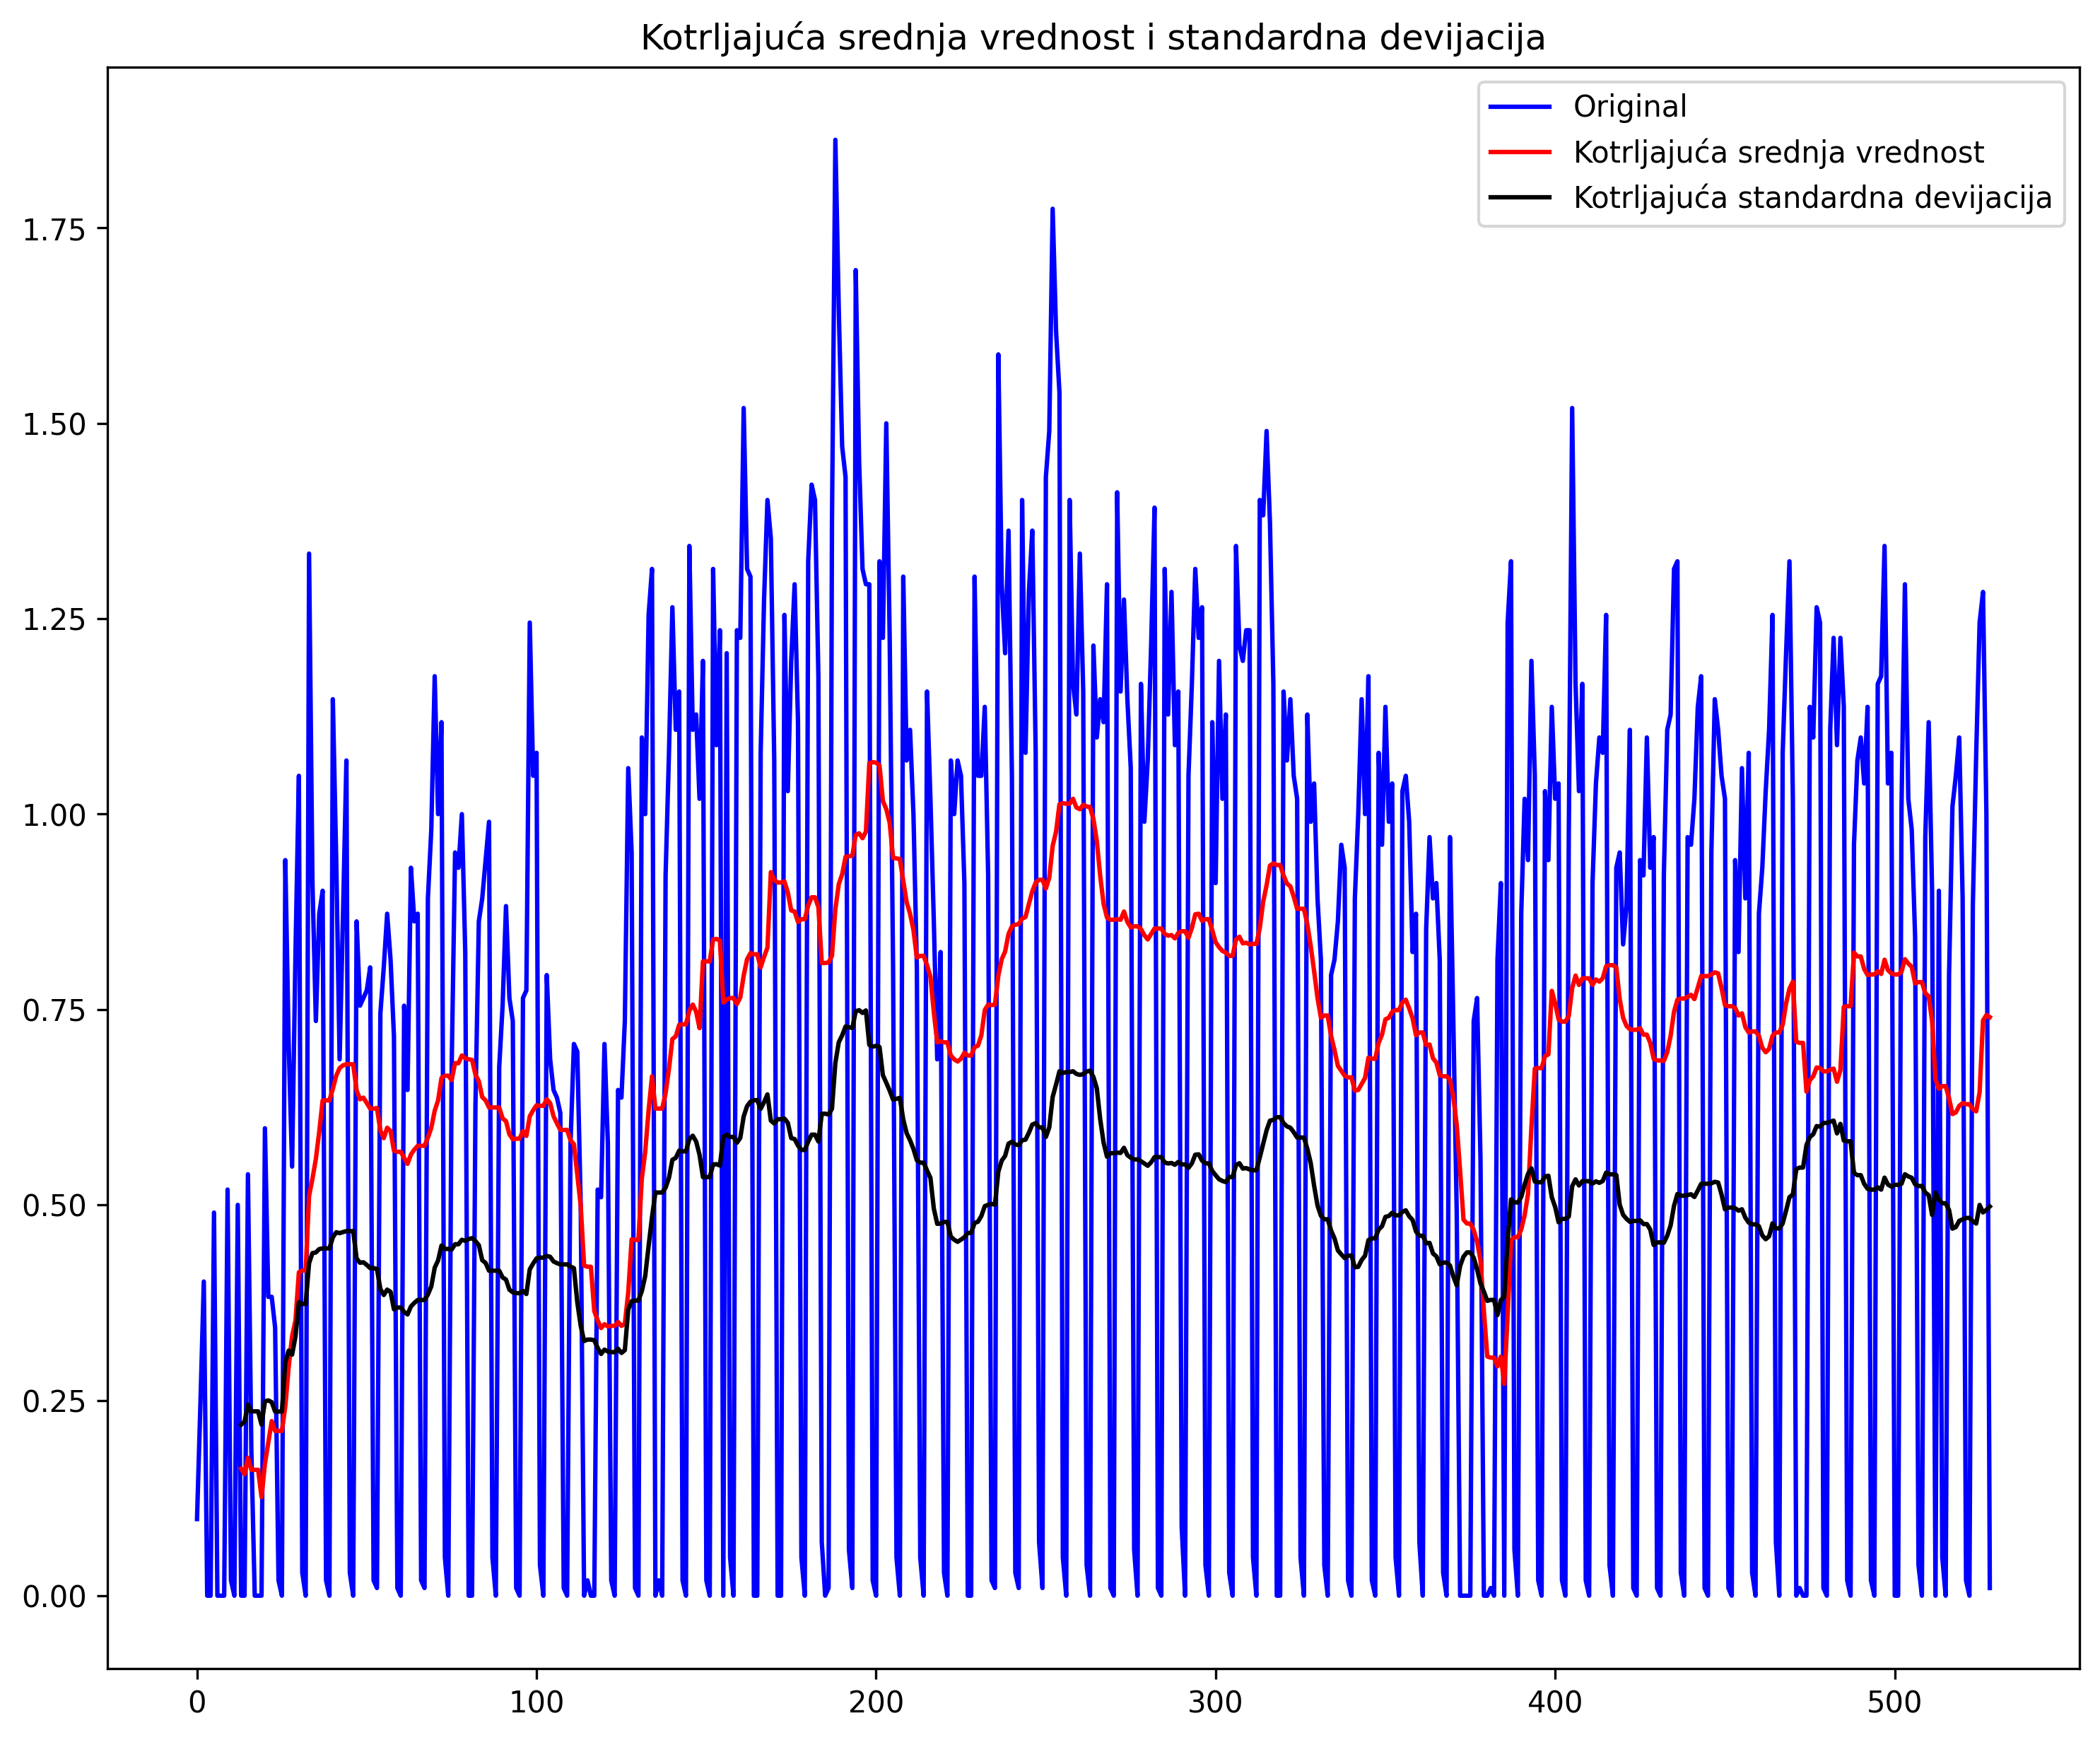

Rezultati Dickey-Fuller Testa
Test Statistics                 -4.579649
p-value                          0.000141
No. of lags used                19.000000
Number of observations used    509.000000
critical value (1%)             -3.443263
critical value (5%)             -2.867235
critical value (10%)            -2.569803
dtype: float64


In [16]:
plot_timeseries(daily_data_filled)
auto_diffs(daily_data_filled)
plot_acf_pacf(daily_data_filled, diff_period=7, lags_acf=50, lags_pacf=50)

# If the p-value is less than 0.05, we reject the null hypothesis
test_stationarity(daily_data_filled['demand_value'])

In [17]:
# auto_model = auto_arima(daily_data_filled, m=7)
# auto_model.summary()

Originalni podaci diff d: 0
Originalni podaci diff D: 0


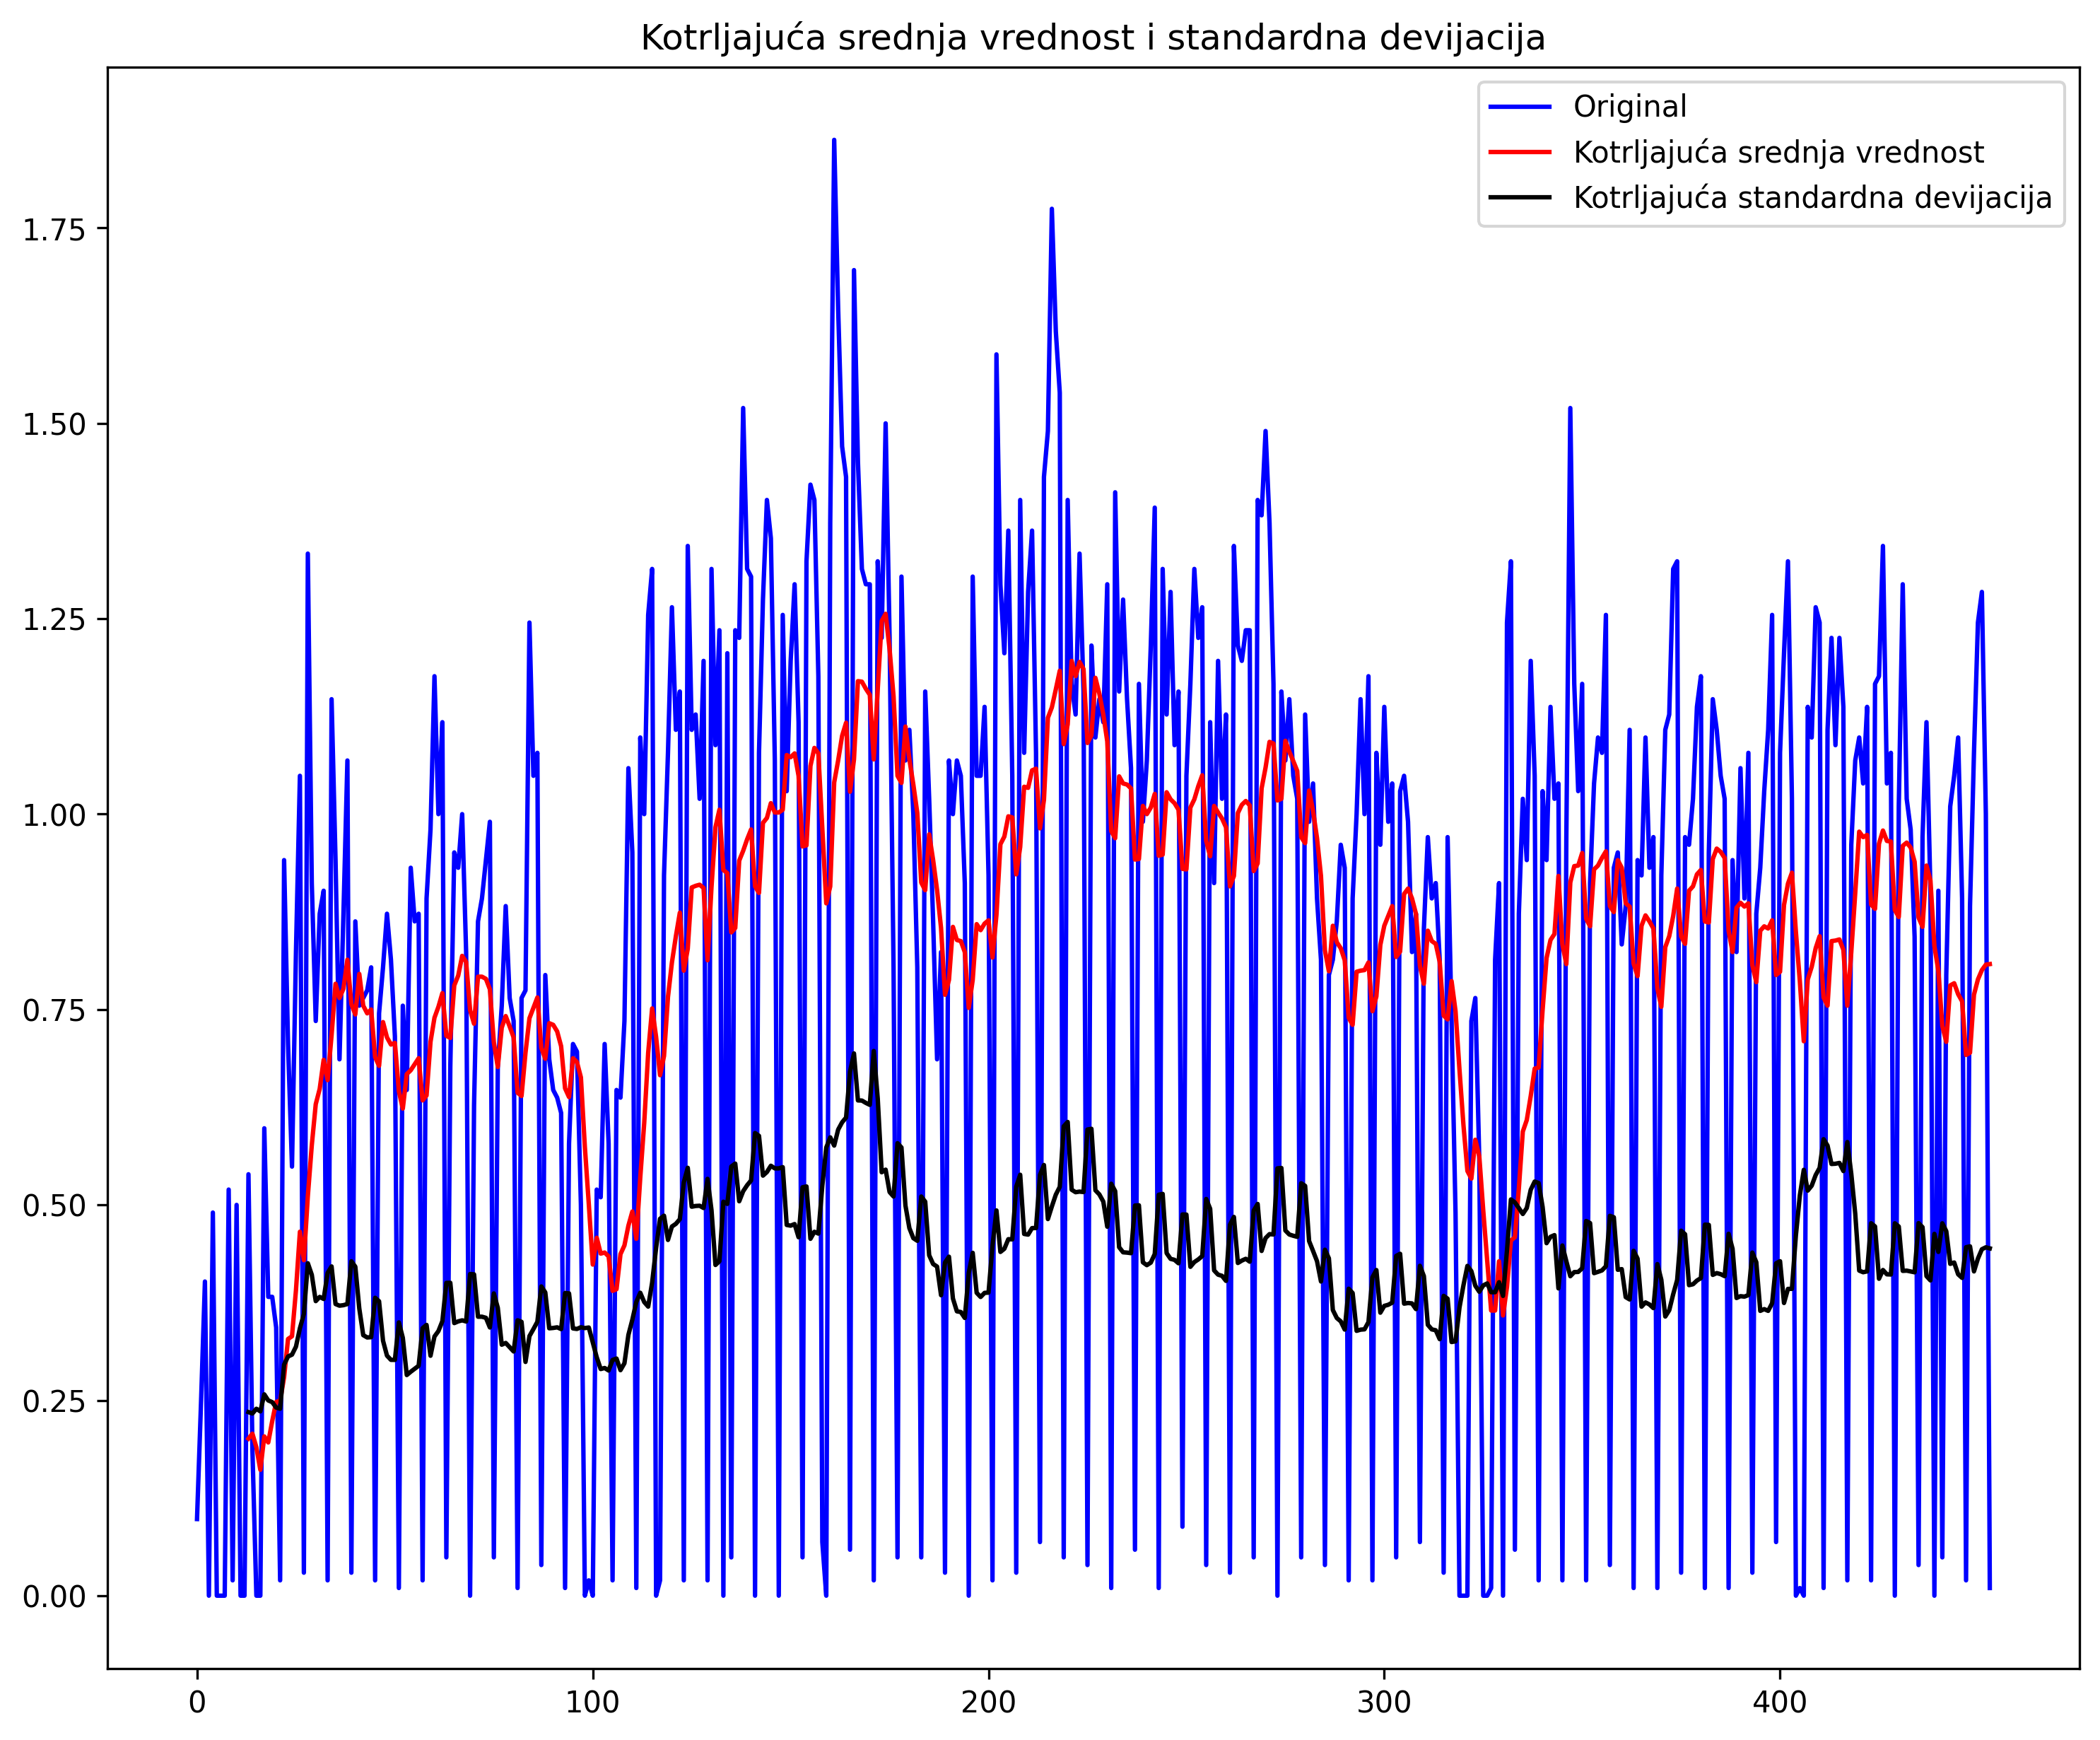

Rezultati Dickey-Fuller Testa
Test Statistics                 -3.674781
p-value                          0.004482
No. of lags used                18.000000
Number of observations used    435.000000
critical value (1%)             -3.445473
critical value (5%)             -2.868207
critical value (10%)            -2.570321
dtype: float64


In [18]:
auto_diffs(no_sundays_data)

# If the p-value is less than 0.05, we reject the null hypothesis
test_stationarity(no_sundays_data['demand_value'])

## da/ne stacionarna vremenska serija?
1. Look at Plots: 
You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
2. Summary Statistics: 
You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
3. Statistical Tests: 
You can use statistical tests to check if the expectations of stationarity are met or have been violated.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


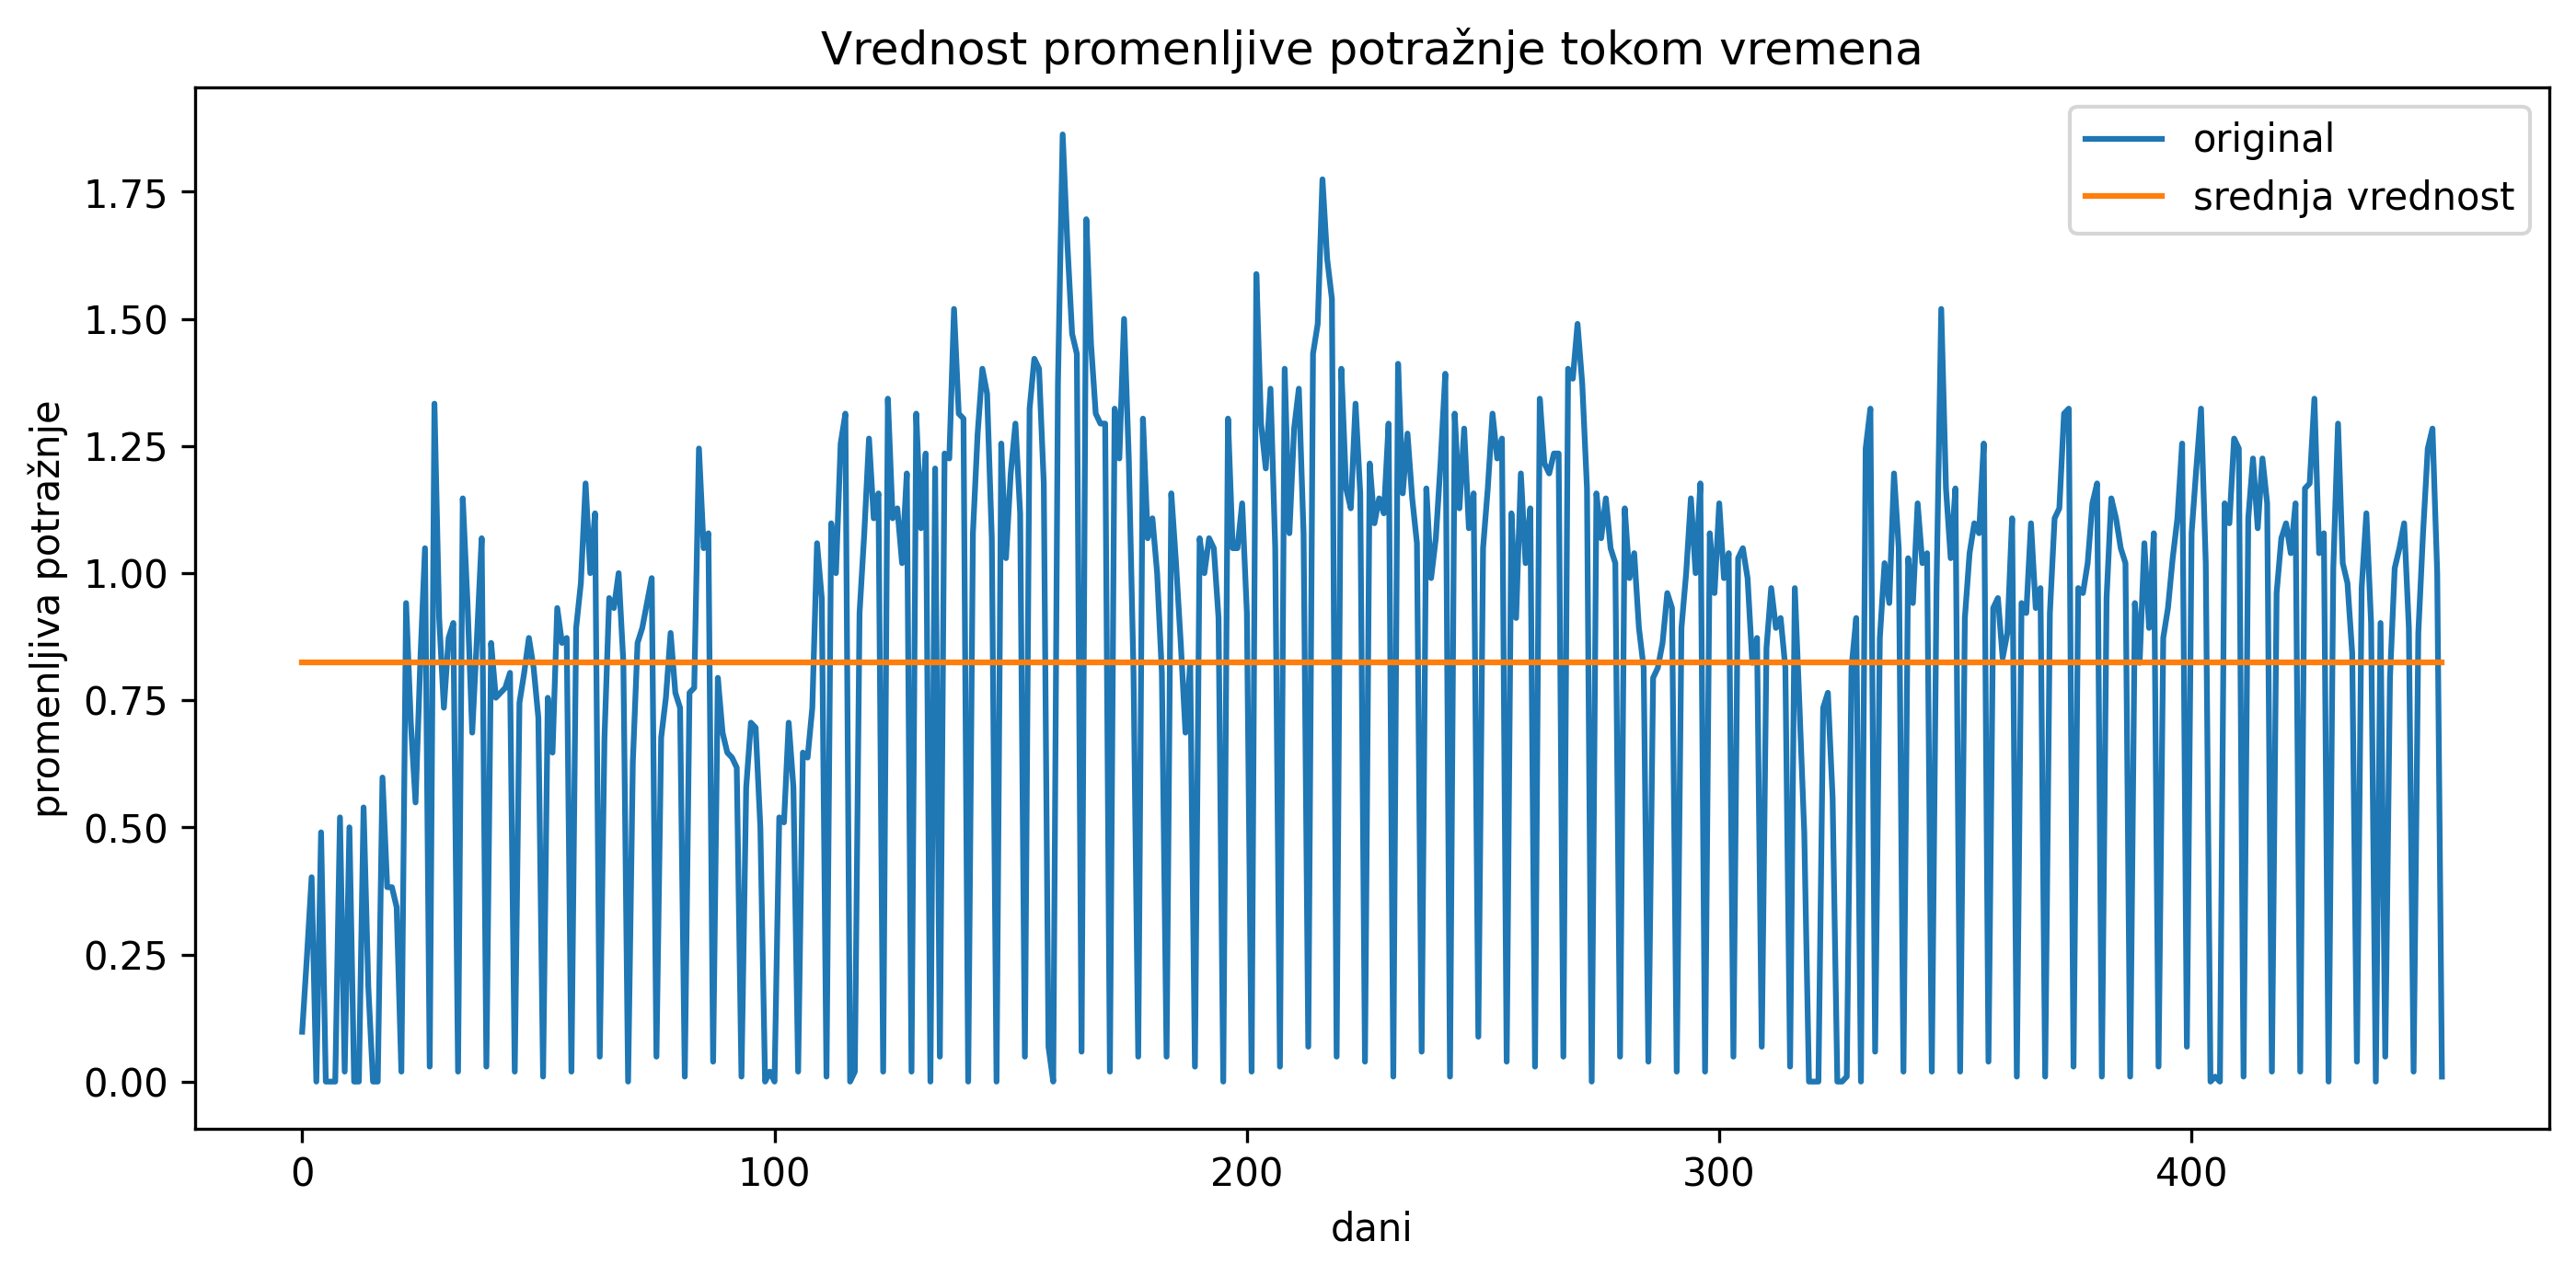

In [19]:
plot_timeseries(no_sundays_data)

<AxesSubplot:>

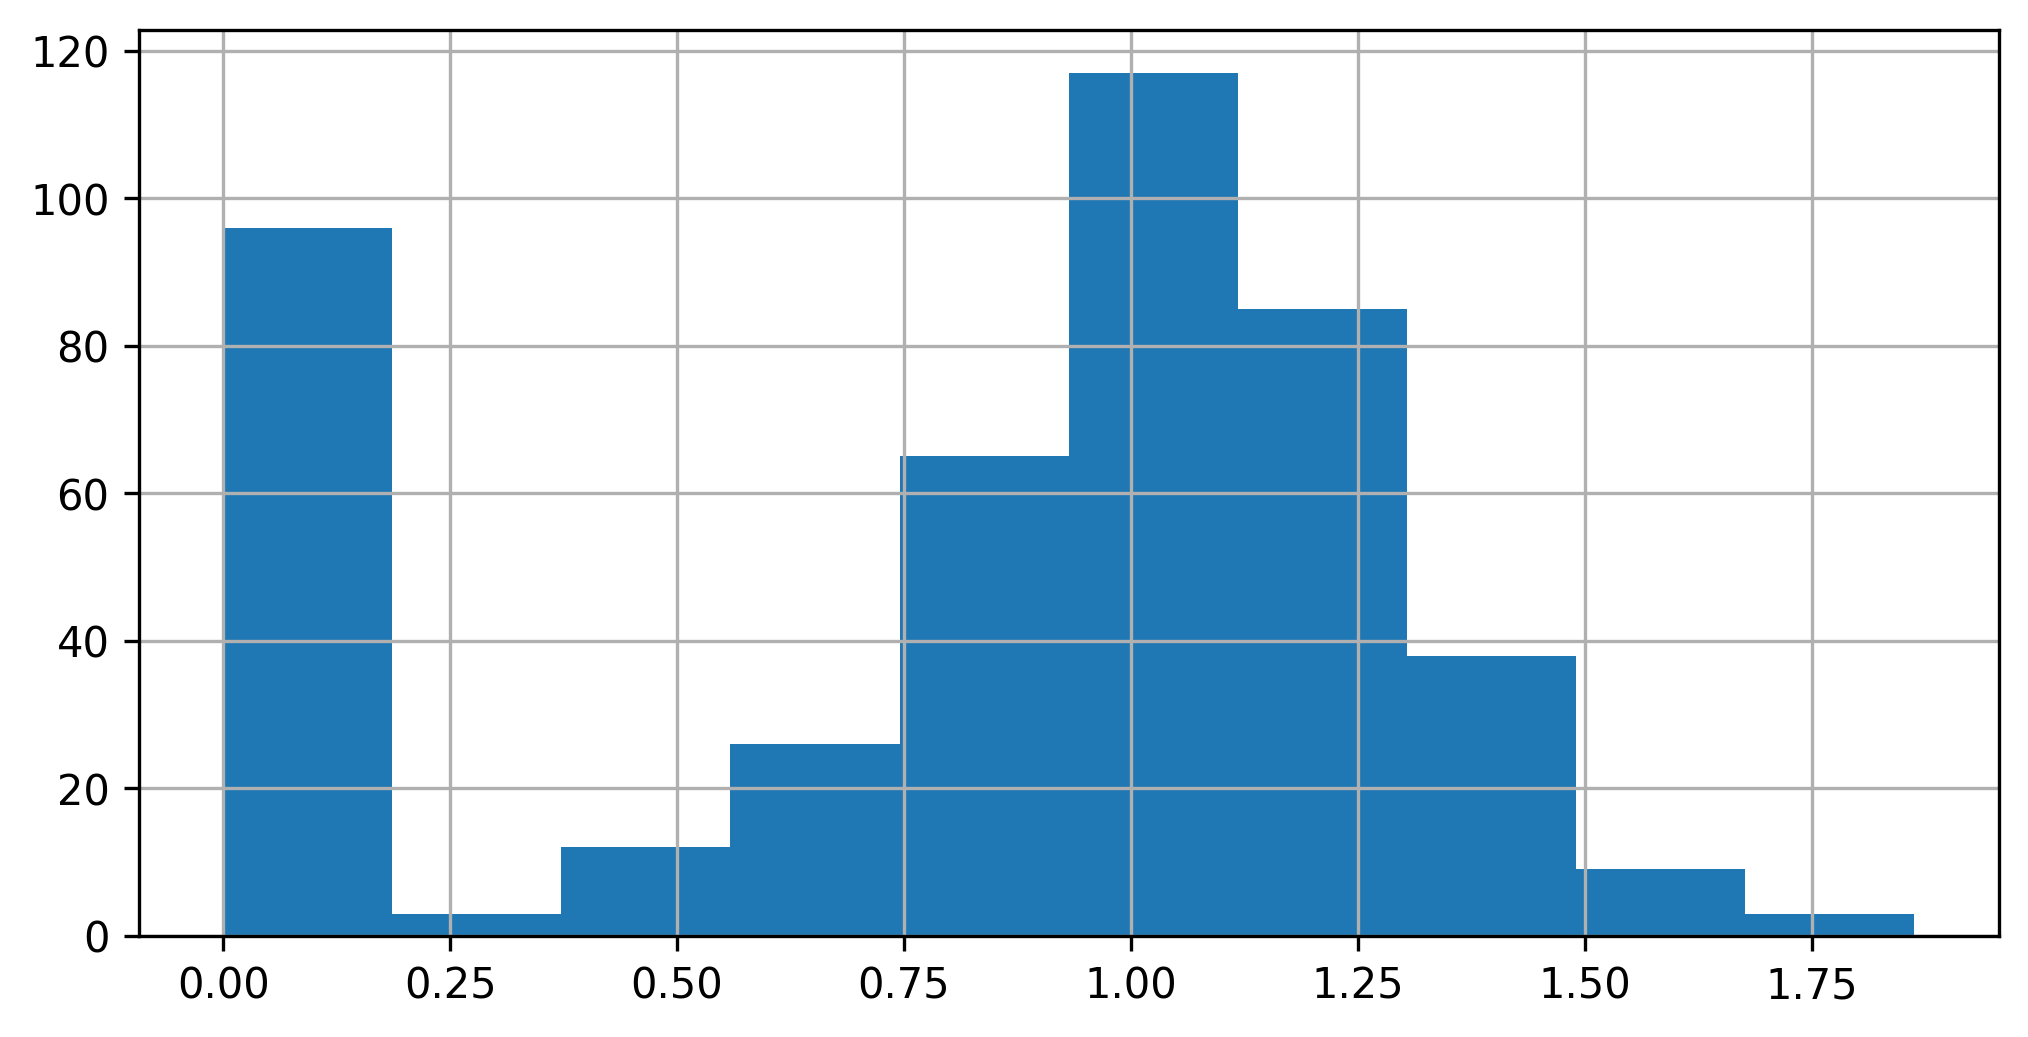

In [20]:
plt.figure(figsize=(8, 4))
no_sundays_data['demand_value'].hist()

In [21]:
95 / 454 
# 20% podataka (dana) imaju jako male vrednosti demand_target, što nam kvari malo raspodelu :/
# možda bi bilo dobro u nekom trenutku odbaciti ove dane
# za sada ih zadržavamo i radimo sa njima!

0.2092511013215859

In [22]:
X = no_sundays_data['demand_value']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print(f'srednja_vrednost_1 = {np.round(mean1, 3)}, srednja_vrednost_2 = {np.round(mean2, 3)}')
print(f'varijansa_1 = {np.round(var1, 3)}, varijansa_2 = {np.round(var2, 3)}')

srednja_vrednost_1 = 0.7929999828338623, srednja_vrednost_2 = 0.8539999723434448
varijansa_1 = 0.2460000067949295, varijansa_2 = 0.1979999989271164


#### Augmented Dickey-Fuller test

"Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. 
The result must be interpreted for a given problem to be meaningful." 

[https://machinelearningmastery.com/time-series-data-stationary-python/]


Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

[http://article.ajostatistics.org/pdf/10.11648.j.ajtas.20150401.13.pdf]

In [23]:
result = adfuller(no_sundays_data['demand_value'])
print(f'test statistics: {result[0]}')
print(f'p-value: {result[1]}')
print('Kritične vrednosti:')
for key, value in result[4].items():
    print(f'\t{key}: {np.round(value, 4)}')

test statistics: -3.6747806804586336
p-value: 0.004482199717310264
Kritične vrednosti:
	1%: -3.4455
	5%: -2.8682
	10%: -2.5703


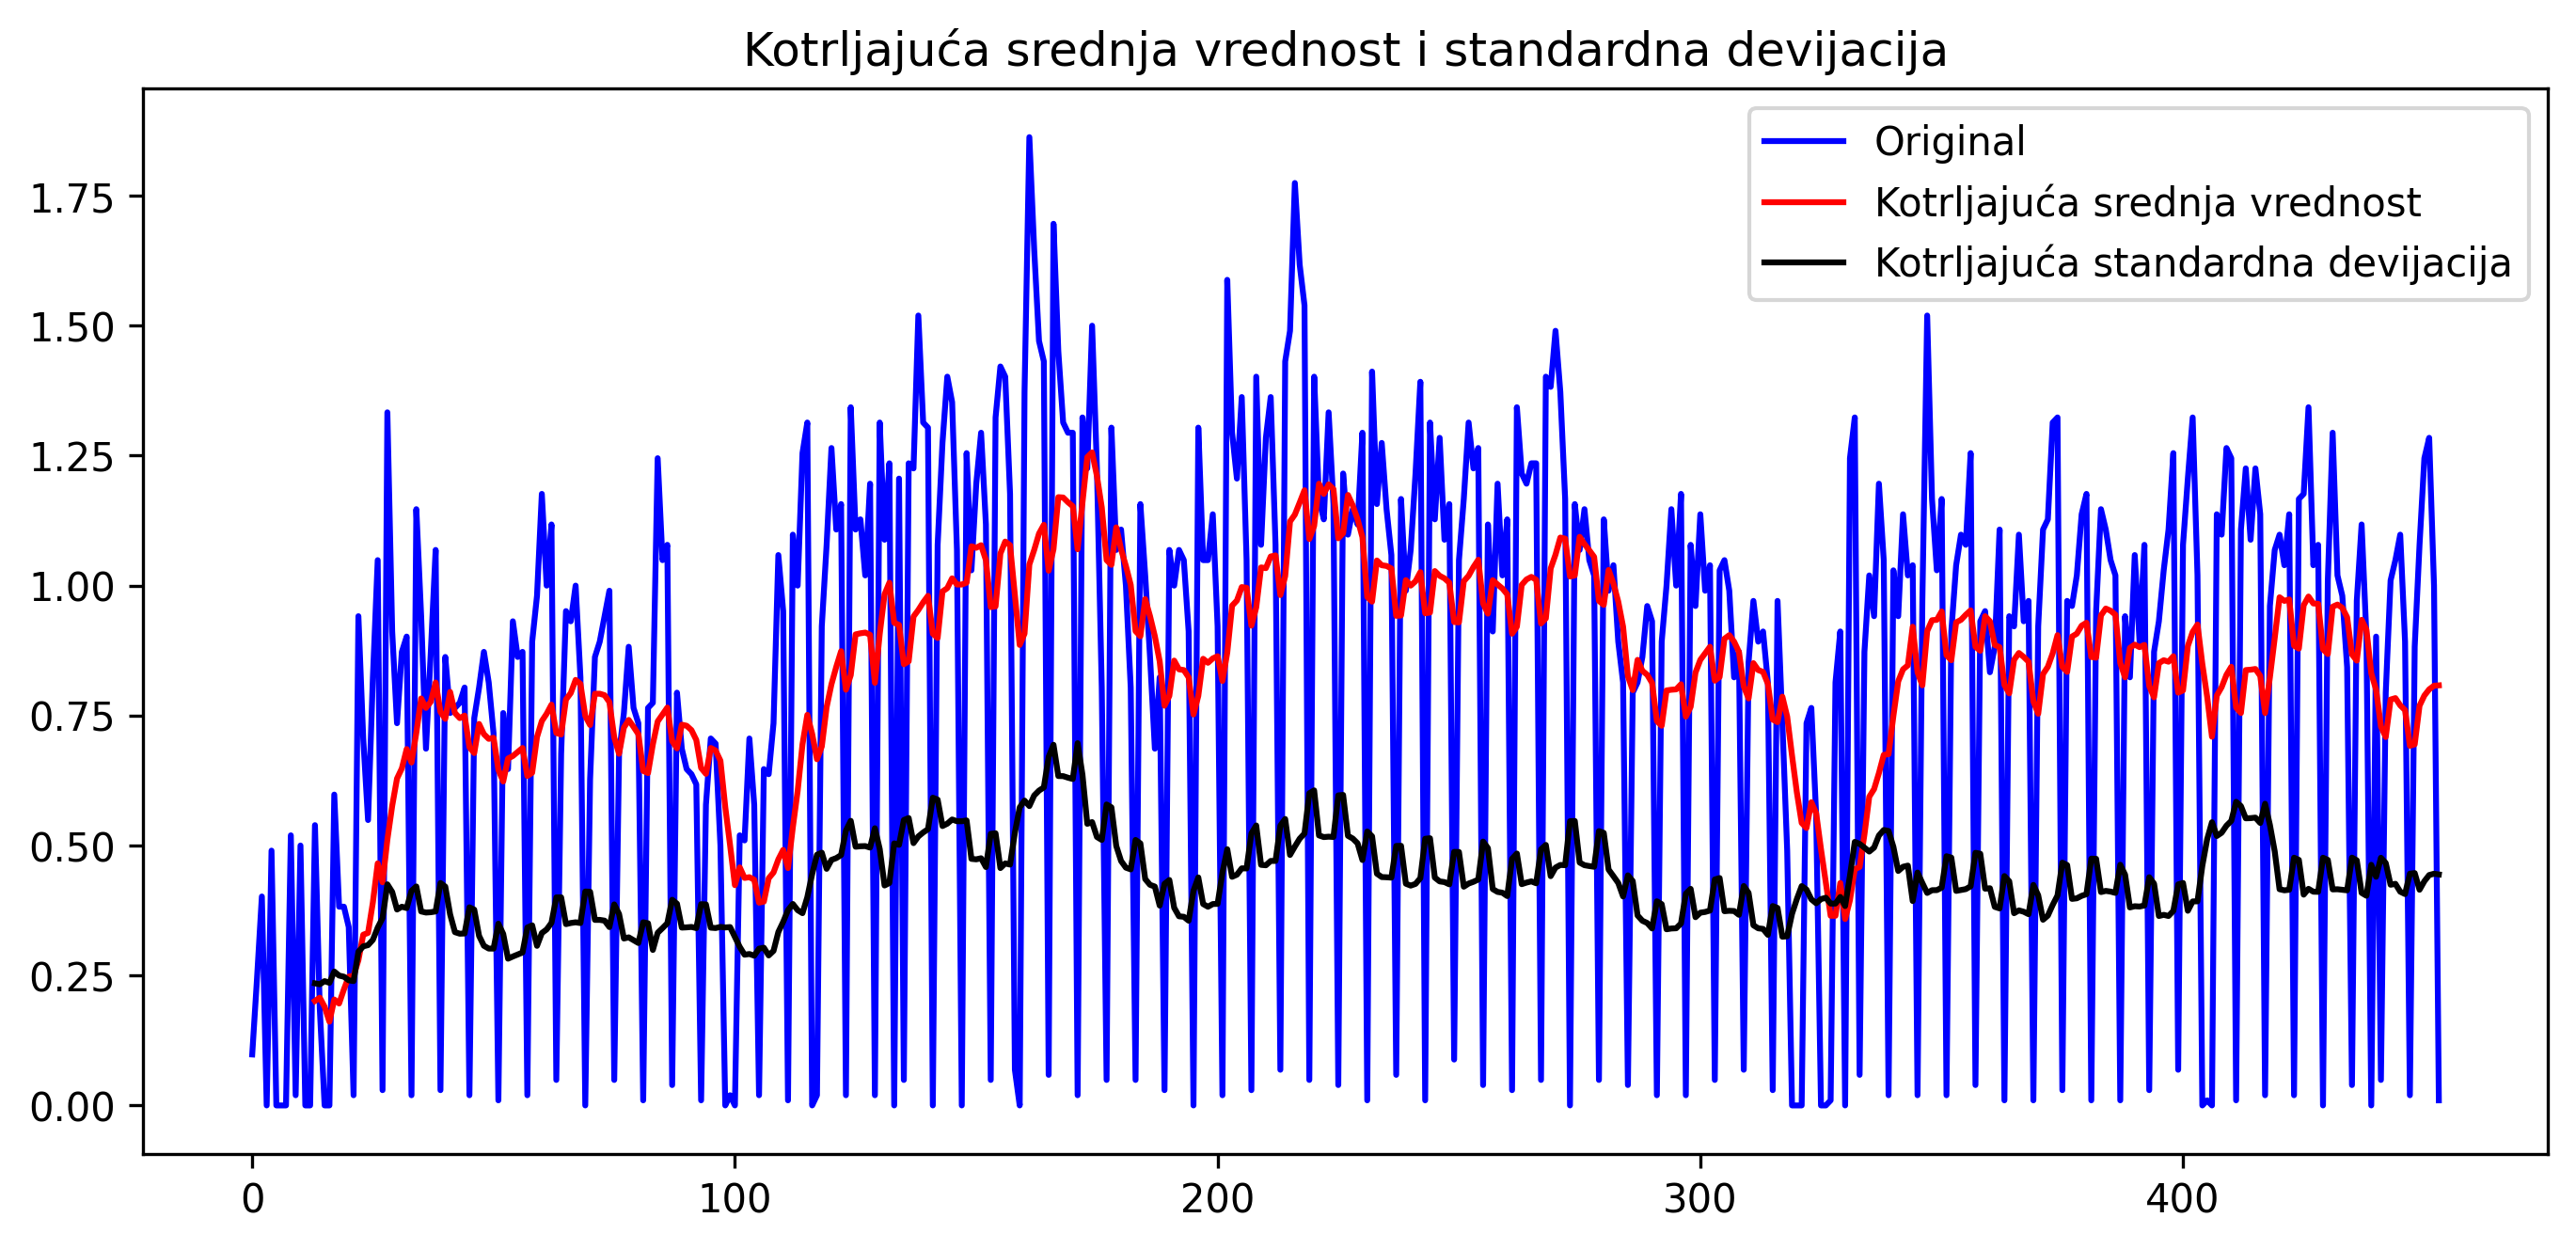

Rezultati Dickey-Fuller Testa
Test Statistics                 -3.674781
p-value                          0.004482
No. of lags used                18.000000
Number of observations used    435.000000
critical value (1%)             -3.445473
critical value (5%)             -2.868207
critical value (10%)            -2.570321
dtype: float64


In [24]:
test_stationarity(no_sundays_data['demand_value'])

##### vremenska serija je stacionarna => d=0 i D=0

## koje vrednosti parametara p/q  i P/Q su najbolje?
- ovaj ACF plot ispod nam govori da imamo neki sezonski efekat

```
The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1)12 model will show:

// a spike at lag 12 in the ACF but no other significant spikes;
// exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0)12 model will show:

// exponential decay in the seasonal lags of the ACF;
// a single significant spike at lag 12 in the PACF. 
```
[https://otexts.com/fpp2/seasonal-arima.html]

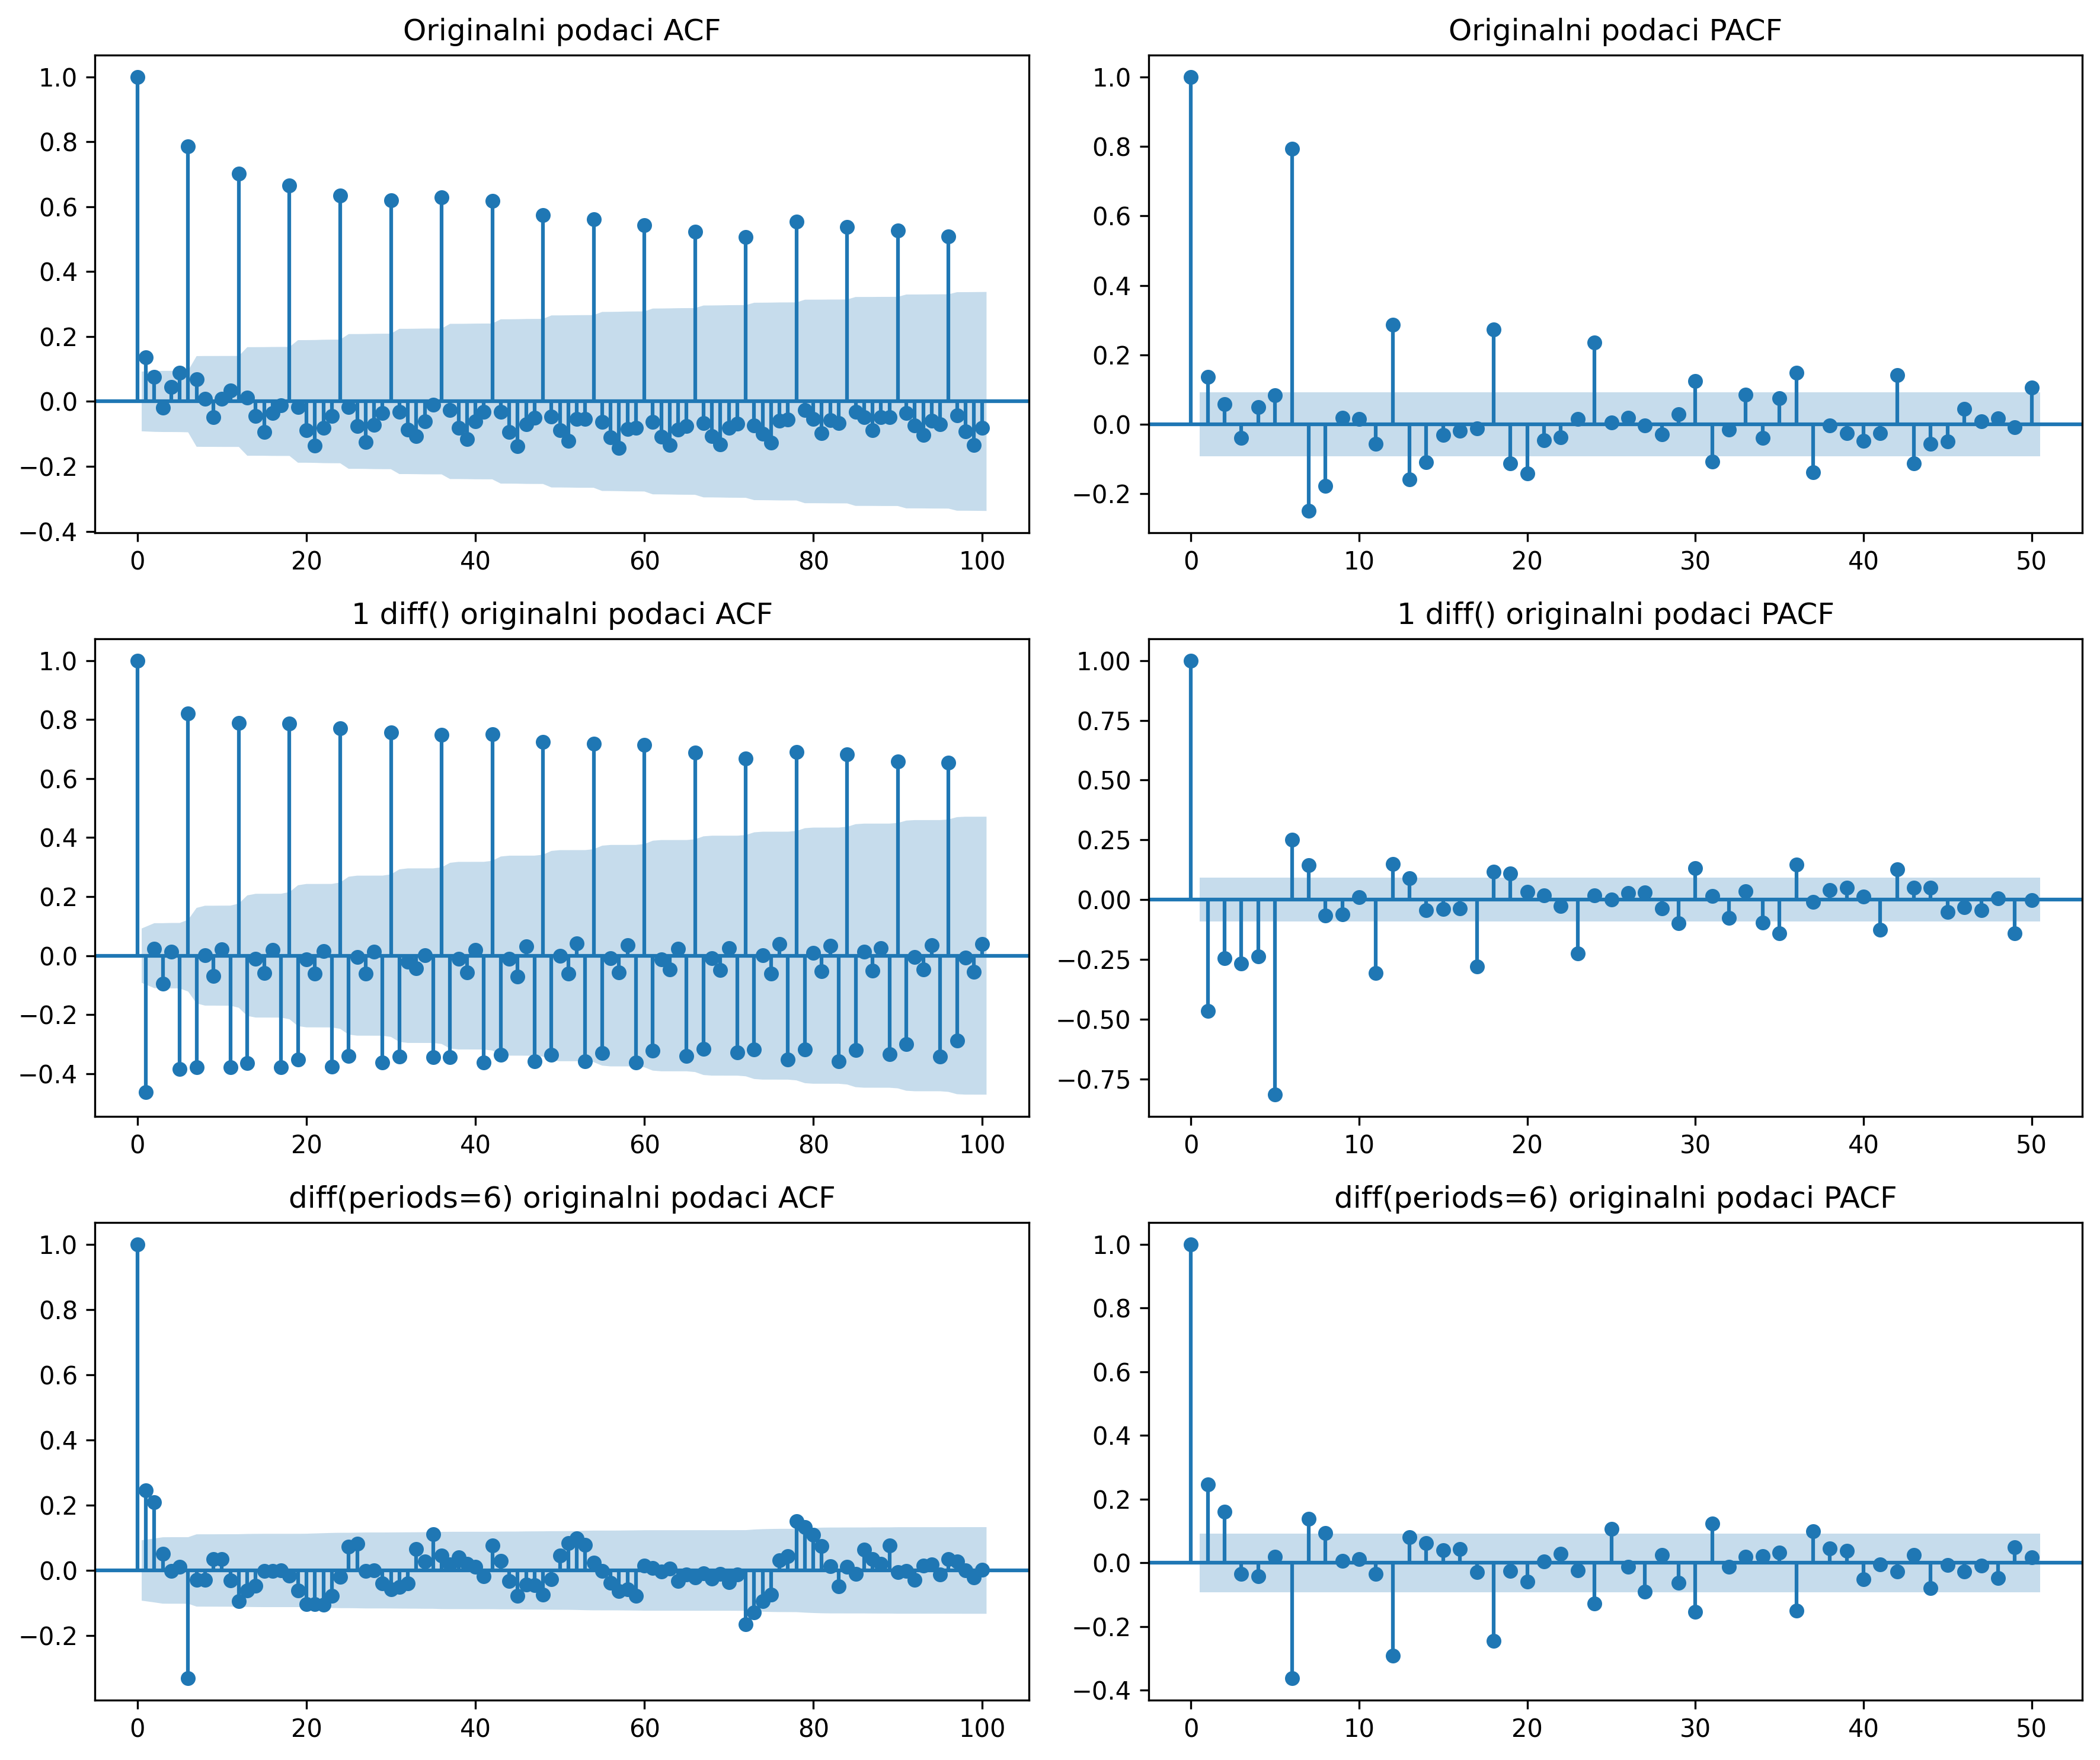

In [25]:
plot_acf_pacf(no_sundays_data, 
              diff_period=6, 
              lags_acf=100, 
              lags_pacf=50
             )

In [26]:
# iz ovih plotova, zaključujem da se radi o sezonskoj arimi, koja treba da ima P=1 i Q=1 za m=6, ili 
# samo Q=1, po uputstvu iz knjige

# takođe, iz pretposlednjeg plota se vidi da postoje i p i q parametri i da bi oni mogli da budu isto 1

In [27]:
# pokrećemo auto_arima funkciju paketa da nam pronađe parametre
auto_model = auto_arima(no_sundays_data, m=6)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  454
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 6)   Log Likelihood                   3.859
Date:                             Tue, 20 Jul 2021   AIC                              6.283
Time:                                     16:11:12   BIC                             35.110
Sample:                                          0   HQIC                            17.640
                                             - 454                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.002      1.109      0.267      -0.002       0.007
ar.L1          0.2982      0.031      9.607      0.000       0.237       0.359
ar.L2          0.2191      0.032      6.914      0.000       0.157       0.281
ar.S.L6        1.1560      0.055     21.182      0.000       1.049       1.263
ar.S.L12      -0.1638      0.052     -3.144      0.002      -0.266      -0.062
ma.S.L6       -0.8232      0.039    -21.313      0.000      -0.899      -0.747
sigma2         0.0561      0.002     26.052      0.000       0.052       0.060
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               512.25
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.78
Prob(H) (two-sided):                  0.87   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36974D-01    |proj g|=  1.42211D+00

At iterate    5    f=  2.23520D-02    |proj g|=  2.15798D-01

At iterate   10    f= -2.99880D-03    |proj g|=  6.12924D-02


 This problem is unconstrained.



At iterate   15    f= -3.25442D-03    |proj g|=  3.39892D-03

At iterate   20    f= -3.37695D-03    |proj g|=  5.36333D-02

At iterate   25    f= -4.63149D-03    |proj g|=  2.66485D-02

At iterate   30    f= -4.66825D-03    |proj g|=  1.33951D-03

At iterate   35    f= -4.67018D-03    |proj g|=  2.66038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     49      1     0     0   2.660D-04  -4.670D-03
  F =  -4.6701840660318700E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                      
Dep. Variable:       

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


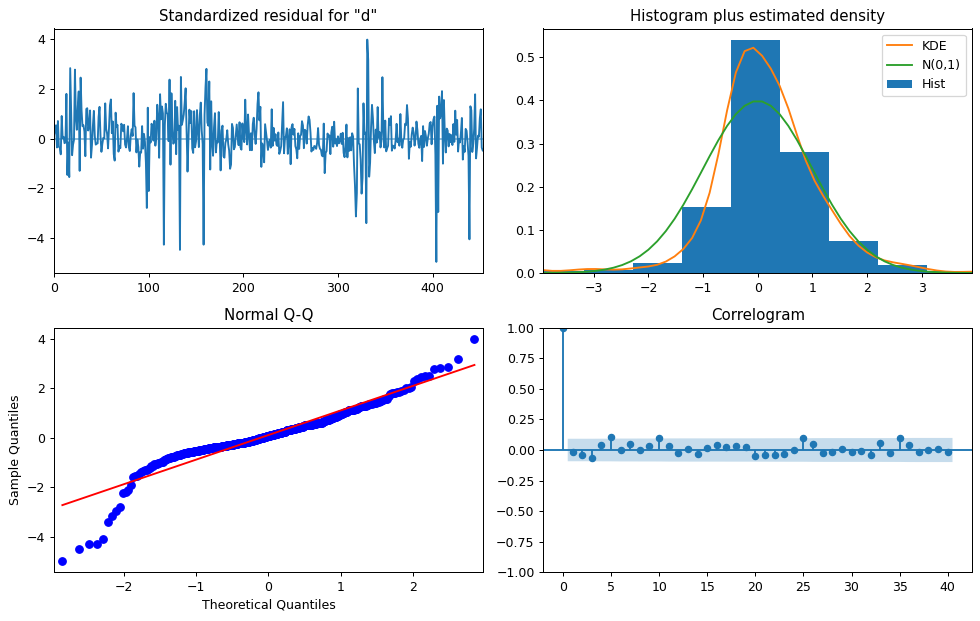

In [28]:
best_model = SARIMAX(no_sundays_data["demand_value"], 
                     order=(2, 0, 0),
                     seasonal_order=(2, 0, [1], 6)
                    ).fit()
print(best_model.summary())
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=40)
plt.tight_layout()

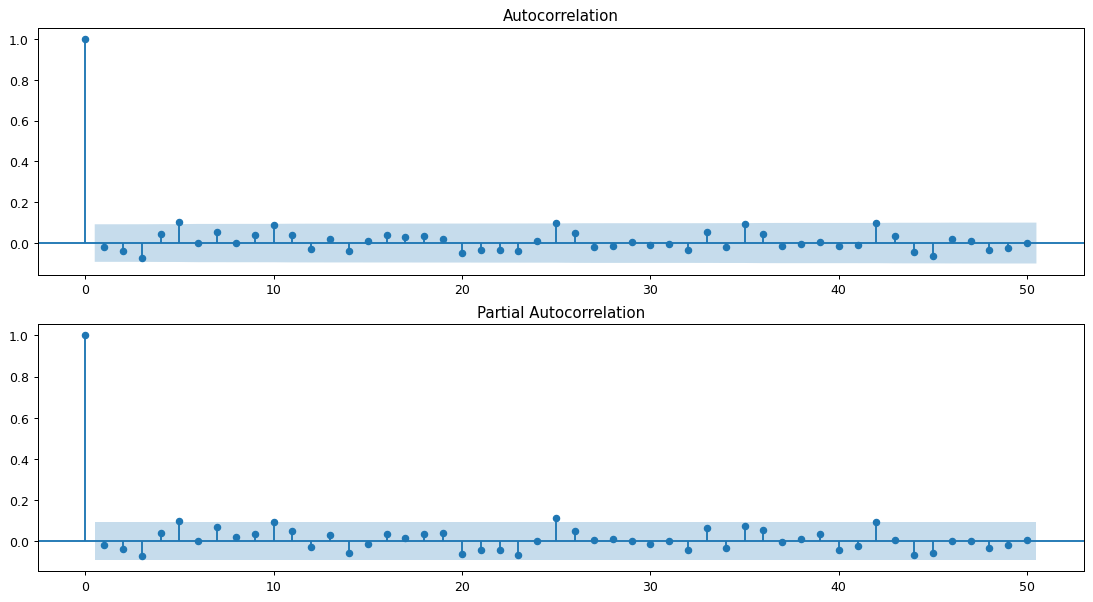

In [29]:
residuals = best_model.resid
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = plot_acf(residuals, lags=50, ax=ax[0])
fig = plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [30]:
pm.auto_arima(no_sundays_data["demand_value"], 
                               start_p=0,
                               start_q=0, 
                               max_p=10,
                               max_q=10, 
                               d=0,
                               max_d=3,
                               start_P=0,
                               max_P=5, start_Q=1, max_Q=5, max_D=3,
                               m=6,
                               stepwise=True, 
                               approximation=False,
                               seasonal=True,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=369.543, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=608.396, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=126.356, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=362.311, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=1242.636, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=601.856, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=84.632, Time=0.66 sec
 ARIMA(1,0,0)(3,0,0)[6] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(1,0,0)(2,0,1)[6] intercept   : AIC=26.393, Time=1.08 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=34.293, Time=0.58 sec
 ARIMA(1,0,0)(3,0,1)[6] intercept   : AIC=28.258, Time=1.69 sec
 ARIMA(1,0,0)(2,0,2)[6] intercept   : AIC=28.775, Time=1.21 sec
 ARIMA(1,0,0)(1,0,2)[6] intercept   : AIC=26.447, Time=1.02 sec
 ARIMA(1,0,0)(3,0,2)[6] intercept   : AIC=30.137, Time=2.26 sec
 ARIMA(0,0,0)(2,0,1)[6] intercept   : AIC=85.618, Time=0.

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 6),
      suppress_warnings=True)

In [31]:
arima_model = pm.auto_arima(no_sundays_data["demand_value"], 
                               start_p=0,
                               start_q=0, 
                               max_p=12,
                               max_q=12, 
                               d=0,
                               max_d=6,
                               stepwise=True, 
                               approximation=False,
                               seasonal=False,
                           trace=True,
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1242.636, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=803.953, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1041.851, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=726.640, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=707.564, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=680.555, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=658.079, Time=0.10 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=520.055, Time=0.20 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=552.055, Time=0.28 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=146.156, Time=0.42 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=138.850, Time=0.50 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=136.777, Time=0.58 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=inf, Time=0

In [32]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  454
Model:               SARIMAX(9, 0, 6)   Log Likelihood                  11.486
Date:                Tue, 20 Jul 2021   AIC                             11.027
Time:                        16:12:39   BIC                             81.035
Sample:                             0   HQIC                            38.610
                                - 454                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1764      0.109      1.614      0.107      -0.038       0.391
ar.L1         -0.0218      0.147     -0.148      0.882      -0.310       0.267
ar.L2          0.0833      0.123      0.677      0.499      -0.158       0.325
ar.L3         -0.1223      0.095     -1.291      0.197      -0.308       0.063
ar.L4         -0.0317      0.023     -1.381      0.167      -0.077       0.013
ar.L5         -0.0395      0.022     -1.757      0.079      -0.083       0.005
ar.L6          0.9531      0.024     40.209      0.000       0.907       1.000
ar.L7         -0.0158      0.127     -0.124      0.901      -0.265       0.233
ar.L8         -0.1171      0.103     -1.143      0.253      -0.318       0.084
ar.L9          0.0923      0.081      1.143      0.253      -0.066       0.251
ma.L1          0.3061      0.145      2.115      0.034       0.022       0.590
ma.L2          0.1978      0.156      1.267      0.205      -0.108       0.504
ma.L3          0.1810      0.142      1.277      0.202      -0.097       0.459
ma.L4          0.2249      0.105      2.147      0.032       0.020       0.430
ma.L5          0.2594      0.097      2.662      0.008       0.068       0.450
ma.L6         -0.5718      0.106     -5.401      0.000      -0.779      -0.364
sigma2         0.0544      0.003     20.007      0.000       0.049       0.060
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               524.35
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.87
Prob(H) (two-sided):                  0.87   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                               SARIMAX Results                                
Dep. Variable:           demand_value   No. Observations:                  454
Model:                 ARIMA(9, 0, 6)   Log Likelihood                  10.615
Date:                Tue, 20 Jul 2021   AIC                             12.771
Time:                        16:12:41   BIC                             82.778
Sample:                             0   HQIC                            40.353
                                - 454                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8065      0.082      9.833      0.000       0.646       0.967
ar.L1          0.0002      0.150      0.001      0.999      -0.294       0.294
ar.L2          0.0955      0.125      0.762      0.4

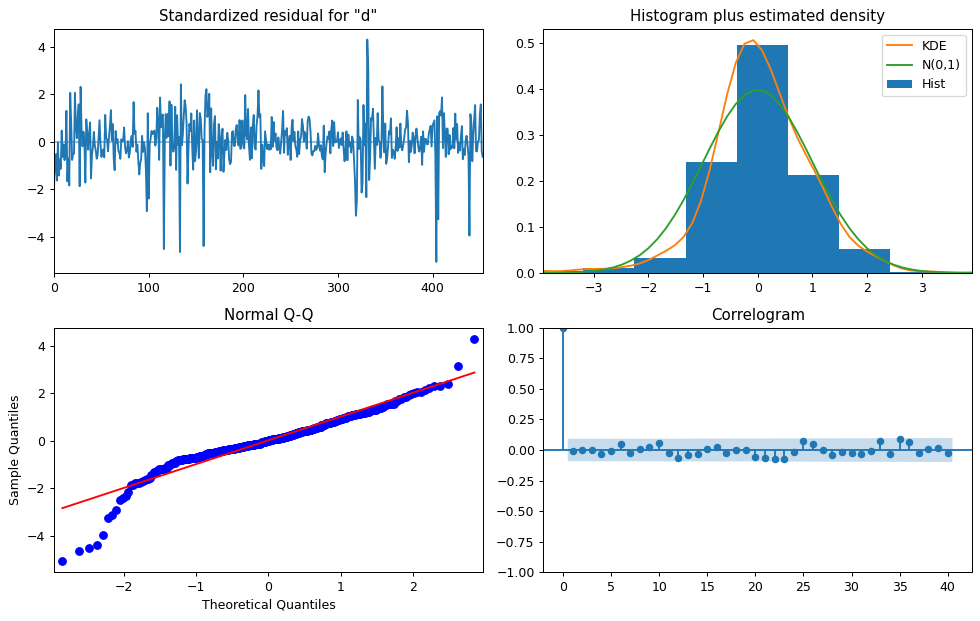

In [33]:
best_model = ARIMA(no_sundays_data["demand_value"], 
                     order=(9, 0, 6),
                    ).fit()
print(best_model.summary())
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=40)
plt.tight_layout()

In [34]:
def run_arima(arima_train_pd, 
              arima_test_pd, 
              model_info, 
              look_ahead=1):
    
    arima_train = arima_train_pd['demand_value'].values
    arima_test = arima_test_pd['demand_value'].values

    history = arima_train.copy()
    predictions = []

    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    
    for instance in range(len(arima_test_pd)):
        model = eval(model_info)
        model_fit = model.fit()

        start_date = arima_test_pd.iloc[instance]['date']
        
        future_to_predict = [start_date]
        step = 1
        count = 1
        while count < look_ahead:
            current_date = start_date + datetime.timedelta(days=step)
            if current_date.day_name() in days:
                count += 1
                future_to_predict.append(current_date)
            step += 1
            
        output = model_fit.forecast(look_ahead)

        # forecast [0]
        # stderr   [1]
        # conf_int [2]
        if 'SARIMAX' in model_info:
            yhat = output
        else:
            yhat = output

        date_prediction = list(zip(future_to_predict, yhat))

        predictions.append(date_prediction)

        history = np.append(history, arima_test_pd.iloc[instance]['demand_value'])

    return predictions, arima_train_pd, arima_test_pd, model_fit

def run_model(model_info, 
              data_sorted_by_date, 
              date_col="year_week", 
              date_to_start="202109", 
              look_ahead=1):
    
    train_pd = data_sorted_by_date[data_sorted_by_date[date_col] < date_to_start]
    test_pd =  data_sorted_by_date[data_sorted_by_date[date_col] >= date_to_start]

    if ('ARIMA' in model_info) or ("SARIMAX" in model_info):
        print("Arima/Sarima")
        arima_predictions, arima_train_pd, arima_test_pd, arima_model = run_arima(train_pd, 
                                                                                  test_pd, 
                                                                                  model_info, 
                                                                                  look_ahead)
        return arima_predictions, arima_model

#     elif 'Prophet' in model_info:
#         print("Prophet")
#         prophet_predictions, prophet_forecasts_df, prophet_train_pd, prophet_test_pd, prophet_model = run_prophet(train_pd, test_pd, model_info, look_ahead)
#         return prophet_predictions, prophet_model

    else:
        print(f"That model ({model_info}) is not supported.")

In [45]:
models = {
#   "arima_24_0_2": "ARIMA(history, order=(24, 0, 2))",
  "arima_1_0_1": "ARIMA(history, order=(1, 0, 1))",
  "arima_1_0_0": "ARIMA(history, order=(1, 0, 0))",  
  "arima_6_0_6": "ARIMA(history, order=(6, 0, 6))",
  "arima_9_0_6": "ARIMA(history, order=(9, 0, 6))",
  "sarima_1_0_1_1_0_[1,2]_6": "SARIMAX(history, order=(1, 0, 1), seasonal_order=(1, 0, [1,2], 6), enforce_stationary=True)",
  "sarima_2_0_0_2_0_[1]_6": "SARIMAX(history, order=(2, 0, 0), seasonal_order=(2, 0, [1], 6), enforce_stationary=True)",  
  "sarima_0_0_2_0_0_1_6": "SARIMAX(history, order=(0, 0, 2), seasonal_order=(0, 0, 1, 6), enforce_stationary=True)",
}

results = {}

date_to_start = "2021-03-01"
look_ahead = 28 #dana

for model_name, model_info in models.items():
    print(model_info)  
    run_returned = run_model(model_info=model_info, 
                             data_sorted_by_date=no_sundays_data, 
                             date_col="date", 
                             date_to_start=date_to_start, 
                             look_ahead=look_ahead)
    
    results[model_name] = run_returned
    print()
    
T_data = {}

for model_name in results.keys():
    for i in range(look_ahead):
        T_data[f'model__{model_name}__T{i+1}'] = [x[i] for x in results[model_name][0]]
    
final_df = no_sundays_data.copy()

for model_name in T_data.keys():
    example_df = pd.DataFrame()
    example_df['date'] = [x[0] for x in T_data[model_name]]
    example_df[model_name] = [x[1] for x in T_data[model_name]]
  
    final_df = final_df.merge(example_df, on='date', how='left')

ARIMA(history, order=(1, 0, 1))
Arima/Sarima

ARIMA(history, order=(1, 0, 0))
Arima/Sarima

ARIMA(history, order=(6, 0, 6))
Arima/Sarima


/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like


ARIMA(history, order=(9, 0, 6))
Arima/Sarima


/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like


SARIMAX(history, order=(1, 0, 1), seasonal_order=(1, 0, [1,2], 6), enforce_stationary=True)
Arima/Sarima
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00657D-01    |proj g|=  1.50683D+00

At iterate    5    f= -1.09599D-02    |proj g|=  1.27808D-01

At iterate   10    f= -1.22143D-02    |proj g|=  3.13695D-03

At iterate   15    f= -1.23347D-02    |proj g|=  5.54321D-03

At iterate   20    f= -1.54398D-02    |proj g|=  2.82451D-02

At iterate   25    f= -2.41633D-02    |proj g|=  1.90394D-03

At iterate   30    f= -2.41724D-02    |proj g|=  5.75540D-03

At iterate   35    f= -2.42699D-02    |proj g|=  1.19328D-02

At iterate   40    f= -2.42793D-02    |proj g|=  2.52684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip 

 This problem is unconstrained.



At iterate    5    f= -1.24852D-02    |proj g|=  8.59007D-02

At iterate   10    f= -1.32417D-02    |proj g|=  3.08149D-03

At iterate   15    f= -1.33783D-02    |proj g|=  1.59201D-02

At iterate   20    f= -1.34796D-02    |proj g|=  1.91774D-02

At iterate   25    f= -1.61611D-02    |proj g|=  2.50143D-01

At iterate   30    f= -2.39433D-02    |proj g|=  1.37496D-01

At iterate   35    f= -2.54677D-02    |proj g|=  1.96252D-03

At iterate   40    f= -2.55356D-02    |proj g|=  2.36779D-02

At iterate   45    f= -2.55582D-02    |proj g|=  2.56512D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     63   

 This problem is unconstrained.



At iterate    5    f= -1.32238D-02    |proj g|=  7.01300D-02

At iterate   10    f= -1.37636D-02    |proj g|=  4.14169D-03

At iterate   15    f= -1.39280D-02    |proj g|=  7.15854D-03

At iterate   20    f= -1.69092D-02    |proj g|=  4.69347D-02

At iterate   25    f= -2.60043D-02    |proj g|=  7.24374D-02

At iterate   30    f= -2.62886D-02    |proj g|=  2.74578D-04

At iterate   35    f= -2.63445D-02    |proj g|=  4.40093D-03

At iterate   40    f= -2.63792D-02    |proj g|=  1.62628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     59      1     0     0   2.228D-06  -2.638D-02
  F =  -2.63791943339

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97971D-01    |proj g|=  1.51050D+00

At iterate    5    f= -1.44987D-02    |proj g|=  6.37628D-02

At iterate   10    f= -1.49007D-02    |proj g|=  1.01671D-02

At iterate   15    f= -1.53521D-02    |proj g|=  2.71824D-02

At iterate   20    f= -2.09503D-02    |proj g|=  6.42190D-02

At iterate   25    f= -2.76343D-02    |proj g|=  5.57506D-03

At iterate   30    f= -2.76600D-02    |proj g|=  2.25978D-03

At iterate   35    f= -2.77470D-02    |proj g|=  1.32375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -1.57803D-02    |proj g|=  5.69877D-02

At iterate   10    f= -1.60916D-02    |proj g|=  1.06482D-02

At iterate   15    f= -1.65499D-02    |proj g|=  1.49788D-02

At iterate   20    f= -2.17476D-02    |proj g|=  6.53872D-02

At iterate   25    f= -2.89147D-02    |proj g|=  2.66276D-03

At iterate   30    f= -2.89219D-02    |proj g|=  7.71796D-04

At iterate   35    f= -2.89979D-02    |proj g|=  3.71344D-03

At iterate   40    f= -2.90144D-02    |proj g|=  9.34835D-05

At iterate   45    f= -2.90144D-02    |proj g|=  3.40168D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     61   

 This problem is unconstrained.



At iterate    5    f= -1.68453D-02    |proj g|=  5.00497D-02

At iterate   10    f= -1.72611D-02    |proj g|=  1.05839D-02

At iterate   15    f= -1.76121D-02    |proj g|=  7.54032D-03

At iterate   20    f= -2.13622D-02    |proj g|=  1.99884D-01

At iterate   25    f= -3.02271D-02    |proj g|=  1.14592D-02

At iterate   30    f= -3.02434D-02    |proj g|=  9.02490D-04

At iterate   35    f= -3.02510D-02    |proj g|=  1.64511D-02

At iterate   40    f= -3.03270D-02    |proj g|=  6.54270D-03

At iterate   45    f= -3.03304D-02    |proj g|=  1.64392D-03

At iterate   50    f= -3.03316D-02    |proj g|=  8.10530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -1.84382D-02    |proj g|=  6.27752D-02

At iterate   10    f= -1.88654D-02    |proj g|=  1.04741D-02

At iterate   15    f= -1.93023D-02    |proj g|=  2.25121D-02

At iterate   20    f= -2.54626D-02    |proj g|=  6.94453D-02

At iterate   25    f= -3.14249D-02    |proj g|=  5.95794D-03

At iterate   30    f= -3.14397D-02    |proj g|=  1.87329D-03

At iterate   35    f= -3.15225D-02    |proj g|=  6.83046D-03

At iterate   40    f= -3.15662D-02    |proj g|=  8.82440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     58      1     0     0   6.292D-06  -3.157D-02
  F =  -3.15662028448

 This problem is unconstrained.



At iterate    5    f= -1.96020D-02    |proj g|=  5.74264D-02

At iterate   10    f= -1.99158D-02    |proj g|=  2.14967D-02

At iterate   15    f= -2.04444D-02    |proj g|=  1.04000D-01

At iterate   20    f= -2.83477D-02    |proj g|=  1.52678D-01

At iterate   25    f= -3.28061D-02    |proj g|=  1.62645D-02

At iterate   30    f= -3.28441D-02    |proj g|=  7.70243D-03

At iterate   35    f= -3.29207D-02    |proj g|=  3.27154D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     59      1     0     0   8.200D-06  -3.292D-02
  F =  -3.2920763415627559E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f= -2.07897D-02    |proj g|=  1.19213D-02

At iterate   15    f= -2.11673D-02    |proj g|=  1.77460D-02

At iterate   20    f= -2.58547D-02    |proj g|=  9.08285D-02

At iterate   25    f= -3.31109D-02    |proj g|=  5.11201D-02

At iterate   30    f= -3.35925D-02    |proj g|=  2.94555D-04

At iterate   35    f= -3.36343D-02    |proj g|=  3.47602D-03

At iterate   40    f= -3.36995D-02    |proj g|=  3.98788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     0     0   9.687D-06  -3.370D-02
  F =  -3.3699537405709849E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f= -2.19365D-02    |proj g|=  4.45396D-03

At iterate   15    f= -2.21886D-02    |proj g|=  6.01823D-03

At iterate   20    f= -2.62803D-02    |proj g|=  5.42382D-02

At iterate   25    f= -3.47473D-02    |proj g|=  1.57551D-02

At iterate   30    f= -3.47751D-02    |proj g|=  2.89097D-04

At iterate   35    f= -3.47800D-02    |proj g|=  7.53496D-03

At iterate   40    f= -3.48593D-02    |proj g|=  2.95719D-03

At iterate   45    f= -3.48668D-02    |proj g|=  5.68209D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     64      1     0     0   3.179D-04  -3.487D-02
  F =  -3.48682138427

 This problem is unconstrained.



At iterate    5    f= -2.27254D-02    |proj g|=  4.71118D-02

At iterate   10    f= -2.31986D-02    |proj g|=  9.01332D-03

At iterate   15    f= -2.39470D-02    |proj g|=  6.96607D-02

At iterate   20    f= -2.72637D-02    |proj g|=  7.18429D-02

At iterate   25    f= -3.60027D-02    |proj g|=  2.89441D-02

At iterate   30    f= -3.60968D-02    |proj g|=  2.66988D-04

At iterate   35    f= -3.61465D-02    |proj g|=  5.43657D-03

At iterate   40    f= -3.61878D-02    |proj g|=  8.59867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     56      1     0     0   1.020D-05  -3.619D-02
  F =  -3.61878538192

 This problem is unconstrained.



At iterate   10    f= -2.37227D-02    |proj g|=  1.61254D-02

At iterate   15    f= -2.39975D-02    |proj g|=  1.51680D-02

At iterate   20    f= -2.41722D-02    |proj g|=  7.21663D-03

At iterate   25    f= -2.42150D-02    |proj g|=  2.74505D-02

At iterate   30    f= -2.78804D-02    |proj g|=  3.27109D-01

At iterate   35    f= -3.46169D-02    |proj g|=  4.64778D-02

At iterate   40    f= -3.72055D-02    |proj g|=  1.16105D-03

At iterate   45    f= -3.72127D-02    |proj g|=  2.75547D-04

At iterate   50    f= -3.72152D-02    |proj g|=  6.49228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -2.56893D-02    |proj g|=  5.02179D-02

At iterate   10    f= -2.60805D-02    |proj g|=  9.55906D-03

At iterate   15    f= -2.65765D-02    |proj g|=  9.42854D-03

At iterate   20    f= -2.89794D-02    |proj g|=  1.72865D-01

At iterate   25    f= -3.78946D-02    |proj g|=  6.38334D-02

At iterate   30    f= -3.84565D-02    |proj g|=  8.60727D-03

At iterate   35    f= -3.84598D-02    |proj g|=  1.48217D-03

At iterate   40    f= -3.85119D-02    |proj g|=  2.66347D-03

At iterate   45    f= -3.86058D-02    |proj g|=  2.50263D-03

At iterate   50    f= -3.86120D-02    |proj g|=  1.78538D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -2.65688D-02    |proj g|=  4.66645D-02

At iterate   10    f= -2.69900D-02    |proj g|=  1.05491D-02

At iterate   15    f= -2.77566D-02    |proj g|=  4.39734D-02

At iterate   20    f= -3.02945D-02    |proj g|=  7.25845D-02

At iterate   25    f= -3.95632D-02    |proj g|=  6.38863D-02

At iterate   30    f= -3.98123D-02    |proj g|=  3.28811D-04

At iterate   35    f= -3.98511D-02    |proj g|=  8.68645D-03

At iterate   40    f= -3.99436D-02    |proj g|=  2.11294D-03

At iterate   45    f= -3.99456D-02    |proj g|=  1.48405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     63   

 This problem is unconstrained.



At iterate   10    f= -2.64068D-02    |proj g|=  1.50574D-02

At iterate   15    f= -2.67034D-02    |proj g|=  1.96231D-02

At iterate   20    f= -2.68607D-02    |proj g|=  3.04626D-03

At iterate   25    f= -2.75558D-02    |proj g|=  1.32091D-01

At iterate   30    f= -3.50430D-02    |proj g|=  3.45099D-01

At iterate   35    f= -3.98290D-02    |proj g|=  3.89734D-02

At iterate   40    f= -3.98724D-02    |proj g|=  3.23362D-04

At iterate   45    f= -3.98885D-02    |proj g|=  1.57877D-02

At iterate   50    f= -3.99940D-02    |proj g|=  3.30463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -2.73057D-02    |proj g|=  1.56699D-02

At iterate   15    f= -2.76022D-02    |proj g|=  1.83588D-02

At iterate   20    f= -2.77742D-02    |proj g|=  4.90356D-03

At iterate   25    f= -2.91466D-02    |proj g|=  7.27243D-02

At iterate   30    f= -4.09133D-02    |proj g|=  2.20778D-02

At iterate   35    f= -4.09229D-02    |proj g|=  3.14915D-04

At iterate   40    f= -4.09599D-02    |proj g|=  6.02255D-03

At iterate   45    f= -4.10389D-02    |proj g|=  5.20579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     65      1     0     0   3.138D-06  -4.104D-02
  F =  -4.10414978423

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91235D-01    |proj g|=  1.52358D+00

At iterate    5    f= -7.46032D-03    |proj g|=  4.31468D-01

At iterate   10    f= -2.83823D-02    |proj g|=  1.08120D-02

At iterate   15    f= -2.86371D-02    |proj g|=  1.87844D-02

At iterate   20    f= -2.87993D-02    |proj g|=  8.03079D-03

At iterate   25    f= -3.57036D-02    |proj g|=  1.77918D-01

At iterate   30    f= -4.19515D-02    |proj g|=  2.17973D-02

At iterate   35    f= -4.20401D-02    |proj g|=  3.20892D-04

At iterate   40    f= -4.20423D-02    |proj g|=  8.83720D-03

At iterate   45    f= -4.21136D-02    |proj g|=  9.44166D-03

At iterate   50    f= -4.21596D-02    |proj g|=  1.79264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -2.94882D-02    |proj g|=  4.66533D-03

At iterate   15    f= -2.97376D-02    |proj g|=  7.46038D-03

At iterate   20    f= -3.04121D-02    |proj g|=  1.34953D-01

At iterate   25    f= -3.81829D-02    |proj g|=  2.49299D-01

At iterate   30    f= -4.31231D-02    |proj g|=  4.74522D-03

At iterate   35    f= -4.31552D-02    |proj g|=  1.57280D-03

At iterate   40    f= -4.32498D-02    |proj g|=  1.84174D-02

At iterate   45    f= -4.32608D-02    |proj g|=  3.63333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     62      1     0     0   2.479D-04  -4.326D-02
  F =  -4.32608403955

 This problem is unconstrained.



At iterate   10    f= -3.11739D-02    |proj g|=  1.38896D-02

At iterate   15    f= -3.14645D-02    |proj g|=  2.02243D-02

At iterate   20    f= -3.16384D-02    |proj g|=  6.78166D-03

At iterate   25    f= -3.19739D-02    |proj g|=  1.11562D-01

At iterate   30    f= -3.99269D-02    |proj g|=  4.13056D-01

At iterate   35    f= -4.42909D-02    |proj g|=  2.50919D-02

At iterate   40    f= -4.44063D-02    |proj g|=  3.70526D-04

At iterate   45    f= -4.44263D-02    |proj g|=  1.20383D-02

At iterate   50    f= -4.45644D-02    |proj g|=  1.17369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f= -3.25627D-02    |proj g|=  9.51883D-03

At iterate   20    f= -3.44124D-02    |proj g|=  4.30768D-02

At iterate   25    f= -4.26920D-02    |proj g|=  6.74203D-02

At iterate   30    f= -4.56988D-02    |proj g|=  2.21222D-03

At iterate   35    f= -4.57018D-02    |proj g|=  3.24579D-03

At iterate   40    f= -4.57687D-02    |proj g|=  7.84379D-03

At iterate   45    f= -4.58318D-02    |proj g|=  2.63593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     67      1     0     0   5.706D-06  -4.583D-02
  F =  -4.5831959614205595E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f= -3.35742D-02    |proj g|=  4.89186D-03

At iterate   15    f= -3.37415D-02    |proj g|=  2.86037D-02

At iterate   20    f= -3.38811D-02    |proj g|=  4.56329D-02

At iterate   25    f= -3.84557D-02    |proj g|=  5.44774D-01

At iterate   30    f= -4.69689D-02    |proj g|=  2.48645D-02

At iterate   35    f= -4.70023D-02    |proj g|=  3.30289D-04

At iterate   40    f= -4.70471D-02    |proj g|=  3.33944D-03

At iterate   45    f= -4.71344D-02    |proj g|=  3.84182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     60      1     0     0   6.217D-06  -4.713D-02
  F =  -4.71344319986

 This problem is unconstrained.



At iterate    5    f= -1.84449D-02    |proj g|=  5.09022D-01

At iterate   10    f= -3.45437D-02    |proj g|=  1.31170D-02

At iterate   15    f= -3.49426D-02    |proj g|=  1.49824D-02

At iterate   20    f= -3.81994D-02    |proj g|=  6.84174D-02

At iterate   25    f= -4.64369D-02    |proj g|=  1.39527D-01

At iterate   30    f= -4.82707D-02    |proj g|=  3.08382D-04

At iterate   35    f= -4.83453D-02    |proj g|=  4.72772D-03

At iterate   40    f= -4.83896D-02    |proj g|=  1.36997D-03

At iterate   45    f= -4.83901D-02    |proj g|=  5.51824D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     67   

 This problem is unconstrained.



At iterate    5    f= -2.34738D-02    |proj g|=  5.07834D-01

At iterate   10    f= -3.53009D-02    |proj g|=  1.85575D-02

At iterate   15    f= -3.56149D-02    |proj g|=  1.74239D-02

At iterate   20    f= -4.29898D-02    |proj g|=  5.73778D-02

At iterate   25    f= -4.85790D-02    |proj g|=  2.06442D-02

At iterate   30    f= -4.89888D-02    |proj g|=  1.20999D-03

At iterate   35    f= -4.90266D-02    |proj g|=  7.56386D-03

At iterate   40    f= -4.91029D-02    |proj g|=  1.41206D-03

At iterate   45    f= -4.91051D-02    |proj g|=  4.06199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     70   

 This problem is unconstrained.



At iterate    5    f= -2.81620D-02    |proj g|=  4.44507D-01

At iterate   10    f= -3.58467D-02    |proj g|=  1.44740D-02

At iterate   15    f= -3.61700D-02    |proj g|=  1.87363D-02

At iterate   20    f= -4.07822D-02    |proj g|=  1.64878D-01

At iterate   25    f= -4.95922D-02    |proj g|=  1.86738D-03

At iterate   30    f= -4.96143D-02    |proj g|=  4.70918D-03

At iterate   35    f= -4.96947D-02    |proj g|=  2.44002D-02

At iterate   40    f= -4.97181D-02    |proj g|=  1.41288D-04

At iterate   45    f= -4.97182D-02    |proj g|=  7.62523D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     60   

 This problem is unconstrained.



At iterate   10    f= -3.76155D-02    |proj g|=  6.95244D-03

At iterate   15    f= -3.78654D-02    |proj g|=  3.10061D-03

At iterate   20    f= -4.24641D-02    |proj g|=  2.24936D-01

At iterate   25    f= -5.06376D-02    |proj g|=  2.13804D-02

At iterate   30    f= -5.08307D-02    |proj g|=  3.42667D-04

At iterate   35    f= -5.09729D-02    |proj g|=  2.06200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     54      1     0     0   3.220D-05  -5.097D-02
  F =  -5.0973963825247236E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f= -3.84416D-02    |proj g|=  2.77213D-02

At iterate   20    f= -3.86548D-02    |proj g|=  1.72526D-02

At iterate   25    f= -4.28090D-02    |proj g|=  2.43413D-01

At iterate   30    f= -5.12300D-02    |proj g|=  1.25345D-01

At iterate   35    f= -5.17993D-02    |proj g|=  3.09876D-04

At iterate   40    f= -5.18310D-02    |proj g|=  1.63302D-02

At iterate   45    f= -5.19226D-02    |proj g|=  2.59414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     63      1     0     0   1.686D-05  -5.192D-02
  F =  -5.1922694643069610E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -3.90030D-02    |proj g|=  3.13084D-02

At iterate   15    f= -3.92778D-02    |proj g|=  2.87593D-02

At iterate   20    f= -3.93972D-02    |proj g|=  1.34952D-02

At iterate   25    f= -4.23010D-02    |proj g|=  1.89423D-01

At iterate   30    f= -5.11291D-02    |proj g|=  3.82846D-02

At iterate   35    f= -5.24822D-02    |proj g|=  3.23660D-04

At iterate   40    f= -5.24868D-02    |proj g|=  6.57451D-03

At iterate   45    f= -5.25901D-02    |proj g|=  4.13589D-03

At iterate   50    f= -5.26019D-02    |proj g|=  9.02157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -2.55381D-02    |proj g|=  5.19664D-01

At iterate   10    f= -3.93086D-02    |proj g|=  3.01512D-02

At iterate   15    f= -3.95432D-02    |proj g|=  2.62383D-02

At iterate   20    f= -3.97314D-02    |proj g|=  2.78330D-02

At iterate   25    f= -4.72044D-02    |proj g|=  2.78890D-01

At iterate   30    f= -5.27098D-02    |proj g|=  2.77998D-03

At iterate   35    f= -5.27181D-02    |proj g|=  2.78052D-04

At iterate   40    f= -5.27194D-02    |proj g|=  1.67688D-03

At iterate   45    f= -5.27316D-02    |proj g|=  4.99794D-03

At iterate   50    f= -5.28107D-02    |proj g|=  5.63205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89170D-01    |proj g|=  1.53362D+00

At iterate    5    f= -3.12685D-02    |proj g|=  4.65807D-01

At iterate   10    f= -4.02449D-02    |proj g|=  7.30153D-03

At iterate   15    f= -4.05024D-02    |proj g|=  4.53796D-02

At iterate   20    f= -4.50462D-02    |proj g|=  3.24163D-01

At iterate   25    f= -5.25480D-02    |proj g|=  1.06776D-01

At iterate   30    f= -5.33679D-02    |proj g|=  2.51040D-04

At iterate   35    f= -5.33692D-02    |proj g|=  5.68463D-03

At iterate   40    f= -5.34194D-02    |proj g|=  8.54273D-03

At iterate   45    f= -5.34532D-02    |proj g|=  2.37373D-03

At iterate   50    f= -5.34551D-02    |proj g|=  3.85806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -6.09392D-03    |proj g|=  1.20855D-01

At iterate   10    f= -7.64646D-03    |proj g|=  5.29977D-03

At iterate   15    f= -7.88406D-03    |proj g|=  6.92351D-03

At iterate   20    f= -1.05608D-02    |proj g|=  9.19002D-02

At iterate   25    f= -2.05051D-02    |proj g|=  1.73771D-02

At iterate   30    f= -2.05853D-02    |proj g|=  8.56656D-04

At iterate   35    f= -2.06800D-02    |proj g|=  7.15245D-03

At iterate   40    f= -2.07157D-02    |proj g|=  2.22056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     55      1     0     0   6.049D-05  -2.072D-02
  F =  -2.07157201299

 This problem is unconstrained.



At iterate    5    f= -7.99241D-03    |proj g|=  1.36482D-01

At iterate   10    f= -9.75512D-03    |proj g|=  5.19408D-03

At iterate   15    f= -9.88518D-03    |proj g|=  2.87231D-02

At iterate   20    f= -1.04154D-02    |proj g|=  5.44362D-02

At iterate   25    f= -1.82302D-02    |proj g|=  9.54772D-02

At iterate   30    f= -2.08125D-02    |proj g|=  1.48723D-02

At iterate   35    f= -2.08672D-02    |proj g|=  4.06618D-03

At iterate   40    f= -2.10170D-02    |proj g|=  2.26416D-02

At iterate   45    f= -2.10485D-02    |proj g|=  1.70804D-04

At iterate   50    f= -2.10486D-02    |proj g|=  1.57533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  4.70436D-03    |proj g|=  3.08048D-02

At iterate   15    f=  4.53596D-03    |proj g|=  2.87436D-02

At iterate   20    f=  4.23532D-03    |proj g|=  2.32066D-02

At iterate   25    f= -5.13645D-03    |proj g|=  6.53796D-02

At iterate   30    f= -7.58005D-03    |proj g|=  4.98268D-04

At iterate   35    f= -7.58073D-03    |proj g|=  4.75776D-04

At iterate   40    f= -7.60050D-03    |proj g|=  1.59216D-02

At iterate   45    f= -7.66504D-03    |proj g|=  3.44725D-03


/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -7.72193D-03    |proj g|=  2.47183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   2.472D-03  -7.722D-03
  F =  -7.7219264901503305E-003

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02429D-01    |proj g|=  1.48733D+00

At iterate    5    f=  2.65216D-02    |proj g|=  4.18760D-01

At iterate   10    f=  7.32246D-03    |proj g|=  4.19280D-03

At iter

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  7.19172D-03    |proj g|=  3.46276D-03

At iterate   15    f=  6.87225D-03    |proj g|=  1.10383D-02

At iterate   20    f=  1.49022D-03    |proj g|=  3.87417D-01

At iterate   25    f= -4.74927D-03    |proj g|=  4.61709D-04

At iterate   30    f= -4.75988D-03    |proj g|=  1.37790D-03

At iterate   35    f= -4.93779D-03    |proj g|=  7.92731D-03

At iterate   40    f= -4.97034D-03    |proj g|=  2.79143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     58      1     0     0   2.437D-05  -4.970D-03
  F =  -4.9704241916302570E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.01098D-02    |proj g|=  3.82229D-03

At iterate   15    f=  9.86781D-03    |proj g|=  1.26173D-02

At iterate   20    f=  9.73402D-03    |proj g|=  1.09942D-02

At iterate   25    f=  7.02107D-04    |proj g|=  6.99148D-02

At iterate   30    f= -2.68852D-03    |proj g|=  7.03410D-03

At iterate   35    f= -2.69718D-03    |proj g|=  2.69341D-03

At iterate   40    f= -2.77909D-03    |proj g|=  2.23301D-02

At iterate   45    f= -2.88694D-03    |proj g|=  5.34426D-03

At iterate   50    f= -2.90455D-03    |proj g|=  1.03975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  3.52749D-02    |proj g|=  3.24989D-01

At iterate   10    f=  1.55448D-02    |proj g|=  5.17205D-03

At iterate   15    f=  1.52737D-02    |proj g|=  1.04683D-02

At iterate   20    f=  1.39909D-02    |proj g|=  4.02548D-02

At iterate   25    f=  3.00027D-03    |proj g|=  6.74582D-02

At iterate   30    f=  2.18962D-03    |proj g|=  3.47747D-03

At iterate   35    f=  2.18659D-03    |proj g|=  3.31866D-03

At iterate   40    f=  2.10711D-03    |proj g|=  5.08060D-03

At iterate   45    f=  1.95066D-03    |proj g|=  4.42607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06150D-01    |proj g|=  1.47887D+00

At iterate    5    f=  1.43771D-02    |proj g|=  7.24426D-02

At iterate   10    f=  1.37268D-02    |proj g|=  3.37570D-02

At iterate   15    f=  1.34949D-02    |proj g|=  6.78275D-03

At iterate   20    f=  2.53491D-03    |proj g|=  3.30195D-02

At iterate   25    f=  1.62127D-03    |proj g|=  5.95575D-04

At iterate   30    f=  1.60462D-03    |proj g|=  2.92245D-03

At iterate   35    f=  1.27694D-03    |proj g|=  6.44623D-03

At iterate   40    f=  1.26829D-03    |proj g|=  1.55499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  1.64035D-02    |proj g|=  6.47772D-02

At iterate   10    f=  1.59042D-02    |proj g|=  7.37215D-03

At iterate   15    f=  1.28169D-02    |proj g|=  3.84376D-02

At iterate   20    f=  3.54012D-03    |proj g|=  4.75530D-03

At iterate   25    f=  3.51292D-03    |proj g|=  8.21967D-04

At iterate   30    f=  3.38687D-03    |proj g|=  1.24785D-02

At iterate   35    f=  3.17092D-03    |proj g|=  1.11233D-02

At iterate   40    f=  3.16670D-03    |proj g|=  4.05189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     55      1     0     0   1.085D-05   3.167D-03
  F =   3.16668894110

 This problem is unconstrained.



At iterate    5    f=  1.49795D-02    |proj g|=  6.47509D-02

At iterate   10    f=  1.46599D-02    |proj g|=  9.23657D-03

At iterate   15    f=  1.22712D-02    |proj g|=  1.60369D-02

At iterate   20    f=  4.82206D-03    |proj g|=  2.18273D-01

At iterate   25    f=  2.30819D-03    |proj g|=  2.31658D-02

At iterate   30    f=  2.25440D-03    |proj g|=  1.26214D-02

At iterate   35    f=  2.06312D-03    |proj g|=  6.09665D-02

At iterate   40    f=  1.92894D-03    |proj g|=  3.72167D-03

At iterate   45    f=  1.92769D-03    |proj g|=  7.86272D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05933D-01    |proj g|=  1.47991D+00

At iterate    5    f=  1.38370D-02    |proj g|=  6.01757D-02

At iterate   10    f=  1.35861D-02    |proj g|=  2.30957D-02

At iterate   15    f=  1.30398D-02    |proj g|=  2.40914D-02

At iterate   20    f=  6.60805D-03    |proj g|=  3.55344D-01

At iterate   25    f=  1.28701D-03    |proj g|=  1.28814D-02

At iterate   30    f=  1.27131D-03    |proj g|=  5.34365D-04

At iterate   35    f=  1.19254D-03    |proj g|=  4.96713D-02

At iterate   40    f=  9.60011D-04    |proj g|=  2.35849D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.28115D-02    |proj g|=  2.88361D-01

At iterate   10    f=  1.24835D-02    |proj g|=  3.33772D-03

At iterate   15    f=  1.22492D-02    |proj g|=  6.46700D-02

At iterate   20    f=  8.15982D-03    |proj g|=  7.57431D-02

At iterate   25    f=  9.94658D-05    |proj g|=  1.76915D-02

At iterate   30    f=  6.26385D-05    |proj g|=  5.03591D-04

At iterate   35    f=  3.74828D-05    |proj g|=  1.60867D-02

At iterate   40    f= -2.18695D-04    |proj g|=  6.53020D-03

At iterate   45    f= -2.23277D-04    |proj g|=  8.60344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     62   

 This problem is unconstrained.



At iterate    5    f=  3.12721D-02    |proj g|=  3.52632D-01

At iterate   10    f=  1.11942D-02    |proj g|=  3.33799D-03

At iterate   15    f=  9.91268D-03    |proj g|=  6.75841D-02

At iterate   20    f= -5.47814D-04    |proj g|=  6.12324D-02

At iterate   25    f= -1.15878D-03    |proj g|=  1.66008D-03

At iterate   30    f= -1.41219D-03    |proj g|=  2.65420D-02

At iterate   35    f= -1.45260D-03    |proj g|=  1.60769D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     51      1     0     0   1.608D-05  -1.453D-03
  F =  -1.4525963384973137E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  9.77710D-03    |proj g|=  3.74208D-03

At iterate   15    f=  9.53188D-03    |proj g|=  8.73915D-03

At iterate   20    f=  4.37719D-03    |proj g|=  2.11132D-01

At iterate   25    f= -2.03873D-03    |proj g|=  1.23930D-02

At iterate   30    f= -2.09301D-03    |proj g|=  5.79514D-04

At iterate   35    f= -2.14738D-03    |proj g|=  9.48425D-03

At iterate   40    f= -2.45695D-03    |proj g|=  1.42191D-03

At iterate   45    f= -2.45936D-03    |proj g|=  1.12393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     60      1     0     0   1.124D-04  -2.459D-03
  F =  -2.45936453978

 This problem is unconstrained.



At iterate    5    f=  2.89198D-02    |proj g|=  2.63508D-01

At iterate   10    f=  8.77992D-03    |proj g|=  3.61819D-03

At iterate   15    f=  8.40156D-03    |proj g|=  7.94379D-03

At iterate   20    f= -5.54779D-04    |proj g|=  1.89868D-01

At iterate   25    f= -3.28796D-03    |proj g|=  2.14760D-02

At iterate   30    f= -3.34784D-03    |proj g|=  1.35462D-03

At iterate   35    f= -3.46232D-03    |proj g|=  2.35952D-02

At iterate   40    f= -3.68570D-03    |proj g|=  2.47441D-03

At iterate   45    f= -3.68935D-03    |proj g|=  8.16108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     62   

 This problem is unconstrained.



At iterate    5    f=  2.80298D-02    |proj g|=  3.00687D-01

At iterate   10    f=  7.77051D-03    |proj g|=  3.44872D-03

At iterate   15    f=  6.36391D-03    |proj g|=  6.06131D-02

At iterate   20    f= -4.03506D-03    |proj g|=  9.41535D-02

At iterate   25    f= -4.51103D-03    |proj g|=  5.55549D-04

At iterate   30    f= -4.52790D-03    |proj g|=  1.82194D-02

At iterate   35    f= -4.79809D-03    |proj g|=  2.99666D-02

At iterate   40    f= -4.85075D-03    |proj g|=  3.15201D-03

At iterate   45    f= -4.85312D-03    |proj g|=  1.16899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     64   

 This problem is unconstrained.



At iterate   15    f=  6.38605D-03    |proj g|=  7.61761D-02

At iterate   20    f= -2.98988D-04    |proj g|=  1.45816D-01

At iterate   25    f= -5.72336D-03    |proj g|=  1.91011D-02

At iterate   30    f= -5.76002D-03    |proj g|=  8.65383D-03

At iterate   35    f= -5.96751D-03    |proj g|=  5.71336D-02

At iterate   40    f= -6.07318D-03    |proj g|=  3.23685D-03

At iterate   45    f= -6.07758D-03    |proj g|=  3.12537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     62      1     0     0   8.232D-05  -6.078D-03
  F =  -6.0776906466672555E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  5.67962D-03    |proj g|=  3.40421D-03

At iterate   15    f=  3.25181D-03    |proj g|=  6.05107D-02

At iterate   20    f= -6.53725D-03    |proj g|=  6.75569D-02

At iterate   25    f= -6.86676D-03    |proj g|=  5.40306D-04

At iterate   30    f= -7.10965D-03    |proj g|=  1.66703D-02

At iterate   35    f= -7.19830D-03    |proj g|=  2.30453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   3.830D-05  -7.198D-03
  F =  -7.1983521337819975E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  4.73034D-03    |proj g|=  2.35918D-02

At iterate   20    f=  4.57864D-03    |proj g|=  8.77209D-03

At iterate   25    f=  3.07381D-03    |proj g|=  7.86173D-02

At iterate   30    f= -6.33213D-03    |proj g|=  1.13597D-01

At iterate   35    f= -7.66201D-03    |proj g|=  5.29325D-04

At iterate   40    f= -7.70606D-03    |proj g|=  4.29631D-03

At iterate   45    f= -7.98604D-03    |proj g|=  1.50441D-03

At iterate   50    f= -7.98809D-03    |proj g|=  5.11739D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66      1     0     0   5.117D-05  -7.988D-03
  F =  -7.98809283112

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.35412D-02    |proj g|=  3.44616D-01

At iterate   10    f=  3.22603D-03    |proj g|=  3.54646D-03

At iterate   15    f=  2.91248D-03    |proj g|=  4.21691D-02

At iterate   20    f= -2.01698D-03    |proj g|=  6.19413D-02

At iterate   25    f= -8.74356D-03    |proj g|=  4.79748D-03

At iterate   30    f= -8.81625D-03    |proj g|=  7.02390D-03

At iterate   35    f= -9.15093D-03    |proj g|=  2.90205D-03

At iterate   40    f= -9.15363D-03    |proj g|=  3.21241D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     57      1     0     0   1.243D-05  -9.154D-03
  F =  -9.15362798439

 This problem is unconstrained.



At iterate    5    f=  2.48891D-02    |proj g|=  3.15665D-01

At iterate   10    f=  4.03890D-03    |proj g|=  3.34713D-03

At iterate   15    f=  3.44036D-03    |proj g|=  3.90522D-02

At iterate   20    f= -3.81954D-03    |proj g|=  6.20386D-02

At iterate   25    f= -8.16204D-03    |proj g|=  3.79215D-02

At iterate   30    f= -8.26268D-03    |proj g|=  6.75796D-04

At iterate   35    f= -8.27291D-03    |proj g|=  1.40521D-02

At iterate   40    f= -8.51260D-03    |proj g|=  4.50246D-02

At iterate   45    f= -8.62275D-03    |proj g|=  3.00920D-03

At iterate   50    f= -8.64171D-03    |proj g|=  4.38793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.37299D-02    |proj g|=  3.53232D-01

At iterate   10    f=  2.55115D-03    |proj g|=  3.31807D-03

At iterate   15    f=  2.29589D-03    |proj g|=  2.07740D-02

At iterate   20    f= -9.41722D-04    |proj g|=  1.71146D-01

At iterate   25    f= -8.99560D-03    |proj g|=  1.06166D-02

At iterate   30    f= -9.48179D-03    |proj g|=  5.36529D-04

At iterate   35    f= -9.56901D-03    |proj g|=  6.77080D-03

At iterate   40    f= -9.83292D-03    |proj g|=  1.43249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     56      1     0     0   2.049D-05  -9.833D-03
  F =  -9.83299213875

 This problem is unconstrained.



At iterate    5    f=  2.34444D-02    |proj g|=  3.55936D-01

At iterate   10    f=  1.89340D-03    |proj g|=  3.22316D-03

At iterate   15    f=  1.63120D-03    |proj g|=  1.71427D-02

At iterate   20    f=  1.03330D-03    |proj g|=  5.22641D-02

At iterate   25    f= -7.45833D-03    |proj g|=  3.48151D-02

At iterate   30    f= -9.97424D-03    |proj g|=  4.78814D-04

At iterate   35    f= -9.97564D-03    |proj g|=  5.12284D-03

At iterate   40    f= -1.00146D-02    |proj g|=  1.22139D-02

At iterate   45    f= -1.01115D-02    |proj g|=  1.35915D-02

At iterate   50    f= -1.02649D-02    |proj g|=  1.75857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.22201D-02    |proj g|=  4.11157D-01

At iterate   10    f=  7.99675D-04    |proj g|=  3.23604D-03

At iterate   15    f=  4.35061D-04    |proj g|=  6.79179D-02

At iterate   20    f= -3.54057D-03    |proj g|=  1.52903D-01

At iterate   25    f= -1.05254D-02    |proj g|=  2.48249D-02

At iterate   30    f= -1.08198D-02    |proj g|=  4.54892D-03

At iterate   35    f= -1.10366D-02    |proj g|=  1.37662D-02

At iterate   40    f= -1.10596D-02    |proj g|=  8.54790D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     57      1     0     0   2.344D-05  -1.106D-02
  F =  -1.10595972251

 This problem is unconstrained.



At iterate    5    f=  1.95623D-02    |proj g|=  4.61790D-01

At iterate   10    f= -3.75958D-04    |proj g|=  9.32760D-03

At iterate   15    f= -4.56881D-04    |proj g|=  3.31218D-02

At iterate   20    f= -8.28083D-04    |proj g|=  1.20159D-02

At iterate   25    f= -3.07993D-03    |proj g|=  1.72964D-01

At iterate   30    f= -1.13535D-02    |proj g|=  5.12121D-02

At iterate   35    f= -1.20177D-02    |proj g|=  4.26458D-04

At iterate   40    f= -1.21764D-02    |proj g|=  3.29260D-02

At iterate   45    f= -1.22603D-02    |proj g|=  1.17544D-03

At iterate   50    f= -1.22613D-02    |proj g|=  3.26674D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.99527D-02    |proj g|=  3.59079D-01

At iterate   10    f= -1.98007D-03    |proj g|=  3.50271D-03

At iterate   15    f= -2.48065D-03    |proj g|=  3.25588D-02

At iterate   20    f= -5.28654D-03    |proj g|=  1.48955D-01

At iterate   25    f= -1.25936D-02    |proj g|=  1.13364D-02

At iterate   30    f= -1.29887D-02    |proj g|=  4.91704D-04

At iterate   35    f= -1.30423D-02    |proj g|=  1.95030D-02

At iterate   40    f= -1.32897D-02    |proj g|=  6.14228D-03

At iterate   45    f= -1.32922D-02    |proj g|=  8.30515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     61   

 This problem is unconstrained.



At iterate    5    f=  1.87506D-02    |proj g|=  3.75119D-01

At iterate   10    f= -2.71641D-03    |proj g|=  3.40359D-03

At iterate   15    f= -3.88461D-03    |proj g|=  7.31661D-02

At iterate   20    f= -1.09167D-02    |proj g|=  5.71642D-02

At iterate   25    f= -1.41398D-02    |proj g|=  4.99508D-04

At iterate   30    f= -1.41524D-02    |proj g|=  4.60849D-03

At iterate   35    f= -1.44516D-02    |proj g|=  5.60902D-03

At iterate   40    f= -1.44580D-02    |proj g|=  9.90287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     53      1     0     0   4.243D-06  -1.446D-02
  F =  -1.44581891936

 This problem is unconstrained.



At iterate    5    f=  1.82916D-02    |proj g|=  3.60275D-01

At iterate   10    f= -3.21848D-03    |proj g|=  3.34685D-03

At iterate   15    f= -3.55784D-03    |proj g|=  5.16811D-02

At iterate   20    f= -8.18419D-03    |proj g|=  3.58409D-02

At iterate   25    f= -1.46681D-02    |proj g|=  1.14607D-03

At iterate   30    f= -1.46745D-02    |proj g|=  4.95730D-04

At iterate   35    f= -1.48977D-02    |proj g|=  1.93301D-02

At iterate   40    f= -1.50032D-02    |proj g|=  3.99942D-03

At iterate   45    f= -1.50053D-02    |proj g|=  4.45034D-04


/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -1.50056D-02    |proj g|=  1.81312D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.813D-05  -1.501D-02
  F =  -1.5005607699244713E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02975D-01    |proj g|=  1.49209D+00

At iterate    5    f=  1.80455D-02    |proj g|=  3.90653D-01

At iterate   10    f= -2.99238D-03    |proj g|=  3.33172D-03

At iter

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.60776D-02    |proj g|=  4.39181D-01

At iterate   10    f= -3.73735D-03    |proj g|=  3.35991D-03

At iterate   15    f= -3.95049D-03    |proj g|=  3.76537D-02

At iterate   20    f= -6.45688D-03    |proj g|=  5.99516D-02

At iterate   25    f= -1.37083D-02    |proj g|=  2.56323D-01

At iterate   30    f= -1.60700D-02    |proj g|=  1.02350D-02

At iterate   35    f= -1.60755D-02    |proj g|=  8.77597D-03

At iterate   40    f= -1.62672D-02    |proj g|=  6.60027D-02

At iterate   45    f= -1.64710D-02    |proj g|=  1.37421D-03

At iterate   50    f= -1.64712D-02    |proj g|=  3.66900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00463D-01    |proj g|=  1.49506D+00

At iterate    5    f=  1.32956D-02    |proj g|=  4.70100D-01

At iterate   10    f= -4.24012D-03    |proj g|=  6.28553D-02

At iterate   15    f= -4.44615D-03    |proj g|=  1.77100D-02

At iterate   20    f= -4.66371D-03    |proj g|=  6.04745D-03

At iterate   25    f= -6.65733D-03    |proj g|=  1.56314D-01

At iterate   30    f= -1.55244D-02    |proj g|=  5.01727D-02

At iterate   35    f= -1.66945D-02    |proj g|=  5.84635D-04

At iterate   40    f= -1.68550D-02    |proj g|=  3.23110D-02

At iterate   45    f= -1.70882D-02    |proj g|=  1.87676D-03


/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -1.71064D-02    |proj g|=  3.31072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   3.311D-04  -1.711D-02
  F =  -1.7106384258592497E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01210D-01    |proj g|=  1.49514D+00

At iterate    5    f=  1.32502D-02    |proj g|=  4.44595D-01

At iterate   10    f= -6.06099D-03    |proj g|=  3.56790D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  1.21774D-02    |proj g|=  4.57806D-01

At iterate   10    f= -6.92004D-03    |proj g|=  9.24968D-03

At iterate   15    f= -7.06841D-03    |proj g|=  2.81033D-02

At iterate   20    f= -7.17297D-03    |proj g|=  7.28637D-03

At iterate   25    f= -8.74287D-03    |proj g|=  7.04891D-02

At iterate   30    f= -1.62664D-02    |proj g|=  2.46127D-01

At iterate   35    f= -1.88373D-02    |proj g|=  5.81739D-04

At iterate   40    f= -1.88582D-02    |proj g|=  2.06200D-02

At iterate   45    f= -1.91923D-02    |proj g|=  1.90553D-02

At iterate   50    f= -1.92369D-02    |proj g|=  5.66983D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00874D-01    |proj g|=  1.49658D+00

At iterate    5    f=  1.06707D-02    |proj g|=  4.68262D-01

At iterate   10    f= -7.95626D-03    |proj g|=  2.46742D-02

At iterate   15    f= -8.03850D-03    |proj g|=  2.27040D-02

At iterate   20    f= -8.24688D-03    |proj g|=  6.70758D-03

At iterate   25    f= -1.04854D-02    |proj g|=  1.61028D-01

At iterate   30    f= -1.88516D-02    |proj g|=  4.45644D-02

At iterate   35    f= -2.00103D-02    |proj g|=  4.83115D-03

At iterate   40    f= -2.02253D-02    |proj g|=  2.81958D-02

At iterate   45    f= -2.04309D-02    |proj g|=  5.80714D-03

At iterate   50    f= -2.04318D-02    |proj g|=  3.25916D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.30377D-03    |proj g|=  4.88684D-01

At iterate   10    f= -8.14819D-03    |proj g|=  4.88548D-02

At iterate   15    f= -8.35015D-03    |proj g|=  2.17812D-02

At iterate   20    f= -8.55638D-03    |proj g|=  1.19966D-02

At iterate   25    f= -1.08975D-02    |proj g|=  2.16184D-01

At iterate   30    f= -1.87078D-02    |proj g|=  2.00916D-02

At iterate   35    f= -2.06673D-02    |proj g|=  4.08466D-03

At iterate   40    f= -2.06841D-02    |proj g|=  2.11315D-03

At iterate   45    f= -2.10790D-02    |proj g|=  6.30651D-03

At iterate   50    f= -2.11025D-02    |proj g|=  4.17445D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.05067D-02    |proj g|=  6.54505D-02

At iterate   10    f=  1.02663D-02    |proj g|=  2.85513D-02

At iterate   15    f=  9.84119D-03    |proj g|=  2.64185D-02

At iterate   20    f=  3.02266D-03    |proj g|=  3.17381D-01

At iterate   25    f= -2.28409D-03    |proj g|=  2.47573D-03

At iterate   30    f= -2.35540D-03    |proj g|=  1.52377D-02

At iterate   35    f= -2.69765D-03    |proj g|=  1.99971D-02

At iterate   40    f= -2.75668D-03    |proj g|=  1.77701D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     62      1     0     0   8.618D-06  -2.757D-03
  F =  -2.75672091902

 This problem is unconstrained.



At iterate    5    f=  1.07014D-02    |proj g|=  6.60375D-02

At iterate   10    f=  1.04463D-02    |proj g|=  2.20957D-02

At iterate   15    f=  1.00666D-02    |proj g|=  2.09043D-02

At iterate   20    f=  5.18663D-03    |proj g|=  1.79995D-01

At iterate   25    f= -2.15601D-03    |proj g|=  3.87751D-02

At iterate   30    f= -2.21774D-03    |proj g|=  2.81841D-03

At iterate   35    f= -2.30397D-03    |proj g|=  4.79066D-02

At iterate   40    f= -2.59601D-03    |proj g|=  5.71359D-03

At iterate   45    f= -2.59787D-03    |proj g|=  1.82097D-03

At iterate   50    f= -2.59878D-03    |proj g|=  3.15551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.00408D-02    |proj g|=  6.63557D-02

At iterate   10    f=  9.81762D-03    |proj g|=  2.61617D-02

At iterate   15    f=  8.87697D-03    |proj g|=  7.62857D-02

At iterate   20    f=  8.53736D-04    |proj g|=  7.56627D-02

At iterate   25    f= -2.43732D-03    |proj g|=  5.93219D-04

At iterate   30    f= -2.56002D-03    |proj g|=  2.83569D-02

At iterate   35    f= -2.84170D-03    |proj g|=  4.11659D-03

At iterate   40    f= -2.84245D-03    |proj g|=  3.92943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     55      1     0     0   8.615D-05  -2.842D-03
  F =  -2.84245316621

 This problem is unconstrained.



At iterate    5    f=  9.09640D-03    |proj g|=  6.22728D-02

At iterate   10    f=  8.83772D-03    |proj g|=  1.12860D-02

At iterate   15    f=  7.55004D-03    |proj g|=  6.58130D-02

At iterate   20    f= -3.46804D-03    |proj g|=  4.10569D-02

At iterate   25    f= -3.62275D-03    |proj g|=  5.73582D-04

At iterate   30    f= -4.00526D-03    |proj g|=  3.05179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     53      1     0     0   9.346D-05  -4.005D-03
  F =  -4.0054599459242004E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03422D-01    |proj g|=  1.48197D+00

At iterate    5    f=  2.83970D-02    |proj g|=  2.32055D-01

At iterate   10    f=  7.94693D-03    |proj g|=  1.43487D-02

At iterate   15    f=  5.18842D-03    |proj g|=  4.68388D-02

At iterate   20    f= -4.66630D-03    |proj g|=  4.39969D-02

At iterate   25    f= -4.80755D-03    |proj g|=  6.76659D-04

At iterate   30    f= -5.08580D-03    |proj g|=  2.74649D-03

At iterate   35    f= -5.15689D-03    |proj g|=  1.33570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02954D-01    |proj g|=  1.48260D+00

At iterate    5    f=  2.79265D-02    |proj g|=  2.65047D-01

At iterate   10    f=  7.33521D-03    |proj g|=  8.57790D-03

At iterate   15    f=  4.12727D-03    |proj g|=  1.38844D-01

At iterate   20    f= -5.65925D-03    |proj g|=  2.68952D-02

At iterate   25    f= -5.70052D-03    |proj g|=  5.44135D-04

At iterate   30    f= -5.74588D-03    |proj g|=  9.07830D-03

At iterate   35    f= -6.05003D-03    |proj g|=  1.35634D-03

At iterate   40    f= -6.05292D-03    |proj g|=  1.70005D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.00392D-02    |proj g|=  2.83370D-01

At iterate   10    f=  9.84616D-03    |proj g|=  3.36695D-03

At iterate   15    f=  6.20794D-03    |proj g|=  1.34413D-01

At iterate   20    f= -3.23170D-03    |proj g|=  7.58025D-03

At iterate   25    f= -3.36533D-03    |proj g|=  2.30913D-03

At iterate   30    f= -3.72070D-03    |proj g|=  2.35896D-02

At iterate   35    f= -3.74557D-03    |proj g|=  5.70322D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   1.474D-05  -3.746D-03
  F =  -3.7455711532559319E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  8.44507D-03    |proj g|=  3.36490D-03

At iterate   15    f=  8.21416D-03    |proj g|=  3.95979D-02

At iterate   20    f=  6.87151D-03    |proj g|=  1.35889D-01

At iterate   25    f= -3.50125D-03    |proj g|=  7.19177D-02

At iterate   30    f= -4.17110D-03    |proj g|=  5.85945D-04

At iterate   35    f= -4.30227D-03    |proj g|=  3.41891D-02

At iterate   40    f= -4.58494D-03    |proj g|=  3.04315D-03

At iterate   45    f= -4.58842D-03    |proj g|=  4.19822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     68      1     0     0   3.190D-06  -4.588D-03
  F =  -4.58845033129

 This problem is unconstrained.



At iterate    5    f=  2.73052D-02    |proj g|=  2.70431D-01

At iterate   10    f=  6.80551D-03    |proj g|=  6.26339D-03

At iterate   15    f=  6.49870D-03    |proj g|=  4.81929D-02

At iterate   20    f=  5.86448D-03    |proj g|=  4.55785D-02

At iterate   25    f= -3.66037D-03    |proj g|=  9.25685D-02

At iterate   30    f= -5.18444D-03    |proj g|=  6.63086D-04

At iterate   35    f= -5.24891D-03    |proj g|=  5.15330D-03

At iterate   40    f= -5.69460D-03    |proj g|=  2.08370D-02

At iterate   45    f= -5.71434D-03    |proj g|=  7.46094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     66   

 This problem is unconstrained.



At iterate    5    f=  2.63458D-02    |proj g|=  3.14654D-01

At iterate   10    f=  5.92235D-03    |proj g|=  3.44203D-03

At iterate   15    f=  2.47727D-03    |proj g|=  9.99743D-02

At iterate   20    f= -6.07252D-03    |proj g|=  2.92781D-02

At iterate   25    f= -6.37582D-03    |proj g|=  6.30922D-04

At iterate   30    f= -6.65167D-03    |proj g|=  1.01187D-02

At iterate   35    f= -6.86410D-03    |proj g|=  9.58284D-05

At iterate   40    f= -6.86435D-03    |proj g|=  2.06019D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     56      1     0     0   2.924D-06  -6.864D-03
  F =  -6.86435264318

 This problem is unconstrained.



At iterate    5    f=  2.53070D-02    |proj g|=  3.32887D-01

At iterate   10    f=  4.77151D-03    |proj g|=  3.42500D-03

At iterate   15    f=  3.16411D-03    |proj g|=  8.23383D-02

At iterate   20    f= -7.07848D-03    |proj g|=  1.30613D-02

At iterate   25    f= -7.53712D-03    |proj g|=  9.00308D-04

At iterate   30    f= -7.60637D-03    |proj g|=  3.59809D-02

At iterate   35    f= -8.00336D-03    |proj g|=  1.63868D-03

At iterate   40    f= -8.01128D-03    |proj g|=  1.23086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     58      1     0     0   1.425D-04  -8.011D-03
  F =  -8.01129495665

 This problem is unconstrained.



At iterate    5    f=  2.52130D-02    |proj g|=  3.25888D-01

At iterate   10    f=  4.29937D-03    |proj g|=  3.38838D-03

At iterate   15    f=  1.45382D-03    |proj g|=  2.11909D-01

At iterate   20    f= -7.67559D-03    |proj g|=  1.04424D-01

At iterate   25    f= -7.92273D-03    |proj g|=  2.88977D-03

At iterate   30    f= -7.94204D-03    |proj g|=  1.24286D-02

At iterate   35    f= -8.29189D-03    |proj g|=  3.60417D-02

At iterate   40    f= -8.40155D-03    |proj g|=  2.87421D-04

At iterate   45    f= -8.40268D-03    |proj g|=  1.84633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     62   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01697D-01    |proj g|=  1.48554D+00

At iterate    5    f=  2.57849D-02    |proj g|=  3.42388D-01

At iterate   10    f=  4.63456D-03    |proj g|=  5.22284D-03

At iterate   15    f= -4.46439D-03    |proj g|=  3.49054D-02

At iterate   20    f= -7.47457D-03    |proj g|=  7.32051D-03

At iterate   25    f= -7.52308D-03    |proj g|=  2.73003D-03

At iterate   30    f= -7.94794D-03    |proj g|=  1.07300D-02

At iterate   35    f= -7.97513D-03    |proj g|=  1.20029D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.40459D-02    |proj g|=  3.96826D-01

At iterate   10    f=  3.44758D-03    |proj g|=  3.31241D-03

At iterate   15    f=  3.06631D-03    |proj g|=  3.62564D-02

At iterate   20    f=  1.84502D-03    |proj g|=  2.57365D-02

At iterate   25    f= -4.99700D-03    |proj g|=  1.90151D-01

At iterate   30    f= -8.53771D-03    |proj g|=  5.44753D-03

At iterate   35    f= -8.56751D-03    |proj g|=  2.62178D-03

At iterate   40    f= -8.92007D-03    |proj g|=  3.39699D-03

At iterate   45    f= -9.04060D-03    |proj g|=  3.55779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     66   

 This problem is unconstrained.



At iterate    5    f=  3.44373D-02    |proj g|=  1.32696D-01

At iterate   10    f= -1.24258D-02    |proj g|=  3.23636D-02

At iterate   15    f= -1.32769D-02    |proj g|=  1.36790D-02

At iterate   20    f= -1.33951D-02    |proj g|=  1.68768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   1.688D-04  -1.340D-02
  F =  -1.3395118633446884E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -1.27426D-02    |proj g|=  3.30076D-02

At iterate   15    f= -1.47817D-02    |proj g|=  5.27620D-03

At iterate   20    f= -1.47974D-02    |proj g|=  7.29494D-04

At iterate   25    f= -1.48011D-02    |proj g|=  1.85080D-02

At iterate   30    f= -1.48344D-02    |proj g|=  1.55101D-02

At iterate   35    f= -1.48412D-02    |proj g|=  6.75781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     51      1     0     0   6.455D-05  -1.484D-02
  F =  -1.4841212803739214E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.32216D-02    |proj g|=  1.22009D-01

At iterate   10    f= -1.39627D-02    |proj g|=  3.55149D-02

At iterate   15    f= -1.59706D-02    |proj g|=  8.39541D-03

At iterate   20    f= -1.59894D-02    |proj g|=  1.13521D-03

At iterate   25    f= -1.59955D-02    |proj g|=  1.20348D-02

At iterate   30    f= -1.60221D-02    |proj g|=  7.30252D-03

At iterate   35    f= -1.60416D-02    |proj g|=  2.50325D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   4.024D-05  -1.604D-02
  F =  -1.6041630795032760E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -1.33064D-02    |proj g|=  4.74287D-02

At iterate   15    f= -1.73283D-02    |proj g|=  1.45322D-03

At iterate   20    f= -1.73341D-02    |proj g|=  1.29701D-03

At iterate   25    f= -1.73806D-02    |proj g|=  9.03265D-03

At iterate   30    f= -1.73844D-02    |proj g|=  4.86531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     51      1     0     0   2.192D-05  -1.738D-02
  F =  -1.7384365353676445E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33918D-01    |proj g|=  1.44268D+00

At iterate    5    f=  3.19883D-02    |proj g|=  9.59329D-02

At iterate   10    f= -1.46669D-02    |proj g|=  8.99745D-02

At iterate   15    f= -1.82868D-02    |proj g|=  4.68663D-02

At iterate   20    f= -1.85104D-02    |proj g|=  5.72006D-04

At iterate   25    f= -1.85359D-02    |proj g|=  1.71306D-02

At iterate   30    f= -1.85781D-02    |proj g|=  3.78755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -1.64096D-02    |proj g|=  4.36045D-02

At iterate   15    f= -1.97323D-02    |proj g|=  1.69073D-03

At iterate   20    f= -1.97378D-02    |proj g|=  1.24223D-03

At iterate   25    f= -1.98590D-02    |proj g|=  5.87560D-03

At iterate   30    f= -1.98954D-02    |proj g|=  7.74833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     46      1     0     0   2.478D-06  -1.990D-02
  F =  -1.9896421669652175E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.70159D-02    |proj g|=  1.22670D-01

At iterate   10    f= -1.93891D-02    |proj g|=  4.76468D-02

At iterate   15    f= -2.03747D-02    |proj g|=  2.23392D-02

At iterate   20    f= -2.09343D-02    |proj g|=  3.25478D-04

At iterate   25    f= -2.09367D-02    |proj g|=  1.51124D-03

At iterate   30    f= -2.10396D-02    |proj g|=  2.54746D-02

At iterate   35    f= -2.11623D-02    |proj g|=  9.79767D-03

At iterate   40    f= -2.11756D-02    |proj g|=  3.38527D-03

At iterate   45    f= -2.11779D-02    |proj g|=  1.33720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     59   

 This problem is unconstrained.



At iterate    5    f=  2.59119D-02    |proj g|=  1.15065D-01

At iterate   10    f= -2.07935D-02    |proj g|=  9.11045D-02

At iterate   15    f= -2.21297D-02    |proj g|=  2.70933D-02

At iterate   20    f= -2.22380D-02    |proj g|=  3.63564D-04

At iterate   25    f= -2.22582D-02    |proj g|=  5.37179D-03

At iterate   30    f= -2.25067D-02    |proj g|=  3.82135D-03

At iterate   35    f= -2.25331D-02    |proj g|=  1.17245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     55      1     0     0   8.211D-06  -2.253D-02
  F =  -2.2533059182146063E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  2.54843D-02    |proj g|=  1.31793D-01

At iterate   10    f= -2.18551D-02    |proj g|=  3.39788D-02

At iterate   15    f= -2.29352D-02    |proj g|=  4.26600D-02

At iterate   20    f= -2.29787D-02    |proj g|=  4.17313D-04

At iterate   25    f= -2.30301D-02    |proj g|=  1.83550D-02

At iterate   30    f= -2.31895D-02    |proj g|=  6.57602D-03

At iterate   35    f= -2.32156D-02    |proj g|=  5.46817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     58      1     0     0   1.245D-05  -2.322D-02
  F =  -2.3215717894196408E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -2.17644D-02    |proj g|=  5.41047D-02

At iterate   15    f= -2.40894D-02    |proj g|=  6.02351D-02

At iterate   20    f= -2.42484D-02    |proj g|=  4.21983D-03

At iterate   25    f= -2.44310D-02    |proj g|=  1.53484D-03

At iterate   30    f= -2.44322D-02    |proj g|=  3.29012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     45      1     0     0   4.634D-06  -2.443D-02
  F =  -2.4432224930013346E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.47832D-02    |proj g|=  9.69309D-02

At iterate   10    f= -2.17677D-02    |proj g|=  8.97618D-02

At iterate   15    f= -2.52499D-02    |proj g|=  2.75955D-02

At iterate   20    f= -2.55314D-02    |proj g|=  8.83862D-04

At iterate   25    f= -2.55883D-02    |proj g|=  5.08026D-02

At iterate   30    f= -2.56944D-02    |proj g|=  3.75465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     44      1     0     0   7.839D-06  -2.569D-02
  F =  -2.5694418993784700E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30778D-01    |proj g|=  1.44945D+00

At iterate    5    f=  2.41274D-02    |proj g|=  8.30460D-02

At iterate   10    f= -2.32421D-02    |proj g|=  3.83629D-02

At iterate   15    f= -2.66358D-02    |proj g|=  1.27590D-02

At iterate   20    f= -2.66670D-02    |proj g|=  1.16280D-03

At iterate   25    f= -2.68301D-02    |proj g|=  2.75083D-03

At iterate   30    f= -2.68349D-02    |proj g|=  1.88564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -2.52081D-02    |proj g|=  4.46475D-02

At iterate   15    f= -2.79569D-02    |proj g|=  6.21364D-03

At iterate   20    f= -2.79961D-02    |proj g|=  2.63849D-04

At iterate   25    f= -2.80011D-02    |proj g|=  6.58262D-03

At iterate   30    f= -2.81150D-02    |proj g|=  2.81116D-02

At iterate   35    f= -2.81723D-02    |proj g|=  9.08937D-04

At iterate   40    f= -2.81733D-02    |proj g|=  5.26451D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     52      1     0     0   5.265D-06  -2.817D-02
  F =  -2.8173337381062865E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.31839D-01    |proj g|=  1.45044D+00

At iterate    5    f=  1.99963D-02    |proj g|=  1.08086D-01

At iterate   10    f= -2.54729D-02    |proj g|=  4.27522D-02

At iterate   15    f= -2.93189D-02    |proj g|=  6.41980D-04

At iterate   20    f= -2.93255D-02    |proj g|=  4.21709D-03

At iterate   25    f= -2.94566D-02    |proj g|=  4.31052D-03

At iterate   30    f= -2.94900D-02    |proj g|=  9.23443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  1.98713D-02    |proj g|=  1.01831D-01

At iterate   10    f= -2.55161D-02    |proj g|=  4.38939D-02

At iterate   15    f= -2.93199D-02    |proj g|=  7.27837D-03

At iterate   20    f= -2.93787D-02    |proj g|=  1.57681D-03

At iterate   25    f= -2.93882D-02    |proj g|=  8.93597D-03

At iterate   30    f= -2.95967D-02    |proj g|=  5.57021D-03

At iterate   35    f= -2.96177D-02    |proj g|=  1.17242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     49      1     0     0   7.052D-06  -2.962D-02
  F =  -2.9617718349751989E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.92821D-02    |proj g|=  8.99506D-02

At iterate   10    f= -2.71378D-02    |proj g|=  4.25888D-02

At iterate   15    f= -3.02707D-02    |proj g|=  1.28181D-03

At iterate   20    f= -3.02713D-02    |proj g|=  2.40714D-03

At iterate   25    f= -3.03298D-02    |proj g|=  3.01946D-02

At iterate   30    f= -3.05659D-02    |proj g|=  2.92964D-03

At iterate   35    f= -3.05905D-02    |proj g|=  5.86249D-03

At iterate   40    f= -3.05944D-02    |proj g|=  1.64521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     53      1     0     0   4.482D-06  -3.059D-02
  F =  -3.05943613277

 This problem is unconstrained.



At iterate    5    f=  1.80664D-02    |proj g|=  7.46146D-02

At iterate   10    f= -2.71495D-02    |proj g|=  2.94739D-02

At iterate   15    f= -3.10979D-02    |proj g|=  4.92179D-03

At iterate   20    f= -3.11169D-02    |proj g|=  2.14121D-03

At iterate   25    f= -3.12546D-02    |proj g|=  4.01906D-02

At iterate   30    f= -3.17022D-02    |proj g|=  5.17213D-03

At iterate   35    f= -3.17416D-02    |proj g|=  8.12905D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   9.370D-06  -3.174D-02
  F =  -3.1741564190928023E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.72217D-02    |proj g|=  6.29670D-02

At iterate   10    f= -2.72369D-02    |proj g|=  4.77633D-02

At iterate   15    f= -3.22039D-02    |proj g|=  1.14354D-02

At iterate   20    f= -3.22329D-02    |proj g|=  1.26386D-03

At iterate   25    f= -3.22645D-02    |proj g|=  2.45142D-02

At iterate   30    f= -3.27003D-02    |proj g|=  1.81106D-02

At iterate   35    f= -3.28645D-02    |proj g|=  1.01559D-02

At iterate   40    f= -3.29061D-02    |proj g|=  2.58520D-03

At iterate   45    f= -3.29071D-02    |proj g|=  7.84037D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     60   

 This problem is unconstrained.



At iterate    5    f=  1.45710D-02    |proj g|=  8.21266D-02

At iterate   10    f= -3.04461D-02    |proj g|=  3.35250D-02

At iterate   15    f= -3.35441D-02    |proj g|=  3.88817D-03

At iterate   20    f= -3.35541D-02    |proj g|=  2.87540D-03

At iterate   25    f= -3.40280D-02    |proj g|=  1.68564D-02

At iterate   30    f= -3.42142D-02    |proj g|=  9.72771D-04

At iterate   35    f= -3.42170D-02    |proj g|=  3.02904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   2.134D-06  -3.422D-02
  F =  -3.4216976305957270E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.35064D-02    |proj g|=  7.54866D-02

At iterate   10    f= -2.96254D-02    |proj g|=  4.25485D-02

At iterate   15    f= -3.46438D-02    |proj g|=  2.90037D-02

At iterate   20    f= -3.47292D-02    |proj g|=  6.23060D-04

At iterate   25    f= -3.47935D-02    |proj g|=  8.62090D-03

At iterate   30    f= -3.54188D-02    |proj g|=  7.27391D-03

At iterate   35    f= -3.54271D-02    |proj g|=  1.99327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   2.273D-05  -3.543D-02
  F =  -3.5427728527626504E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.27397D-02    |proj g|=  7.32093D-02

At iterate   10    f= -2.95059D-02    |proj g|=  5.43264D-02

At iterate   15    f= -3.59893D-02    |proj g|=  2.26127D-02

At iterate   20    f= -3.60455D-02    |proj g|=  1.60461D-03

At iterate   25    f= -3.64929D-02    |proj g|=  2.09163D-02

At iterate   30    f= -3.67327D-02    |proj g|=  3.41837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     48      1     0     0   5.852D-06  -3.673D-02
  F =  -3.6733033957409865E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f= -3.73219D-02    |proj g|=  2.75434D-02

At iterate   20    f= -3.73826D-02    |proj g|=  5.32738D-03

At iterate   25    f= -3.76421D-02    |proj g|=  6.05238D-02

At iterate   30    f= -3.79910D-02    |proj g|=  2.05817D-03

At iterate   35    f= -3.80091D-02    |proj g|=  9.49247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     50      1     0     0   1.157D-05  -3.801D-02
  F =  -3.8009450903113556E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -3.19992D-02    |proj g|=  1.36849D-01

At iterate   15    f= -3.69917D-02    |proj g|=  1.45127D-01

At iterate   20    f= -3.82580D-02    |proj g|=  7.16170D-04

At iterate   25    f= -3.82597D-02    |proj g|=  4.37088D-03

At iterate   30    f= -3.84071D-02    |proj g|=  5.33777D-02

At iterate   35    f= -3.87435D-02    |proj g|=  1.86481D-03

At iterate   40    f= -3.87647D-02    |proj g|=  9.55208D-03

At iterate   45    f= -3.87714D-02    |proj g|=  4.04996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     61      1     0     0   5.251D-05  -3.877D-02
  F =  -3.87714244228

 This problem is unconstrained.


At iterate    5    f=  4.64937D-03    |proj g|=  3.48015D-01

At iterate   10    f= -3.51448D-02    |proj g|=  3.86289D-02

At iterate   15    f= -3.91038D-02    |proj g|=  1.94615D-02

At iterate   20    f= -3.91631D-02    |proj g|=  6.40711D-03

At iterate   25    f= -3.94837D-02    |proj g|=  1.48656D-02

At iterate   30    f= -3.95285D-02    |proj g|=  1.79439D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     43      1     0     0   2.818D-05  -3.953D-02
  F =  -3.9528554230834179E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  8.84881D-03    |proj g|=  7.14366D-02

At iterate   10    f= -3.62011D-02    |proj g|=  4.35574D-02

At iterate   15    f= -3.96479D-02    |proj g|=  4.20189D-02

At iterate   20    f= -4.03952D-02    |proj g|=  3.96598D-04

At iterate   25    f= -4.04194D-02    |proj g|=  1.60735D-02

At iterate   30    f= -4.07372D-02    |proj g|=  1.47067D-02

At iterate   35    f= -4.07458D-02    |proj g|=  7.29958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     47      1     0     0   1.416D-04  -4.075D-02
  F =  -4.0745814972701286E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.28675D-03    |proj g|=  7.04566D-02

At iterate   10    f= -3.66628D-02    |proj g|=  6.43014D-02

At iterate   15    f= -4.10378D-02    |proj g|=  2.58403D-02

At iterate   20    f= -4.13912D-02    |proj g|=  3.42457D-04

At iterate   25    f= -4.13917D-02    |proj g|=  5.35678D-03

At iterate   30    f= -4.14421D-02    |proj g|=  4.15251D-02

At iterate   35    f= -4.16231D-02    |proj g|=  4.13212D-03

At iterate   40    f= -4.16722D-02    |proj g|=  5.37756D-04

At iterate   45    f= -4.16727D-02    |proj g|=  2.20038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     60   

 This problem is unconstrained.


At iterate   10    f= -3.67189D-02    |proj g|=  8.02789D-02

At iterate   15    f= -4.16195D-02    |proj g|=  1.81150D-02

At iterate   20    f= -4.19832D-02    |proj g|=  2.58401D-04

At iterate   25    f= -4.20316D-02    |proj g|=  1.72257D-02

At iterate   30    f= -4.21621D-02    |proj g|=  1.70168D-03

At iterate   35    f= -4.21634D-02    |proj g|=  5.77318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     48      1     0     0   5.278D-05  -4.216D-02
  F =  -4.2163368380208836E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   15    f= -4.20260D-02    |proj g|=  2.50090D-02

At iterate   20    f= -4.24267D-02    |proj g|=  1.54368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     32      1     0     0   1.279D-04  -4.243D-02
  F =  -4.2426664547923612E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26494D-01    |proj g|=  1.46355D+00


 This problem is unconstrained.



At iterate    5    f=  9.16489D-03    |proj g|=  5.79288D-02

At iterate   10    f= -3.95304D-02    |proj g|=  1.18984D-01

At iterate   15    f= -4.22407D-02    |proj g|=  5.74793D-02

At iterate   20    f= -4.30993D-02    |proj g|=  2.17791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     34      1     0     0   7.647D-05  -4.310D-02
  F =  -4.3099303477660465E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -1.16432D-02    |proj g|=  3.38001D-02

At iterate   15    f= -1.18350D-02    |proj g|=  8.58963D-04

At iterate   20    f= -1.18437D-02    |proj g|=  6.97281D-03

At iterate   25    f= -1.20765D-02    |proj g|=  5.49657D-02

At iterate   30    f= -1.22637D-02    |proj g|=  8.51496D-04

At iterate   35    f= -1.22643D-02    |proj g|=  9.94531D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     47      1     0     0   9.945D-06  -1.226D-02
  F =  -1.2264328094373814E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -9.91945D-03    |proj g|=  6.96454D-02

At iterate   15    f= -1.04482D-02    |proj g|=  3.98467D-04

At iterate   20    f= -1.05609D-02    |proj g|=  5.66506D-03

At iterate   25    f= -1.08003D-02    |proj g|=  7.34212D-04

At iterate   30    f= -1.08017D-02    |proj g|=  9.98321D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     44      1     0     0   9.983D-06  -1.080D-02
  F =  -1.0801705496014991E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.68060D-02    |proj g|=  2.16786D-01

At iterate   10    f=  6.51241D-04    |proj g|=  5.82559D-02

At iterate   15    f=  3.80910D-05    |proj g|=  7.71395D-04

At iterate   20    f= -5.46181D-05    |proj g|=  1.01817D-02

At iterate   25    f= -7.55095D-04    |proj g|=  5.39233D-03

At iterate   30    f= -7.64154D-04    |proj g|=  9.73475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   2.662D-05  -7.642D-04
  F =  -7.6421687926381742E-004

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34928D-01    |proj g|=  1.42733D+00

At iterate    5    f=  2.64209D-02    |proj g|=  3.88153D-01

At iterate   10    f=  3.07458D-03    |proj g|=  4.98914D-02

At iterate   15    f=  2.44363D-03    |proj g|=  8.67330D-04

At iterate   20    f=  2.42485D-03    |proj g|=  1.41770D-02

At iterate   25    f=  2.09230D-03    |proj g|=  3.17412D-02

At iterate   30    f=  1.44119D-03    |proj g|=  6.91885D-04

At iterate   35    f=  1.43604D-03    |proj g|=  9.50487D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate    5    f=  2.64177D-02    |proj g|=  3.73868D-01

At iterate   10    f=  4.00660D-03    |proj g|=  4.75959D-02

At iterate   15    f=  2.35433D-03    |proj g|=  1.10615D-03

At iterate   20    f=  2.32160D-03    |proj g|=  2.25796D-02

At iterate   25    f=  1.50049D-03    |proj g|=  1.76225D-01

At iterate   30    f=  9.23322D-04    |proj g|=  1.88927D-03

At iterate   35    f=  9.22255D-04    |proj g|=  3.90525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     45      1     0     0   7.383D-05   9.223D-04
  F =   9.2225285861895093E-004

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.61858D-03    |proj g|=  1.66673D-01

At iterate   15    f=  2.35755D-03    |proj g|=  1.04470D-03

At iterate   20    f=  2.28646D-03    |proj g|=  1.57613D-02

At iterate   25    f=  1.18658D-03    |proj g|=  1.77100D-02

At iterate   30    f=  1.04291D-03    |proj g|=  2.36266D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     82      2     0     0   7.011D-05   1.043D-03
  F =   1.0427966655202374E-003

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34245D-01    |proj g|=  1.42746D+00

At iterate    5    f=  3.90485D-02    |proj g|=  2.98149D-01


 This problem is unconstrained.



At iterate   10    f=  6.17604D-03    |proj g|=  4.16561D-02

At iterate   15    f=  5.62571D-03    |proj g|=  6.33281D-04

At iterate   20    f=  5.53935D-03    |proj g|=  2.00325D-02

At iterate   25    f=  5.04413D-03    |proj g|=  1.05730D-02

At iterate   30    f=  5.00973D-03    |proj g|=  1.64148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     43      1     0     0   4.053D-05   5.009D-03
  F =   5.0094577798327419E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.77136D-02    |proj g|=  3.32972D-01

At iterate   10    f=  7.62093D-03    |proj g|=  6.94008D-02

At iterate   15    f=  5.54900D-03    |proj g|=  1.34323D-02

At iterate   20    f=  5.54137D-03    |proj g|=  3.35523D-03

At iterate   25    f=  5.37350D-03    |proj g|=  2.97978D-02

At iterate   30    f=  5.08208D-03    |proj g|=  1.64265D-03

At iterate   35    f=  5.07901D-03    |proj g|=  5.24821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   1.910D-05   5.079D-03
  F =   5.0790027275433884E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.60844D-03    |proj g|=  6.37722D-02

At iterate   20    f=  7.30354D-03    |proj g|=  1.53981D-03

At iterate   25    f=  6.88738D-03    |proj g|=  2.18057D-02

At iterate   30    f=  6.82700D-03    |proj g|=  8.41650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   1.229D-05   6.827D-03
  F =   6.8269873335679533E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.88566D-02    |proj g|=  2.09959D-01

At iterate   10    f=  8.64958D-03    |proj g|=  2.27260D-01

At iterate   15    f=  5.91515D-03    |proj g|=  4.01858D-04

At iterate   20    f=  5.91232D-03    |proj g|=  6.70954D-03

At iterate   25    f=  5.74036D-03    |proj g|=  1.26177D-02

At iterate   30    f=  5.60328D-03    |proj g|=  3.30549D-03

At iterate   35    f=  5.60119D-03    |proj g|=  1.25394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     44      1     0     0   1.254D-05   5.601D-03
  F =   5.6011884329114766E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.03093D-02    |proj g|=  2.86638D-01

At iterate   10    f=  6.09084D-03    |proj g|=  1.34122D-01

At iterate   15    f=  4.89075D-03    |proj g|=  4.02513D-04

At iterate   20    f=  4.88782D-03    |proj g|=  1.37631D-03

At iterate   25    f=  4.81983D-03    |proj g|=  4.53032D-03

At iterate   30    f=  4.79437D-03    |proj g|=  1.35187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     43      1     0     0   2.556D-05   4.794D-03
  F =   4.7943462965838587E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40218D-01    |proj g|=  1.42416D+00

At iterate    5    f=  3.20823D-02    |proj g|=  2.88775D-01

At iterate   10    f=  4.81893D-03    |proj g|=  8.29691D-02

At iterate   15    f=  3.76681D-03    |proj g|=  1.62617D-04

At iterate   20    f=  3.76138D-03    |proj g|=  2.79021D-03

At iterate   25    f=  3.73030D-03    |proj g|=  1.37389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     40      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  3.09623D-03    |proj g|=  2.65949D-02

At iterate   15    f=  2.64621D-03    |proj g|=  6.44792D-05

At iterate   20    f=  2.64531D-03    |proj g|=  5.54455D-04

At iterate   25    f=  2.63436D-03    |proj g|=  6.60583D-04

At iterate   30    f=  2.63379D-03    |proj g|=  6.77857D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     42      1     0     0   6.779D-06   2.634D-03
  F =   2.6337923340840662E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.63186D-02    |proj g|=  2.90851D-01

At iterate   10    f=  3.14140D-03    |proj g|=  1.18558D-01

At iterate   15    f=  1.56439D-03    |proj g|=  1.07304D-03

At iterate   20    f=  1.56385D-03    |proj g|=  5.76729D-04

At iterate   25    f=  1.54618D-03    |proj g|=  3.72083D-03

At iterate   30    f=  1.52197D-03    |proj g|=  3.54213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   7.257D-06   1.522D-03
  F =   1.5218956502339874E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.74089D-02    |proj g|=  2.96777D-01

At iterate   10    f=  1.36178D-03    |proj g|=  1.12918D-01

At iterate   15    f=  4.11998D-04    |proj g|=  1.72640D-04

At iterate   20    f=  4.05305D-04    |proj g|=  5.03339D-03

At iterate   25    f=  3.42976D-04    |proj g|=  9.06033D-03

At iterate   30    f=  3.34244D-04    |proj g|=  3.82687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   2.200D-06   3.341D-04
  F =   3.3411214528716990E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39582D-01    |proj g|=  1.42592D+00

At iterate    5    f=  2.45670D-02    |proj g|=  2.82385D-01

At iterate   10    f=  2.88666D-04    |proj g|=  1.04785D-01

At iterate   15    f= -6.12509D-04    |proj g|=  8.49965D-04

At iterate   20    f= -6.14903D-04    |proj g|=  1.68812D-03

At iterate   25    f= -7.04611D-04    |proj g|=  1.81668D-02

At iterate   30    f= -8.58623D-04    |proj g|=  1.57082D-03

At iterate   35    f= -8.68544D-04    |proj g|=  6.13566D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.53981D-02    |proj g|=  2.66228D-01

At iterate   10    f= -8.01861D-04    |proj g|=  8.01183D-02

At iterate   15    f= -1.53055D-03    |proj g|=  5.54246D-04

At iterate   20    f= -1.53786D-03    |proj g|=  8.91425D-03

At iterate   25    f= -1.74678D-03    |proj g|=  3.61559D-02

At iterate   30    f= -2.01085D-03    |proj g|=  3.31312D-03

At iterate   35    f= -2.08262D-03    |proj g|=  5.69109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     47      1     0     0   1.932D-05  -2.083D-03
  F =  -2.0826255856109888E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -1.67011D-03    |proj g|=  7.29083D-02

At iterate   15    f= -2.51459D-03    |proj g|=  1.05912D-03

At iterate   20    f= -2.78492D-03    |proj g|=  1.09077D-02

At iterate   25    f= -3.21796D-03    |proj g|=  9.91897D-04

At iterate   30    f= -3.22429D-03    |proj g|=  1.45114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     43      1     0     0   4.723D-06  -3.224D-03
  F =  -3.2242927941799585E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.62702D-02    |proj g|=  2.42868D-01

At iterate   10    f= -2.23091D-03    |proj g|=  1.05049D-01

At iterate   15    f= -3.35686D-03    |proj g|=  1.14078D-03

At iterate   20    f= -3.41141D-03    |proj g|=  1.93905D-02

At iterate   25    f= -3.98198D-03    |proj g|=  1.82550D-02

At iterate   30    f= -4.03055D-03    |proj g|=  3.42856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   2.094D-05  -4.031D-03
  F =  -4.0305494619759154E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37522D-01    |proj g|=  1.42829D+00

At iterate    5    f=  1.86328D-02    |proj g|=  2.38143D-01

At iterate   10    f= -4.10999D-03    |proj g|=  8.11415D-02

At iterate   15    f= -4.50518D-03    |proj g|=  6.59698D-04

At iterate   20    f= -4.53863D-03    |proj g|=  5.88315D-03

At iterate   25    f= -5.04346D-03    |proj g|=  8.92687D-03

At iterate   30    f= -5.22895D-03    |proj g|=  1.75046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -4.06806D-03    |proj g|=  2.35287D-02

At iterate   15    f= -4.12305D-03    |proj g|=  2.35569D-03

At iterate   20    f= -4.16256D-03    |proj g|=  3.50295D-02

At iterate   25    f= -4.83441D-03    |proj g|=  3.41058D-02

At iterate   30    f= -4.94138D-03    |proj g|=  9.08878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   1.178D-05  -4.942D-03
  F =  -4.9418570399759896E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.38085D-03    |proj g|=  5.67697D-03

At iterate   15    f= -5.42890D-03    |proj g|=  4.40071D-03

At iterate   20    f= -5.87809D-03    |proj g|=  2.58207D-02

At iterate   25    f= -6.13108D-03    |proj g|=  2.48744D-03

At iterate   30    f= -6.13209D-03    |proj g|=  3.94883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     42      1     0     0   5.223D-06  -6.132D-03
  F =  -6.1320864809256961E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.62762D-02    |proj g|=  1.80461D-01

At iterate   10    f= -6.08406D-03    |proj g|=  2.07551D-02

At iterate   15    f= -6.22498D-03    |proj g|=  3.39217D-03

At iterate   20    f= -6.28225D-03    |proj g|=  4.31295D-02

At iterate   25    f= -6.71026D-03    |proj g|=  1.29388D-02

At iterate   30    f= -6.72578D-03    |proj g|=  2.06131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     44      1     0     0   2.918D-05  -6.727D-03
  F =  -6.7267345817416876E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.59149D-02    |proj g|=  1.94496D-01

At iterate   10    f= -6.82021D-03    |proj g|=  3.12001D-02

At iterate   15    f= -7.11431D-03    |proj g|=  1.11691D-02

At iterate   20    f= -7.56724D-03    |proj g|=  2.77021D-02

At iterate   25    f= -7.59928D-03    |proj g|=  4.36693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     37      1     0     0   2.590D-05  -7.599D-03
  F =  -7.5992845861612935E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.70498D-02    |proj g|=  2.14290D-01

At iterate   10    f= -7.84115D-03    |proj g|=  7.18342D-02

At iterate   15    f= -8.30110D-03    |proj g|=  8.63429D-04

At iterate   20    f= -8.31212D-03    |proj g|=  1.33534D-02

At iterate   25    f= -8.60142D-03    |proj g|=  3.54618D-02

At iterate   30    f= -8.80206D-03    |proj g|=  7.09168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   4.144D-05  -8.805D-03
  F =  -8.8049833964431983E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate    5    f=  1.04212D-02    |proj g|=  1.84770D-01

At iterate   10    f= -9.44783D-03    |proj g|=  5.35744D-03

At iterate   15    f= -9.47918D-03    |proj g|=  7.43747D-03

At iterate   20    f= -9.60891D-03    |proj g|=  6.70935D-02

At iterate   25    f= -9.97662D-03    |proj g|=  4.94363D-03

At iterate   30    f= -9.98227D-03    |proj g|=  3.23872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   5.101D-06  -9.982D-03
  F =  -9.9822963670767040E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  1.02585D-02    |proj g|=  1.73128D-01

At iterate   10    f= -1.03689D-02    |proj g|=  2.75312D-02

At iterate   15    f= -1.05359D-02    |proj g|=  1.79261D-03

At iterate   20    f= -1.06265D-02    |proj g|=  2.06645D-02

At iterate   25    f= -1.11189D-02    |proj g|=  1.42556D-02

At iterate   30    f= -1.11267D-02    |proj g|=  5.63806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     46      1     0     0   8.627D-07  -1.113D-02
  F =  -1.1127106173481553E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  9.89863D-03    |proj g|=  1.65635D-01

At iterate   10    f= -1.08283D-02    |proj g|=  1.26121D-02

At iterate   15    f= -1.10131D-02    |proj g|=  5.01567D-04

At iterate   20    f= -1.10215D-02    |proj g|=  1.60136D-02

At iterate   25    f= -1.13414D-02    |proj g|=  1.24905D-02

At iterate   30    f= -1.15210D-02    |proj g|=  2.65831D-03

At iterate   35    f= -1.15267D-02    |proj g|=  9.89334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     48      1     0     0   6.646D-05  -1.153D-02
  F =  -1.1526999997769858E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.72153D-03    |proj g|=  1.66497D-01

At iterate   10    f= -1.11347D-02    |proj g|=  1.13557D-02

At iterate   15    f= -1.11673D-02    |proj g|=  6.22801D-03

At iterate   20    f= -1.12830D-02    |proj g|=  7.54132D-02

At iterate   25    f= -1.18247D-02    |proj g|=  1.50793D-02

At iterate   30    f= -1.18406D-02    |proj g|=  9.36409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     44      1     0     0   7.695D-05  -1.184D-02
  F =  -1.1842672743707794E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  9.47415D-03    |proj g|=  1.72104D-01

At iterate   10    f= -1.19382D-02    |proj g|=  7.26135D-03

At iterate   15    f= -1.20369D-02    |proj g|=  5.40279D-03

At iterate   20    f= -1.26496D-02    |proj g|=  2.62588D-02

At iterate   25    f= -1.29217D-02    |proj g|=  1.38629D-03

At iterate   30    f= -1.29228D-02    |proj g|=  7.33576D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   7.336D-07  -1.292D-02
  F =  -1.2922750752845770E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -1.23957D-02    |proj g|=  1.61641D-02

At iterate   15    f= -1.25056D-02    |proj g|=  9.66788D-04

At iterate   20    f= -1.27007D-02    |proj g|=  8.72287D-02

At iterate   25    f= -1.37201D-02    |proj g|=  2.20987D-02

At iterate   30    f= -1.37536D-02    |proj g|=  1.30092D-02

At iterate   35    f= -1.37864D-02    |proj g|=  7.04148D-04

At iterate   40    f= -1.37867D-02    |proj g|=  3.67279D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     51      1     0     0   3.673D-06  -1.379D-02
  F =  -1.3786744720272396E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f= -1.34911D-02    |proj g|=  5.47067D-03

At iterate   15    f= -1.35799D-02    |proj g|=  3.34358D-02

At iterate   20    f= -1.46838D-02    |proj g|=  3.93636D-02

At iterate   25    f= -1.47755D-02    |proj g|=  8.20505D-03

At iterate   30    f= -1.47906D-02    |proj g|=  1.28881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   6.380D-05  -1.479D-02
  F =  -1.4790676383976274E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.37349D-03    |proj g|=  1.40420D-01

At iterate   10    f= -1.45042D-02    |proj g|=  4.42505D-03

At iterate   15    f= -1.45191D-02    |proj g|=  1.24637D-02

At iterate   20    f= -1.49619D-02    |proj g|=  1.37743D-01

At iterate   25    f= -1.57432D-02    |proj g|=  1.66067D-02

At iterate   30    f= -1.58551D-02    |proj g|=  2.54997D-03

At iterate   35    f= -1.58558D-02    |proj g|=  8.46837D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     47      1     0     0   8.468D-06  -1.586D-02
  F =  -1.5855756876658619E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.53925D-03    |proj g|=  1.36653D-01

At iterate   10    f= -1.55721D-02    |proj g|=  7.19634D-03

At iterate   15    f= -1.55954D-02    |proj g|=  7.74356D-03

At iterate   20    f= -1.68360D-02    |proj g|=  6.71640D-03

At iterate   25    f= -1.70078D-02    |proj g|=  3.52154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     38      1     0     0   9.369D-06  -1.701D-02
  F =  -1.7008407286882028E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -1.58572D-02    |proj g|=  7.07736D-03

At iterate   15    f= -1.59298D-02    |proj g|=  6.15455D-03

At iterate   20    f= -1.67566D-02    |proj g|=  4.93759D-02

At iterate   25    f= -1.75948D-02    |proj g|=  4.16132D-03

At iterate   30    f= -1.76150D-02    |proj g|=  3.59548D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     43      1     0     0   2.522D-05  -1.761D-02
  F =  -1.7614984480718118E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.33830D-02    |proj g|=  1.05808D-01

At iterate   10    f=  2.38481D-03    |proj g|=  1.84202D-02

At iterate   15    f=  2.35548D-03    |proj g|=  1.30756D-02

At iterate   20    f=  1.12206D-03    |proj g|=  9.27064D-02

At iterate   25    f=  1.44473D-04    |proj g|=  2.65114D-03

At iterate   30    f=  1.43459D-04    |proj g|=  6.18047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     45      1     0     0   5.700D-06   1.432D-04
  F =   1.4319041014850919E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.40577D-02    |proj g|=  1.39300D-01

At iterate   10    f=  3.30629D-03    |proj g|=  1.06029D-02

At iterate   15    f=  3.24784D-03    |proj g|=  3.34603D-03

At iterate   20    f=  1.63262D-03    |proj g|=  3.70309D-02

At iterate   25    f=  9.19108D-04    |proj g|=  3.64209D-03

At iterate   30    f=  9.15718D-04    |proj g|=  9.06400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     43      1     0     0   8.412D-06   9.157D-04
  F =   9.1570287896084856E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.66323D-02    |proj g|=  9.75788D-02

At iterate   10    f=  3.67520D-03    |proj g|=  3.38809D-02

At iterate   15    f=  3.59787D-03    |proj g|=  9.37815D-03

At iterate   20    f=  2.47115D-03    |proj g|=  2.61768D-02

At iterate   25    f=  1.37736D-03    |proj g|=  3.85941D-03

At iterate   30    f=  1.27192D-03    |proj g|=  2.48634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   5.474D-06   1.267D-03
  F =   1.2674809943413394E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.62693D-02    |proj g|=  9.27733D-02

At iterate   10    f=  2.90109D-03    |proj g|=  1.31016D-02

At iterate   15    f=  2.86431D-03    |proj g|=  4.43380D-03

At iterate   20    f=  1.78325D-03    |proj g|=  7.04401D-02

At iterate   25    f=  4.35165D-04    |proj g|=  5.40023D-03

At iterate   30    f=  4.30174D-04    |proj g|=  1.62430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     42      1     0     0   5.019D-06   4.302D-04
  F =   4.3015364840972051E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.59810D-02    |proj g|=  9.95636D-02

At iterate   10    f=  1.97473D-03    |proj g|=  1.19786D-02

At iterate   15    f=  1.90998D-03    |proj g|=  4.21262D-03

At iterate   20    f=  1.48473D-03    |proj g|=  5.02382D-02

At iterate   25    f= -1.17246D-04    |proj g|=  1.45253D-02

At iterate   30    f= -6.79856D-04    |proj g|=  3.68150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     46      1     0     0   5.957D-05  -6.810D-04
  F =  -6.8101146344142903E-004

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.49566D-02    |proj g|=  1.10604D-01

At iterate   10    f=  9.36205D-04    |proj g|=  9.59959D-03

At iterate   15    f=  8.94526D-04    |proj g|=  1.19220D-02

At iterate   20    f= -4.97806D-04    |proj g|=  1.88743D-02

At iterate   25    f= -1.60072D-03    |proj g|=  1.54760D-02

At iterate   30    f= -1.65652D-03    |proj g|=  1.08589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     43      1     0     0   7.832D-06  -1.657D-03
  F =  -1.6565319045569371E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.64659D-02    |proj g|=  9.29916D-02

At iterate   10    f=  3.02491D-03    |proj g|=  1.46152D-02

At iterate   15    f=  2.99424D-03    |proj g|=  5.26994D-03

At iterate   20    f=  1.41668D-03    |proj g|=  1.71267D-02

At iterate   25    f=  8.93904D-04    |proj g|=  9.38009D-04

At iterate   30    f=  8.91409D-04    |proj g|=  2.76236D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   3.318D-06   8.914D-04
  F =   8.9140879773201836E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.73283D-02    |proj g|=  1.77384D-01

At iterate   10    f=  2.02988D-03    |proj g|=  3.79745D-02

At iterate   15    f=  1.99286D-03    |proj g|=  2.17356D-03

At iterate   20    f=  1.67065D-03    |proj g|=  3.61153D-02

At iterate   25    f=  4.31179D-04    |proj g|=  1.13906D-03

At iterate   30    f=  4.28357D-04    |proj g|=  3.97780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     40      1     0     0   1.472D-05   4.284D-04
  F =   4.2835639972119843E-004

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.53953D-02    |proj g|=  2.29549D-01

At iterate   10    f=  1.27331D-03    |proj g|=  1.08687D-01

At iterate   15    f=  8.68443D-04    |proj g|=  4.11802D-03

At iterate   20    f=  1.67962D-04    |proj g|=  1.98505D-02

At iterate   25    f= -5.62760D-04    |proj g|=  5.27044D-03

At iterate   30    f= -5.65029D-04    |proj g|=  8.91569D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     43      1     0     0   5.222D-05  -5.650D-04
  F =  -5.6502950464553433E-004

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.50483D-02    |proj g|=  2.24568D-01

At iterate   10    f=  1.14496D-04    |proj g|=  1.04934D-01

At iterate   15    f= -2.75415D-04    |proj g|=  6.39274D-03

At iterate   20    f= -1.48263D-03    |proj g|=  3.28132D-02

At iterate   25    f= -1.70236D-03    |proj g|=  1.41687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     41      1     0     0   6.733D-06  -1.702D-03
  F =  -1.7023920365005980E-003

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.31970D-02    |proj g|=  2.23580D-01

At iterate   10    f= -1.02695D-03    |proj g|=  9.46663D-02

At iterate   15    f= -1.45365D-03    |proj g|=  1.87666D-03

At iterate   20    f= -1.53039D-03    |proj g|=  2.89216D-02

At iterate   25    f= -2.60991D-03    |proj g|=  3.78455D-02

At iterate   30    f= -2.80440D-03    |proj g|=  3.07875D-03

At iterate   35    f= -2.84632D-03    |proj g|=  2.15776D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   5.741D-05  -2.846D-03
  F =  -2.8463208317943711E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.39293D-02    |proj g|=  2.16249D-01

At iterate   10    f= -1.64894D-03    |proj g|=  4.79944D-02

At iterate   15    f= -1.94994D-03    |proj g|=  9.26245D-04

At iterate   20    f= -2.27467D-03    |proj g|=  8.38648D-03

At iterate   25    f= -3.21456D-03    |proj g|=  3.68624D-03

At iterate   30    f= -3.22718D-03    |proj g|=  7.14777D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   6.712D-05  -3.227D-03
  F =  -3.2271898091991037E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.21238D-02    |proj g|=  2.36893D-01

At iterate   10    f= -1.08920D-03    |proj g|=  1.76995D-02

At iterate   15    f= -1.56176D-03    |proj g|=  4.24000D-03

At iterate   20    f= -1.66609D-03    |proj g|=  3.52452D-02

At iterate   25    f= -2.63203D-03    |proj g|=  8.69988D-03

At iterate   30    f= -2.78559D-03    |proj g|=  5.83048D-03

At iterate   35    f= -2.79452D-03    |proj g|=  1.06664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   7.333D-05  -2.795D-03
  F =  -2.7945169994640544E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.01192D-02    |proj g|=  2.33259D-01

At iterate   10    f= -2.05940D-03    |proj g|=  2.76730D-02

At iterate   15    f= -2.50751D-03    |proj g|=  9.03903D-04

At iterate   20    f= -2.55356D-03    |proj g|=  3.26745D-02

At iterate   25    f= -3.42621D-03    |proj g|=  4.32384D-02

At iterate   30    f= -3.70116D-03    |proj g|=  8.66338D-03

At iterate   35    f= -3.78876D-03    |proj g|=  2.76689D-04

At iterate   40    f= -3.78881D-03    |proj g|=  4.01772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     56      1     0     0   4.018D-05  -3.789D-03
  F =  -3.78881336239

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.39536D-01    |proj g|=  5.78174D-02

At iterate   10    f=  6.38208D-01    |proj g|=  1.55850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   3.240D-06   6.382D-01
  F =  0.63820762889577087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02060D+00    |proj g|=  7.33347D-01

At iterate    5    f=  6.40118D-01    |proj g|=  3.77164D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   2.172D-06   6.370D-01
  F =  0.63699274728801492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01978D+00    |proj g|=  7.35571D-01

At iterate    5    f=  6.39687D-01    |proj g|=  3.85655D-02

At iterate   10    f=  6.36095D-01    |proj g|=  3.15454D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.39524D-01    |proj g|=  4.06838D-02

At iterate   10    f=  6.35509D-01    |proj g|=  4.74670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   6.988D-06   6.355D-01
  F =  0.63550874021604842     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01759D+00    |proj g|=  7.42492D-01

At iterate    5    f=  6.38886D-01    |proj g|=  4.20653D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.34426D-01    |proj g|=  3.27756D-02

At iterate   10    f=  6.33760D-01    |proj g|=  6.06358D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.434D-06   6.338D-01
  F =  0.63375993255328067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01600D+00    |proj g|=  7.43920D-01

At iterate    5    f=  6.37243D-01    |proj g|=  3.61397D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.40898D-01    |proj g|=  4.41874D-02

At iterate   10    f=  6.36492D-01    |proj g|=  6.18340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   2.868D-06   6.365D-01
  F =  0.63649145932642159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02112D+00    |proj g|=  7.34278D-01

At iterate    5    f=  6.39660D-01    |proj g|=  8.18685D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.38802D-01    |proj g|=  8.68370D-02

At iterate   10    f=  6.34651D-01    |proj g|=  2.13388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   7.573D-06   6.347D-01
  F =  0.63465077090895339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01844D+00    |proj g|=  7.40604D-01

At iterate    5    f=  6.38609D-01    |proj g|=  5.57859D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.35633D-01    |proj g|=  4.03646D-02

At iterate   10    f=  6.33622D-01    |proj g|=  1.38827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   1.588D-05   6.336D-01
  F =  0.63362209668086855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01646D+00    |proj g|=  7.42978D-01

At iterate    5    f=  6.37784D-01    |proj g|=  3.71112D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01559D+00    |proj g|=  7.45013D-01

At iterate    5    f=  6.37159D-01    |proj g|=  4.20193D-02

At iterate   10    f=  6.33100D-01    |proj g|=  6.88519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   5.488D-06   6.331D-01
  F =  0.63309936524455768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01311D+00    |proj g|=  7.47549D-01

At iterate    5    f=  6.33007D-01    |proj g|=  3.70922D-02

At iterate   10    f=  6.30319D-01    |proj g|=  9.49558D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   9.609D-06   6.303D-01
  F =  0.63031924452635235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01766D+00    |proj g|=  7.38540D-01

At iterate    5    f=  6.36437D-01    |proj g|=  4.35899D-02

At iterate   10    f=  6.32083D-01    |proj g|=  5.92295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.915D-06   6.321D-01
  F =  0.63208237296299086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.35655D-01    |proj g|=  1.12931D-01

At iterate   10    f=  6.31438D-01    |proj g|=  4.78181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   4.257D-06   6.314D-01
  F =  0.63143780279465811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01529D+00    |proj g|=  7.42113D-01

At iterate    5    f=  6.33580D-01    |proj g|=  3.98797D-02



 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  6.30987D-01    |proj g|=  8.91291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   5.795D-06   6.310D-01
  F =  0.63098721098422128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01932D+00    |proj g|=  7.35286D-01

At iterate    5    f=  6.36891D-01    |proj g|=  4.23960D-02

At iterate   10    f=  6.33071D-01    |proj g|=  1.99842D-04

        

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.38040D-01    |proj g|=  1.56070D-01

At iterate   10    f=  6.32516D-01    |proj g|=  8.45963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   1.966D-05   6.325D-01
  F =  0.63251585632941865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02514D+00    |proj g|=  7.25445D-01

At iterate    5    f=  6.41000D-01    |proj g|=  7.57329D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.36264D-01    |proj g|=  3.52033D-02

At iterate   10    f=  6.33648D-01    |proj g|=  3.98320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   4.731D-06   6.336D-01
  F =  0.63364769568735591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00937D+00    |proj g|=  7.55089D-01

At iterate    5    f=  6.37383D-01    |proj g|=  4.27716D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00585D+00    |proj g|=  7.61351D-01

At iterate    5    f=  6.36587D-01    |proj g|=  4.03074D-02

At iterate   10    f=  6.32878D-01    |proj g|=  7.78526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   4.360D-06   6.329D-01
  F =  0.63287803038925083     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.38255D-01    |proj g|=  4.40705D-02

At iterate   10    f=  6.35351D-01    |proj g|=  1.33326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   8.975D-06   6.353D-01
  F =  0.63534806561289769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00958D+00    |proj g|=  7.55750D-01

At iterate    5    f=  6.37368D-01    |proj g|=  4.28508D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02256D+00    |proj g|=  7.25560D-01

At iterate    5    f=  6.50612D-01    |proj g|=  5.26554D-02

At iterate   10    f=  6.44481D-01    |proj g|=  7.73951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   5.431D-06   6.445D-01
  F =  0.64448098022223343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   1.041D-05   6.469D-01
  F =  0.64685117246511026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03077D+00    |proj g|=  7.05964D-01

At iterate    5    f=  6.57904D-01    |proj g|=  3.04242D-02

At iterate   10    f=  6.55574D-01    |proj g|=  8.16383D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function e


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.576D-06   6.544D-01
  F =  0.65438916177866613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02704D+00    |proj g|=  7.17849D-01

At iterate    5    f=  6.57580D-01    |proj g|=  5.30373D-02

At iterate   10    f=  6.53728D-01    |proj g|=  5.28391D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02486D+00    |proj g|=  7.23007D-01

At iterate    5    f=  6.55752D-01    |proj g|=  4.51731D-02

At iterate   10    f=  6.52909D-01    |proj g|=  1.90980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.804D-06   6.529D-01
  F =  0.65290882933611005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.51700D-01    |proj g|=  8.98292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.664D-05   6.517D-01
  F =  0.65169855026417178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02168D+00    |proj g|=  7.28092D-01

At iterate    5    f=  6.52192D-01    |proj g|=  3.20498D-02

At iterate   10    f=  6.50509D-01    |proj g|=  2.02312D-04

       

 This problem is unconstrained.



At iterate    5    f=  6.55386D-01    |proj g|=  5.70490D-02

At iterate   10    f=  6.51157D-01    |proj g|=  1.25554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     29      1     0     0   1.261D-05   6.512D-01
  F =  0.65115734730783315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02582D+00    |proj g|=  7.20372D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.56228D-01    |proj g|=  6.57070D-02

At iterate   10    f=  6.50547D-01    |proj g|=  1.09125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   5.675D-06   6.505D-01
  F =  0.65054720438503100     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02468D+00    |proj g|=  7.23124D-01

At iterate    5    f=  6.55229D-01    |proj g|=  6.44582D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02386D+00    |proj g|=  7.25619D-01

At iterate    5    f=  6.57180D-01    |proj g|=  5.08018D-02

At iterate   10    f=  6.53795D-01    |proj g|=  1.55239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.159D-06   6.538D-01
  F =  0.65379472216154122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.63014D-01    |proj g|=  5.48555D-02

At iterate   10    f=  6.59448D-01    |proj g|=  4.51746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   2.618D-05   6.594D-01
  F =  0.65944735192841886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02825D+00    |proj g|=  7.18328D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.63550D-01    |proj g|=  6.56861D-02

At iterate   10    f=  6.58661D-01    |proj g|=  9.87138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.434D-06   6.587D-01
  F =  0.65866050000212495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02758D+00    |proj g|=  7.19691D-01

At iterate    5    f=  6.62384D-01    |proj g|=  6.42964D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02626D+00    |proj g|=  7.22678D-01

At iterate    5    f=  6.60775D-01    |proj g|=  6.13530D-02

At iterate   10    f=  6.56551D-01    |proj g|=  6.02539D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.112D-05   6.566D-01
  F =  0.65655064350312098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.60866D-01    |proj g|=  6.93436D-02

At iterate   10    f=  6.55969D-01    |proj g|=  9.45514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   8.041D-07   6.560D-01
  F =  0.65596868721816926     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02523D+00    |proj g|=  7.25686D-01

At iterate    5    f=  6.60012D-01    |proj g|=  6.67965D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.59185D-01    |proj g|=  6.79299D-02

At iterate   10    f=  6.54014D-01    |proj g|=  3.13084D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   5.958D-06   6.540D-01
  F =  0.65401415527166462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02360D+00    |proj g|=  7.28395D-01

At iterate    5    f=  6.58845D-01    |proj g|=  5.97252D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.54739D-01    |proj g|=  6.68165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   4.850D-07   6.547D-01
  F =  0.65473862206810141     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01965D+00    |proj g|=  7.33842D-01

At iterate    5    f=  6.55931D-01    |proj g|=  6.12951D-02

At iterate   10    f=  6.54050D-01    |proj g|=  1.08166D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   6.252D-05   6.560D-01
  F =  0.65598260324686475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02366D+00    |proj g|=  7.28032D-01

At iterate    5    f=  6.60214D-01    |proj g|=  6.20306D-02

At iterate   10    f=  6.55785D-01    |proj g|=  1.25137D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.57839D-01    |proj g|=  6.19320D-02

At iterate   10    f=  6.55914D-01    |proj g|=  2.92846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.345D-06   6.559D-01
  F =  0.65591372389948255     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02150D+00    |proj g|=  7.31146D-01

At iterate    5    f=  6.58603D-01    |proj g|=  4.49819D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01890D+00    |proj g|=  7.34384D-01

At iterate    5    f=  6.57438D-01    |proj g|=  9.98107D-02

At iterate   10    f=  6.55469D-01    |proj g|=  1.52278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   8.346D-06   6.555D-01
  F =  0.65546422297061091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01903D+00    |proj g|=  7.34401D-01

At iterate    5    f=  6.55958D-01    |proj g|=  4.22929D-02

At iterate   10    f=  6.54422D-01    |proj g|=  3.18745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   3.011D-05   6.544D-01
  F =  0.65442235605637489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  6.54879D-01    |proj g|=  2.42678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   2.799D-05   6.549D-01
  F =  0.65487858742644756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02879D+00    |proj g|=  7.12652D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.62060D-01    |proj g|=  5.30107D-02

At iterate   10    f=  6.58806D-01    |proj g|=  8.21612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   2.447D-06   6.588D-01
  F =  0.65880426750138810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02571D+00    |proj g|=  7.18814D-01

At iterate    5    f=  6.59264D-01    |proj g|=  3.10765D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.62381D-01    |proj g|=  4.27878D-02

At iterate   10    f=  6.60770D-01    |proj g|=  6.44518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   7.551D-06   6.608D-01
  F =  0.66076882853497942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02797D+00    |proj g|=  7.12979D-01

At iterate    5    f=  6.62942D-01    |proj g|=  4.01511D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02785D+00    |proj g|=  7.14330D-01

At iterate    5    f=  6.62727D-01    |proj g|=  4.87469D-02

At iterate   10    f=  6.59998D-01    |proj g|=  4.73730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   3.643D-06   6.600D-01
  F =  0.65999717201181207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.61130D-01    |proj g|=  4.37674D-02

At iterate   10    f=  6.58880D-01    |proj g|=  4.49367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   3.139D-06   6.589D-01
  F =  0.65887972491402746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02609D+00    |proj g|=  7.18568D-01

At iterate    5    f=  6.60520D-01    |proj g|=  3.27512D-02

At iter

In [ ]:
best_model = ARIMA(no_sundays_data["demand_value"], 
                     order=(9, 0, 6),
                    ).fit()
print(best_model.summary())
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=40)
plt.tight_layout()

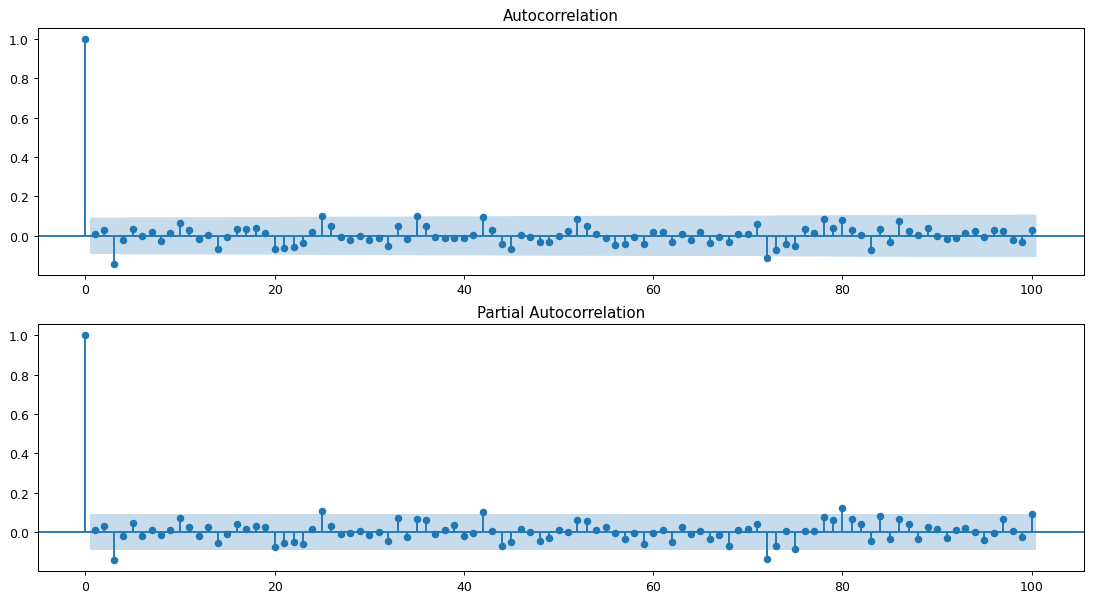

In [70]:
residuals = results['sarima_1_0_1_1_0_[1,2]_6'][1].resid
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = plot_acf(residuals, lags=100, ax=ax[0])
fig = plot_pacf(residuals, lags=100, ax=ax[1])
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02670D-01    |proj g|=  1.48637D+00

At iterate    5    f=  2.32573D-02    |proj g|=  2.86494D-01

At iterate   10    f=  1.86669D-03    |proj g|=  3.51757D-03

At iterate   15    f=  1.52492D-03    |proj g|=  5.93290D-02

At iterate   20    f= -2.58619D-03    |proj g|=  1.49633D-01

At iterate   25    f= -6.64693D-03    |proj g|=  2.78351D-01

At iterate   30    f= -9.32643D-03    |proj g|=  7.20346D-04

At iterate   35    f= -9.40771D-03    |proj g|=  3.49763D-03

At iterate   40    f= -9.91129D-03    |proj g|=  5.87123D-03

At iterate   45    f= -9.94135D-03    |proj g|=  4.09341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 4500x4500 with 0 Axes>

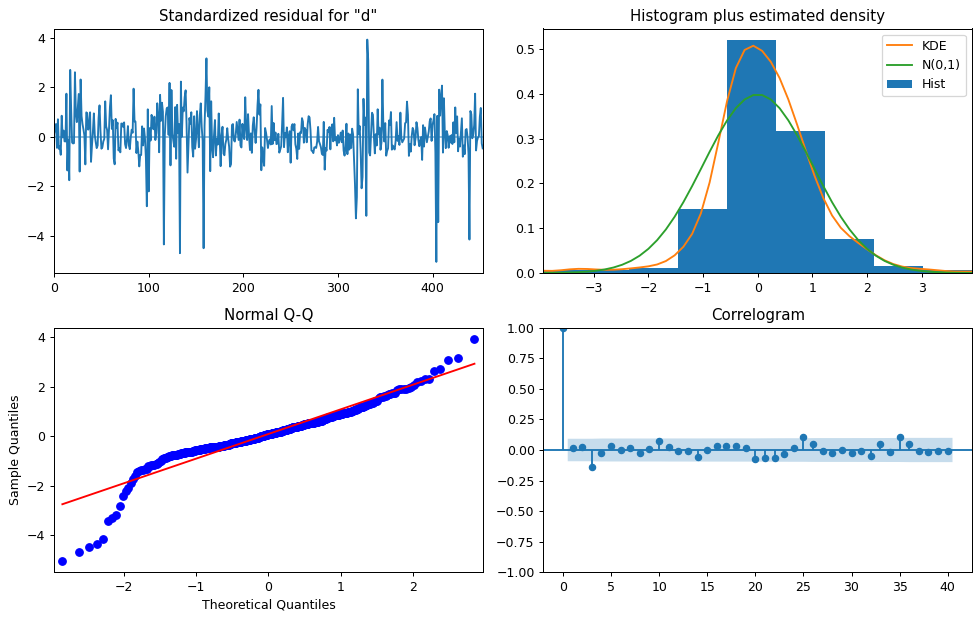

In [72]:
best_model = SARIMAX(no_sundays_data["demand_value"], 
                     order=(1, 0, 1),
                     seasonal_order=(1, 0, [1,2], 6),
                     enforce_stationarity=True,                 
                    ).fit()
print(best_model.summary())
plt.figure(figsize=(15, 15), dpi=300)
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=40)
plt.tight_layout()
plt.savefig("../../grafici/reziduali_arima.png", dpi=300)

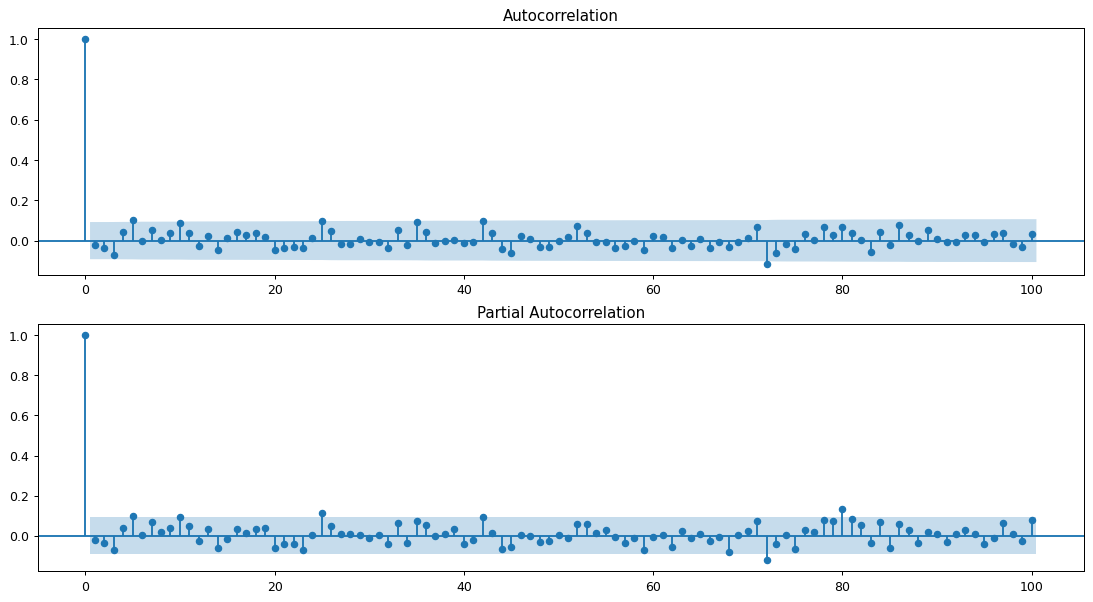

In [39]:
residuals = results['sarima_2_0_0_2_0_[1]_6'][1].resid
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = plot_acf(residuals, lags=100, ax=ax[0])
fig = plot_pacf(residuals, lags=100, ax=ax[1])
plt.show()

In [46]:
# 2021-04-01
final_df_2021_04_01 = final_df.dropna(axis=0, how='any')
actual = final_df_2021_04_01[['date', 'demand_value']]

In [47]:
columns = final_df.columns
metrics = []

for column in columns:
    if column.startswith("model"):
        df = final_df_2021_04_01[['date', column]]
        
        dict_metrics = {}
        dict_metrics['model'] = column
        
        if (actual['date'] == df['date']).all():
            mse, rmse, mae, r2 = regression_insights(actual['demand_value'], df[column])
            dict_metrics['mse'] = mse
            dict_metrics['rmse'] = rmse
            dict_metrics['mae'] = mae
            dict_metrics['r2'] = r2
            
            smape_value = smape(actual['demand_value'], df[column])
            dict_metrics['smape'] = smape_value
            
            bias_value = bias(actual['demand_value'], df[column])
            dict_metrics['bias'] = bias_value
            metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


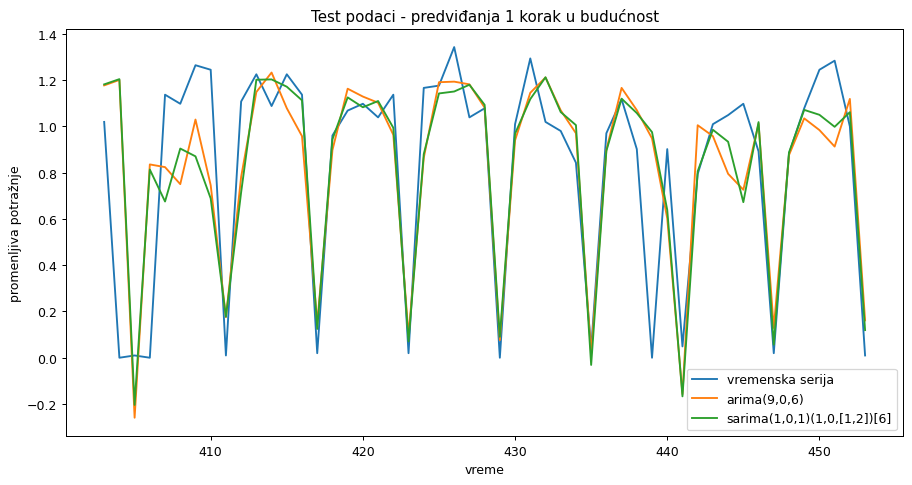

In [77]:
plt.figure(figsize=(12, 6))
plt.title("Test podaci - predviđanja 1 korak u budućnost")
plt.plot(actual['demand_value'], label='vremenska serija')
plt.plot(final_df_2021_04_01['model__arima_9_0_6__T1'], label='arima(9,0,6)')
plt.plot(final_df_2021_04_01['model__sarima_1_0_1_1_0_[1,2]_6__T1'], label='sarima(1,0,1)(1,0,[1,2])[6]')
plt.xlabel("vreme")
plt.ylabel("promenljiva potražnje")
plt.legend()
plt.savefig("../../grafici/test_dnevna_arima.eps", dpi=300)
plt.show()

In [49]:
for key in results.keys():
    print(f"{key}\tAIC: {results[key][1].aic}")

arima_1_0_1	AIC: 567.3902489644377
arima_1_0_0	AIC: 598.3044706482235
arima_6_0_6	AIC: 14.30923381946145
arima_9_0_6	AIC: 14.625448384029411
sarima_1_0_1_1_0_[1,2]_6	AIC: 3.8091156904078147
sarima_2_0_0_2_0_[1]_6	AIC: 8.567335093668738
sarima_0_0_2_0_0_1_6	AIC: 604.9619478371251


In [50]:
metrics_df[metrics_df['model'].apply(lambda x: x[-2:]) == "T1"]

model       mse      rmse       mae  \
0                 model__arima_1_0_1__T1  0.230040  0.479625  0.389531   
28                model__arima_1_0_0__T1  0.215804  0.464547  0.382899   
56                model__arima_6_0_6__T1  0.094383  0.307218  0.197462   
84                model__arima_9_0_6__T1  0.095371  0.308821  0.209452   
112  model__sarima_1_0_1_1_0_[1,2]_6__T1  0.094991  0.308206  0.192394   
140    model__sarima_2_0_0_2_0_[1]_6__T1  0.092266  0.303753  0.200078   
168      model__sarima_0_0_2_0_0_1_6__T1  0.310676  0.557383  0.441497   

           r2     smape          bias  
0   -0.063793  0.379000  3.467435e+08  
28   0.002038  0.375804  3.250128e+08  
56   0.563536  0.213063  3.103477e+08  
84   0.558969  0.224278  3.060995e+08  
112  0.560724  0.208225  3.084299e+08  
140  0.573326  0.215694  2.921658e+08  
168 -0.436687  0.479957  1.992346e+08

In [74]:
pd.set_option('display.max_rows', 500)

In [75]:
metrics_df

model       mse      rmse       mae  \
0                  model__arima_1_0_1__T1  0.230040  0.479625  0.389531   
1                  model__arima_1_0_1__T2  0.233819  0.483548  0.391641   
2                  model__arima_1_0_1__T3  0.230320  0.479917  0.389378   
3                  model__arima_1_0_1__T4  0.220731  0.469820  0.382646   
4                  model__arima_1_0_1__T5  0.211292  0.459665  0.373641   
5                  model__arima_1_0_1__T6  0.211369  0.459749  0.374584   
6                  model__arima_1_0_1__T7  0.229875  0.479453  0.391243   
7                  model__arima_1_0_1__T8  0.231682  0.481333  0.393362   
8                  model__arima_1_0_1__T9  0.225095  0.474442  0.387835   
9                 model__arima_1_0_1__T10  0.216590  0.465393  0.380276   
10                model__arima_1_0_1__T11  0.209545  0.457761  0.373510   
11                model__arima_1_0_1__T12  0.209360  0.457559  0.373258   
12                model__arima_1_0_1__T13  0.227343  0.476805  0.389122   
13                model__arima_1_0_1__T14  0.228500  0.478017  0.390279   
14                model__arima_1_0_1__T15  0.223714  0.472984  0.386054   
15                model__arima_1_0_1__T16  0.217303  0.466158  0.380722   
16                model__arima_1_0_1__T17  0.211398  0.459780  0.375205   
17                model__arima_1_0_1__T18  0.212504  0.460982  0.375737   
18                model__arima_1_0_1__T19  0.230039  0.479624  0.391479   
19                model__arima_1_0_1__T20  0.231174  0.480806  0.394084   
20                model__arima_1_0_1__T21  0.223805  0.473081  0.389510   
21                model__arima_1_0_1__T22  0.216031  0.464792  0.383915   
22                model__arima_1_0_1__T23  0.209754  0.457989  0.379460   
23                model__arima_1_0_1__T24  0.210094  0.458360  0.378924   
24                model__arima_1_0_1__T25  0.226656  0.476084  0.394615   
25                model__arima_1_0_1__T26  0.226571  0.475995  0.396519   
26                model__arima_1_0_1__T27  0.219796  0.468825  0.391574   
27                model__arima_1_0_1__T28  0.212147  0.460594  0.385618   
28                 model__arima_1_0_0__T1  0.215804  0.464547  0.382899   
29                 model__arima_1_0_0__T2  0.218317  0.467244  0.387189   
30                 model__arima_1_0_0__T3  0.217189  0.466036  0.386725   
31                 model__arima_1_0_0__T4  0.216503  0.465298  0.386387   
32                 model__arima_1_0_0__T5  0.216085  0.464850  0.386039   
33                 model__arima_1_0_0__T6  0.216002  0.464760  0.385920   
34                 model__arima_1_0_0__T7  0.216742  0.465555  0.386620   
35                 model__arima_1_0_0__T8  0.216825  0.465645  0.386744   
36                 model__arima_1_0_0__T9  0.216579  0.465381  0.386606   
37                model__arima_1_0_0__T10  0.216261  0.465038  0.386370   
38                model__arima_1_0_0__T11  0.215980  0.464737  0.386140   
39                model__arima_1_0_0__T12  0.215891  0.464641  0.386015   
40                model__arima_1_0_0__T13  0.216672  0.465481  0.386758   
41                model__arima_1_0_0__T14  0.216729  0.465542  0.386857   
42                model__arima_1_0_0__T15  0.216536  0.465334  0.386725   
43                model__arima_1_0_0__T16  0.216278  0.465057  0.386547   
44                model__arima_1_0_0__T17  0.216011  0.464770  0.386339   
45                model__arima_1_0_0__T18  0.215963  0.464718  0.386261   
46                model__arima_1_0_0__T19  0.216767  0.465582  0.387043   
47                model__arima_1_0_0__T20  0.216835  0.465655  0.387197   
48                model__arima_1_0_0__T21  0.216508  0.465304  0.387040   
49                model__arima_1_0_0__T22  0.216169  0.464940  0.386822   
50                model__arima_1_0_0__T23  0.215873  0.464621  0.386646   
51                model__arima_1_0_0__T24  0.215794  0.464537  0.386557   
52                model__arima_1_0_0__T25  0.216627  0.465432